In [1]:
import pandas as pd
from pandas import concat
import statsmodels.api as sm

from sklearn import metrics
from sklearn import preprocessing as prep
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels as sms
import statsmodels.tsa as tsa
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pmdarima as pm
import pandas_datareader as web
from arch import  arch_model
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt


In [2]:
from sklearn.utils import check_array
def MAPE(Y_test, preds): 
    Y_test, preds = np.array(Y_test), np.array(preds)
    return np.mean(np.abs((Y_test - preds) / Y_test)) * 100

In [3]:
stock = web.get_data_yahoo("T",
start = "2019-01-01",
end = "2021-11-17")
y=stock['Adj Close']

Y_t=y.T
Y_t=Y_t.iloc[1:727]
Y_train=Y_t

model = pm.auto_arima(Y_train, start_p=3, start_q=3,start_d=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=6, max_q=6, max_d=2, # maximum p and q
                      m=1,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      #start_P=0, 
                      #D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

#ARIMA model
Errors_000=[]
predds=list()
n=675
for i in range(0,50):
    Y_train=Y_t.iloc[:n+i]
    Y_test=Y_t.iloc[n+i:n+1+i]
    
    arima_model = ARIMA(Y_train, order=model.order)
    arima_model_fit = arima_model.fit()
    preds_arima= arima_model_fit.forecast(len(Y_test),alpha=0.3)
    preds_arima=np.array(preds_arima)
    preds_atempt_1=preds_arima
    preds = pd.Series(preds_arima, index=Y_test.index)
    
    mse = mean_squared_error(Y_test, preds)
    rmse = sqrt(mean_squared_error(Y_test, preds))
    mae = mean_absolute_error(Y_test, preds)
    mape=MAPE(Y_test, preds)
    predds.append(preds_atempt_1)

    Error_i = ([mse, rmse, mae, mape])
    Errors_000.append(Error_i)
    Errors_A=pd.DataFrame(Errors_000)




#Garch model   
Errors_001=[]

for i in range(0,50):
    Y_train=Y_t.iloc[:n+i]
    Y_test=Y_t.iloc[n+i:n+1+i]

    garch = arch_model(Y_train, vol="Garch", p=1, q=1, dist="gaussian")
    garch_fitted = garch.fit()
    garch_forecast = garch_fitted.forecast(horizon=1)
    garch_pred_mean = garch_forecast.mean['h.1'].iloc[-1]
    preds = pd.DataFrame([garch_pred_mean])

    mse = mean_squared_error(Y_test, preds)
    rmse = sqrt(mean_squared_error(Y_test, preds))
    mae = mean_absolute_error(Y_test, preds)
    mape=MAPE(Y_test, preds)
    Error_i = ([mse, rmse, mae, mape])
    Errors_001.append(Error_i)
    Errors_B=pd.DataFrame(Errors_001)

    
#ARIMA-GARCH model  
Errors_002=[]
predds_0=list()
for i in range(0,50):
    Y_train=Y_t.iloc[:n+i]
    Y_test=Y_t.iloc[n+i:n+1+i]
    
    arima_model = ARIMA(Y_train, order=(model.order))
    arima_model_fit = arima_model.fit()
    arima_residuals = arima_model_fit.resid
    predicted_mu = arima_model_fit.forecast(len(Y_test))
    garch = arch_model(arima_residuals, vol="Garch", p=1, q=1, dist="gaussian")
    garch_fitted = garch.fit()
    garch_forecast = garch_fitted.forecast(horizon=1)
    garch_pred_mean = garch_forecast.mean['h.1'].iloc[-1]
    garch_pred_var = garch_forecast.variance['h.1'].iloc[-1]

    # Combine both models' output: yt = mu + et
    preds = predicted_mu + garch_pred_mean
    preds_0=np.array(preds)
    predds_0.append(preds_0)

    mse = mean_squared_error(Y_test, preds)
    rmse = sqrt(mean_squared_error(Y_test, preds))
    mae = mean_absolute_error(Y_test, preds)
    mape=MAPE(Y_test, preds)
    Error_i = ([mse, rmse, mae, mape])
    Errors_002.append(Error_i)
    Errors_C=pd.DataFrame(Errors_002)
    
    
# print(Errors_A[3].mean())
# print(Errors_B[3].mean())
# print(Errors_C[3].mean())

Performing stepwise search to minimize aic
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=860.050, Time=1.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=904.877, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=896.080, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=897.290, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=902.878, Time=0.04 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=896.053, Time=0.90 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=877.466, Time=0.56 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=854.800, Time=1.24 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=859.919, Time=0.65 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=854.477, Time=1.37 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=861.776, Time=1.00 sec
 ARIMA(6,1,3)(0,0,0)[0] intercept   : AIC=854.394, Time=1.67 sec
 ARIMA(6,1,2)(0,0,0)[0] intercept   : AIC=845.717, Time=1.03 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=852.162, Time=0.63 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=861.4

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A dat

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A dat

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A dat

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A dat

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A dat

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A dat

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex

Iteration:      1,   Func. Count:      6,   Neg. LLF: 4629795156474.973
Iteration:      2,   Func. Count:     14,   Neg. LLF: 442763946.54032326
Iteration:      3,   Func. Count:     20,   Neg. LLF: 415486644383.29645
Iteration:      4,   Func. Count:     28,   Neg. LLF: 41204.85487487884
Iteration:      5,   Func. Count:     34,   Neg. LLF: 8409.369709884495
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1439.5393793398976
Iteration:      7,   Func. Count:     46,   Neg. LLF: 1215.4115059161395
Iteration:      8,   Func. Count:     52,   Neg. LLF: 1195.2105001631726
Iteration:      9,   Func. Count:     58,   Neg. LLF: 1147.8188804441534
Iteration:     10,   Func. Count:     64,   Neg. LLF: 1224.3995045362208
Iteration:     11,   Func. Count:     70,   Neg. LLF: 1190.8597216187077
Iteration:     12,   Func. Count:     76,   Neg. LLF: 1184.9254324369715
Iteration:     13,   Func. Count:     82,   Neg. LLF: 1153.9457551925675
Iteration:     14,   Func. Count:     88,   Neg. LLF: 

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      7,   Func. Count:     46,   Neg. LLF: 1225.416673205192
Iteration:      8,   Func. Count:     52,   Neg. LLF: 1205.2193249471634
Iteration:      9,   Func. Count:     58,   Neg. LLF: 1153.325485679095
Iteration:     10,   Func. Count:     64,   Neg. LLF: 1234.937946627785
Iteration:     11,   Func. Count:     70,   Neg. LLF: 1200.9543489237994
Iteration:     12,   Func. Count:     76,   Neg. LLF: 1195.0950260247382
Iteration:     13,   Func. Count:     82,   Neg. LLF: 1154.5509064248445
Iteration:     14,   Func. Count:     88,   Neg. LLF: 1194.7290404949176
Iteration:     15,   Func. Count:     94,   Neg. LLF: 1113.8705790496397
Iteration:     16,   Func. Count:     99,   Neg. LLF: 1113.3765128628202
Iteration:     17,   Func. Count:    104,   Neg. LLF: 1113.6637526956356
Iteration:     18,   Func. Count:    110,   Neg. LLF: 1113.0592382760556
Iteration:     19,   Func. Count:    115,   Neg. LLF: 1112.981843617505
Iteration:     20,   Func. Count:    120,   Neg. LLF: 1

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      2,   Func. Count:     14,   Neg. LLF: 426990633.84418595
Iteration:      3,   Func. Count:     20,   Neg. LLF: 8098836632.458429
Iteration:      4,   Func. Count:     28,   Neg. LLF: 23308.264294675297
Iteration:      5,   Func. Count:     34,   Neg. LLF: 8767.077100022198
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1585.5630634309005
Iteration:      7,   Func. Count:     46,   Neg. LLF: 1233.7952064537408
Iteration:      8,   Func. Count:     52,   Neg. LLF: 1212.363747764481
Iteration:      9,   Func. Count:     58,   Neg. LLF: 1156.7974224573093
Iteration:     10,   Func. Count:     64,   Neg. LLF: 1236.9492362289059
Iteration:     11,   Func. Count:     70,   Neg. LLF: 1206.5027312970167
Iteration:     12,   Func. Count:     76,   Neg. LLF: 1201.7084451775881
Iteration:     13,   Func. Count:     82,   Neg. LLF: 1157.0043646541167
Iteration:     14,   Func. Count:     88,   Neg. LLF: 1201.4842509310852
Iteration:     15,   Func. Count:     94,   Neg. LLF: 

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     13,   Func. Count:     82,   Neg. LLF: 1160.21897208906
Iteration:     14,   Func. Count:     88,   Neg. LLF: 1203.7395221489828
Iteration:     15,   Func. Count:     94,   Neg. LLF: 1120.9129456552741
Iteration:     16,   Func. Count:     99,   Neg. LLF: 1120.4449285195892
Iteration:     17,   Func. Count:    104,   Neg. LLF: 1120.4254014787675
Iteration:     18,   Func. Count:    110,   Neg. LLF: 1120.0976314427542
Iteration:     19,   Func. Count:    115,   Neg. LLF: 1120.0362326443994
Iteration:     20,   Func. Count:    120,   Neg. LLF: 1120.0359500254847
Iteration:     21,   Func. Count:    125,   Neg. LLF: 1120.035948224212
Iteration:     22,   Func. Count:    129,   Neg. LLF: 1120.0359482083304
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1120.035948224212
            Iterations: 22
            Function evaluations: 129
            Gradient evaluations: 22
Iteration:      1,   Func. Count:      6,   Neg. LLF: 541128228

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      2,   Func. Count:     14,   Neg. LLF: 421262597.9019164
Iteration:      3,   Func. Count:     20,   Neg. LLF: 7477295271.910531
Iteration:      4,   Func. Count:     28,   Neg. LLF: 33876.0136140073
Iteration:      5,   Func. Count:     34,   Neg. LLF: 28130.771098998564
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1436.5073557338587
Iteration:      7,   Func. Count:     46,   Neg. LLF: 1241.7219131243787
Iteration:      8,   Func. Count:     52,   Neg. LLF: 1219.7765806232965
Iteration:      9,   Func. Count:     58,   Neg. LLF: 1160.7637454376636
Iteration:     10,   Func. Count:     64,   Neg. LLF: 1227.792359964996
Iteration:     11,   Func. Count:     70,   Neg. LLF: 1210.1752867926461
Iteration:     12,   Func. Count:     76,   Neg. LLF: 1207.213037375936
Iteration:     13,   Func. Count:     82,   Neg. LLF: 1163.6008206165648
Iteration:     14,   Func. Count:     88,   Neg. LLF: 1207.6587151306564
Iteration:     15,   Func. Count:     94,   Neg. LLF: 112

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     19,   Func. Count:    114,   Neg. LLF: 1126.4666341748855
Iteration:     20,   Func. Count:    119,   Neg. LLF: 1126.4600075312903
Iteration:     21,   Func. Count:    124,   Neg. LLF: 1126.4595040735862
Iteration:     22,   Func. Count:    128,   Neg. LLF: 1126.4595040733543
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1126.4595040735862
            Iterations: 22
            Function evaluations: 128
            Gradient evaluations: 22
Iteration:      1,   Func. Count:      6,   Neg. LLF: 5792777367572.879
Iteration:      2,   Func. Count:     14,   Neg. LLF: 415177236.4865744
Iteration:      3,   Func. Count:     20,   Neg. LLF: 3028895688.530899
Iteration:      4,   Func. Count:     28,   Neg. LLF: 19858.322963172697
Iteration:      5,   Func. Count:     34,   Neg. LLF: 34165.286405198305
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1418.4808083947687
Iteration:      7,   Func. Count:     46,   Neg. LLF: 1244.454

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      5,   Func. Count:     34,   Neg. LLF: 34192.62741740322
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1493.5605085721534
Iteration:      7,   Func. Count:     46,   Neg. LLF: 1256.6901988006732
Iteration:      8,   Func. Count:     52,   Neg. LLF: 1233.3633183521215
Iteration:      9,   Func. Count:     58,   Neg. LLF: 1167.900998311491
Iteration:     10,   Func. Count:     64,   Neg. LLF: 1236.6470172876518
Iteration:     11,   Func. Count:     70,   Neg. LLF: 1224.2589811346395
Iteration:     12,   Func. Count:     76,   Neg. LLF: 1220.548820434792
Iteration:     13,   Func. Count:     82,   Neg. LLF: 1170.10060355823
Iteration:     14,   Func. Count:     88,   Neg. LLF: 1211.418275285264
Iteration:     15,   Func. Count:     94,   Neg. LLF: 1134.3251835673777
Iteration:     16,   Func. Count:     99,   Neg. LLF: 1134.2623362562479
Iteration:     17,   Func. Count:    105,   Neg. LLF: 1133.4919489155375
Iteration:     18,   Func. Count:    110,   Neg. LLF: 113

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     11,   Func. Count:     70,   Neg. LLF: 1230.8039000537956
Iteration:     12,   Func. Count:     76,   Neg. LLF: 1227.0234130715544
Iteration:     13,   Func. Count:     82,   Neg. LLF: 1176.3777105586737
Iteration:     14,   Func. Count:     88,   Neg. LLF: 1196.7005639034987
Iteration:     15,   Func. Count:     94,   Neg. LLF: 1140.2659175024096
Iteration:     16,   Func. Count:     99,   Neg. LLF: 1140.1992662385637
Iteration:     17,   Func. Count:    105,   Neg. LLF: 1139.4223187191405
Iteration:     18,   Func. Count:    110,   Neg. LLF: 1139.0758340928555
Iteration:     19,   Func. Count:    115,   Neg. LLF: 1138.9555868116322
Iteration:     20,   Func. Count:    120,   Neg. LLF: 1138.9420059539368
Iteration:     21,   Func. Count:    125,   Neg. LLF: 1138.9409876940767
Iteration:     22,   Func. Count:    130,   Neg. LLF: 1138.9409841010697
Iteration:     23,   Func. Count:    134,   Neg. LLF: 1138.9409840788953
Optimization terminated successfully    (Exit mode 

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      2,   Func. Count:     14,   Neg. LLF: 419083918.73775434
Iteration:      3,   Func. Count:     20,   Neg. LLF: 592359744432.971
Iteration:      4,   Func. Count:     28,   Neg. LLF: 20300.33358422231
Iteration:      5,   Func. Count:     34,   Neg. LLF: 161997.14353603282
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1491.6847609309675
Iteration:      7,   Func. Count:     46,   Neg. LLF: 1264.8299771450288
Iteration:      8,   Func. Count:     52,   Neg. LLF: 1247.245002539886
Iteration:      9,   Func. Count:     58,   Neg. LLF: 1180.7409060215386
Iteration:     10,   Func. Count:     64,   Neg. LLF: 1248.4257197089846
Iteration:     11,   Func. Count:     70,   Neg. LLF: 1239.5769062999873
Iteration:     12,   Func. Count:     76,   Neg. LLF: 1235.5475310316656
Iteration:     13,   Func. Count:     82,   Neg. LLF: 1184.316900823193
Iteration:     14,   Func. Count:     88,   Neg. LLF: 1193.6297167698556
Iteration:     15,   Func. Count:     94,   Neg. LLF: 11

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      2,   Func. Count:     14,   Neg. LLF: 420177254.0204189
Iteration:      3,   Func. Count:     20,   Neg. LLF: 4436275558.024018
Iteration:      4,   Func. Count:     28,   Neg. LLF: 87026.44674584066
Iteration:      5,   Func. Count:     34,   Neg. LLF: 36118.35926105547
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1493.145380093688
Iteration:      7,   Func. Count:     46,   Neg. LLF: 1273.3625876162835
Iteration:      8,   Func. Count:     52,   Neg. LLF: 1262.4969054831981
Iteration:      9,   Func. Count:     58,   Neg. LLF: 1194.3413743639142
Iteration:     10,   Func. Count:     64,   Neg. LLF: 1260.8568312765403
Iteration:     11,   Func. Count:     70,   Neg. LLF: 1256.2782243740944
Iteration:     12,   Func. Count:     76,   Neg. LLF: 1249.8766334542747
Iteration:     13,   Func. Count:     82,   Neg. LLF: 1199.0064199289584
Iteration:     14,   Func. Count:     88,   Neg. LLF: 1196.7970587957343
Iteration:     15,   Func. Count:     94,   Neg. LLF: 11

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     14,   Func. Count:     88,   Neg. LLF: 1199.2305259488999
Iteration:     15,   Func. Count:     94,   Neg. LLF: 1168.9778480345783
Iteration:     16,   Func. Count:     99,   Neg. LLF: 1168.7658319262373
Iteration:     17,   Func. Count:    104,   Neg. LLF: 1168.1420015649128
Iteration:     18,   Func. Count:    109,   Neg. LLF: 1167.8359551107396
Iteration:     19,   Func. Count:    114,   Neg. LLF: 1167.7694093531163
Iteration:     20,   Func. Count:    119,   Neg. LLF: 1167.7594693121446
Iteration:     21,   Func. Count:    124,   Neg. LLF: 1167.7592561179767
Iteration:     22,   Func. Count:    129,   Neg. LLF: 1167.7592474357702
Iteration:     23,   Func. Count:    133,   Neg. LLF: 1167.7592474149674
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1167.7592474357702
            Iterations: 23
            Function evaluations: 133
            Gradient evaluations: 23
Iteration:      1,   Func. Count:      6,   Neg. LLF: 22324

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      2,   Func. Count:     14,   Neg. LLF: 420048775.86344874
Iteration:      3,   Func. Count:     20,   Neg. LLF: 657617568560.4597
Iteration:      4,   Func. Count:     28,   Neg. LLF: 9521.122643681074
Iteration:      5,   Func. Count:     34,   Neg. LLF: 13755.333808263706
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1502.9663733977225
Iteration:      7,   Func. Count:     46,   Neg. LLF: 1284.6768548043726
Iteration:      8,   Func. Count:     52,   Neg. LLF: 1280.7624023678186
Iteration:      9,   Func. Count:     58,   Neg. LLF: 1208.9609035757628
Iteration:     10,   Func. Count:     64,   Neg. LLF: 1274.986985248057
Iteration:     11,   Func. Count:     70,   Neg. LLF: 1275.7193739329762
Iteration:     12,   Func. Count:     76,   Neg. LLF: 1259.4292104240124
Iteration:     13,   Func. Count:     82,   Neg. LLF: 1214.5275045423575
Iteration:     14,   Func. Count:     88,   Neg. LLF: 1206.352372453836
Iteration:     15,   Func. Count:     94,   Neg. LLF: 1

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     11,   Func. Count:     70,   Neg. LLF: 1284.4414169429174
Iteration:     12,   Func. Count:     76,   Neg. LLF: 1266.7635909148273
Iteration:     13,   Func. Count:     82,   Neg. LLF: 1221.0840339775036
Iteration:     14,   Func. Count:     88,   Neg. LLF: 1212.2984328673697
Iteration:     15,   Func. Count:     94,   Neg. LLF: 1184.893582070202
Iteration:     16,   Func. Count:     99,   Neg. LLF: 1184.564972417192
Iteration:     17,   Func. Count:    104,   Neg. LLF: 1184.0449226261576
Iteration:     18,   Func. Count:    109,   Neg. LLF: 1183.7961227445023
Iteration:     19,   Func. Count:    114,   Neg. LLF: 1183.7488632410914
Iteration:     20,   Func. Count:    119,   Neg. LLF: 1183.7451889790302
Iteration:     21,   Func. Count:    124,   Neg. LLF: 1183.745123568187
Iteration:     22,   Func. Count:    129,   Neg. LLF: 1183.7451226888425
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1183.7451226888425
            Iterat

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 27096557333746.72
Iteration:      2,   Func. Count:     15,   Neg. LLF: 17621669.725312725
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1792.1381095782003
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.2816316228103
Iteration:      5,   Func. Count:     35,   Neg. LLF: 758.8891689805464
Iteration:      6,   Func. Count:     42,   Neg. LLF: 327.323873859157
Iteration:      7,   Func. Count:     47,   Neg. LLF: 327.10963939605597
Iteration:      8,   Func. Count:     52,   Neg. LLF: 326.9607002874222
Iteration:      9,   Func. Count:     57,   Neg. LLF: 326.74141087449175
Iteration:     10,   Func. Count:     62,   Neg. LLF: 326.287724132878
Iteration:     11,   Func. Count:     67,   Neg. LLF: 326.1017970187878
Iteration:     12,   Func. Count:     72,   Neg. LLF: 326.08043313798333
Iteration:     13,   Func. Count:     77,   Neg. LLF: 326.07813684521744
Iteration:     14,   Func. Count:     82,   Neg. LLF: 326.07

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 27353421907276.844
Iteration:      2,   Func. Count:     15,   Neg. LLF: 330204321.8686043
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1793.6878468836612
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.36586243607974
Iteration:      5,   Func. Count:     35,   Neg. LLF: 982.2889297241405
Iteration:      6,   Func. Count:     42,   Neg. LLF: 327.0836538789888
Iteration:      7,   Func. Count:     47,   Neg. LLF: 326.9423480332787
Iteration:      8,   Func. Count:     52,   Neg. LLF: 326.7785635545101
Iteration:      9,   Func. Count:     57,   Neg. LLF: 327.6160964555693
Iteration:     10,   Func. Count:     63,   Neg. LLF: 328.56598352106107
Iteration:     11,   Func. Count:     69,   Neg. LLF: 325.9510522022989
Iteration:     12,   Func. Count:     74,   Neg. LLF: 325.88634904313324
Iteration:     13,   Func. Count:     79,   Neg. LLF: 325.88503478639166
Iteration:     14,   Func. Count:     84,   Neg. LLF: 325.

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 27592504392019.184
Iteration:      2,   Func. Count:     15,   Neg. LLF: 8226149.402955751
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1795.0560140152904
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.54732842555575
Iteration:      5,   Func. Count:     35,   Neg. LLF: 4784.022191150123
Iteration:      6,   Func. Count:     42,   Neg. LLF: 326.8128507709374
Iteration:      7,   Func. Count:     47,   Neg. LLF: 326.71657788146035
Iteration:      8,   Func. Count:     52,   Neg. LLF: 326.4387999365496
Iteration:      9,   Func. Count:     57,   Neg. LLF: 334.34939648166926
Iteration:     10,   Func. Count:     63,   Neg. LLF: 336.5836123542716
Iteration:     11,   Func. Count:     69,   Neg. LLF: 325.6910730679905
Iteration:     12,   Func. Count:     74,   Neg. LLF: 325.6437057102588
Iteration:     13,   Func. Count:     79,   Neg. LLF: 325.6397549600801
Iteration:     14,   Func. Count:     84,   Neg. LLF: 325.6

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2945374716.884644
Iteration:      2,   Func. Count:     15,   Neg. LLF: 6390509.653345004
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1799.9697706829968
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.2501351082146
Iteration:      5,   Func. Count:     35,   Neg. LLF: 827.7192229783741
Iteration:      6,   Func. Count:     42,   Neg. LLF: 327.1858507132168
Iteration:      7,   Func. Count:     47,   Neg. LLF: 326.9922456972415
Iteration:      8,   Func. Count:     52,   Neg. LLF: 326.85259275427745
Iteration:      9,   Func. Count:     57,   Neg. LLF: 326.58107356731534
Iteration:     10,   Func. Count:     62,   Neg. LLF: 326.1848985909644
Iteration:     11,   Func. Count:     67,   Neg. LLF: 325.98473058672744
Iteration:     12,   Func. Count:     72,   Neg. LLF: 325.9596538649719
Iteration:     13,   Func. Count:     77,   Neg. LLF: 325.9567479728722
Iteration:     14,   Func. Count:     82,   Neg. LLF: 325.95

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1545854531.8357847
Iteration:      2,   Func. Count:     15,   Neg. LLF: 30959241.516924497
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1804.0652245251858
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.176971329897
Iteration:      5,   Func. Count:     35,   Neg. LLF: 542.9211881096633
Iteration:      6,   Func. Count:     41,   Neg. LLF: 327.64393468227775
Iteration:      7,   Func. Count:     46,   Neg. LLF: 326.9870250190902
Iteration:      8,   Func. Count:     51,   Neg. LLF: 326.6242740875422
Iteration:      9,   Func. Count:     56,   Neg. LLF: 326.7608041329406
Iteration:     10,   Func. Count:     62,   Neg. LLF: 326.35721142029877
Iteration:     11,   Func. Count:     67,   Neg. LLF: 326.3557762910135
Iteration:     12,   Func. Count:     72,   Neg. LLF: 326.3557495584513
Iteration:     13,   Func. Count:     77,   Neg. LLF: 326.35574039098327
Iteration:     14,   Func. Count:     81,   Neg. LLF: 326.3

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 28147890837583.133
Iteration:      2,   Func. Count:     15,   Neg. LLF: 26447909.957284324
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1806.7188941912489
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.33250288442537
Iteration:      5,   Func. Count:     35,   Neg. LLF: 519.7106965815054
Iteration:      6,   Func. Count:     41,   Neg. LLF: 327.8002861561984
Iteration:      7,   Func. Count:     46,   Neg. LLF: 327.07065463584394
Iteration:      8,   Func. Count:     51,   Neg. LLF: 326.7240890367576
Iteration:      9,   Func. Count:     56,   Neg. LLF: 326.6465562102823
Iteration:     10,   Func. Count:     61,   Neg. LLF: 326.52022973089134
Iteration:     11,   Func. Count:     66,   Neg. LLF: 326.51903299738143
Iteration:     12,   Func. Count:     71,   Neg. LLF: 326.5189464303518
Iteration:     13,   Func. Count:     76,   Neg. LLF: 326.51893810997024
Iteration:     14,   Func. Count:     81,   Neg. LLF: 32

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 675830523.6613821
Iteration:      2,   Func. Count:     15,   Neg. LLF: 334126391.6698926
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1809.1704340552815
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.44576595113733
Iteration:      5,   Func. Count:     35,   Neg. LLF: 511.44050869129313
Iteration:      6,   Func. Count:     41,   Neg. LLF: 327.9110482980596
Iteration:      7,   Func. Count:     46,   Neg. LLF: 327.1317490607984
Iteration:      8,   Func. Count:     51,   Neg. LLF: 326.80115709588256
Iteration:      9,   Func. Count:     56,   Neg. LLF: 326.7111182657074
Iteration:     10,   Func. Count:     61,   Neg. LLF: 326.60736331813087
Iteration:     11,   Func. Count:     66,   Neg. LLF: 326.6063653519638
Iteration:     12,   Func. Count:     71,   Neg. LLF: 326.6062766864203
Iteration:     13,   Func. Count:     76,   Neg. LLF: 326.60626756086083
Iteration:     14,   Func. Count:     81,   Neg. LLF: 326.

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 565260206.8874304
Iteration:      2,   Func. Count:     15,   Neg. LLF: 334155895.5792709
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1810.7708456713058
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.5023089411085
Iteration:      5,   Func. Count:     35,   Neg. LLF: 610.9385303844539
Iteration:      6,   Func. Count:     41,   Neg. LLF: 327.66661460798537
Iteration:      7,   Func. Count:     46,   Neg. LLF: 327.1316484831566
Iteration:      8,   Func. Count:     51,   Neg. LLF: 326.8294336761576
Iteration:      9,   Func. Count:     56,   Neg. LLF: 328.52081895873954
Iteration:     10,   Func. Count:     62,   Neg. LLF: 326.4371434147338
Iteration:     11,   Func. Count:     67,   Neg. LLF: 326.4327182174196
Iteration:     12,   Func. Count:     72,   Neg. LLF: 326.4325344573707
Iteration:     13,   Func. Count:     77,   Neg. LLF: 326.4324666849874
Iteration:     14,   Func. Count:     82,   Neg. LLF: 326.432

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 616004902.8517436
Iteration:      2,   Func. Count:     15,   Neg. LLF: 334225142.7226224
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1812.2811383147239
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.5254582766817
Iteration:      5,   Func. Count:     35,   Neg. LLF: 767.1529208714801
Iteration:      6,   Func. Count:     42,   Neg. LLF: 327.4397767561114
Iteration:      7,   Func. Count:     47,   Neg. LLF: 327.2151139440772
Iteration:      8,   Func. Count:     52,   Neg. LLF: 327.10821327829234
Iteration:      9,   Func. Count:     57,   Neg. LLF: 326.34784219483663
Iteration:     10,   Func. Count:     62,   Neg. LLF: 326.2663020325373
Iteration:     11,   Func. Count:     67,   Neg. LLF: 326.2072052066774
Iteration:     12,   Func. Count:     72,   Neg. LLF: 326.2066466019292
Iteration:     13,   Func. Count:     77,   Neg. LLF: 326.2065655900426
Iteration:     14,   Func. Count:     82,   Neg. LLF: 326.206

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 12932948648.147038
Iteration:      2,   Func. Count:     15,   Neg. LLF: 47513318.26633008
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1816.4471143371197
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.4711548966716
Iteration:      5,   Func. Count:     35,   Neg. LLF: 567.322070061766
Iteration:      6,   Func. Count:     41,   Neg. LLF: 327.7921738090681
Iteration:      7,   Func. Count:     46,   Neg. LLF: 327.17206728168816
Iteration:      8,   Func. Count:     51,   Neg. LLF: 326.8721165400394
Iteration:      9,   Func. Count:     56,   Neg. LLF: 328.29005434863154
Iteration:     10,   Func. Count:     62,   Neg. LLF: 326.48512801338404
Iteration:     11,   Func. Count:     67,   Neg. LLF: 326.4821204024927
Iteration:     12,   Func. Count:     72,   Neg. LLF: 326.48210161929956
Iteration:     13,   Func. Count:     77,   Neg. LLF: 326.48209600377237
Iteration:     14,   Func. Count:     81,   Neg. LLF: 326.

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 29456941267508.816
Iteration:      2,   Func. Count:     15,   Neg. LLF: 24207820.880249016
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1818.9470535180062
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.58832178104285
Iteration:      5,   Func. Count:     35,   Neg. LLF: 553.1788631904434
Iteration:      6,   Func. Count:     41,   Neg. LLF: 327.94971325941214
Iteration:      7,   Func. Count:     46,   Neg. LLF: 327.2705343446464
Iteration:      8,   Func. Count:     51,   Neg. LLF: 326.98674516225003
Iteration:      9,   Func. Count:     56,   Neg. LLF: 328.0488882541763
Iteration:     10,   Func. Count:     62,   Neg. LLF: 326.6110782115687
Iteration:     11,   Func. Count:     67,   Neg. LLF: 326.6090175727521
Iteration:     12,   Func. Count:     72,   Neg. LLF: 326.6090008868941
Iteration:     13,   Func. Count:     77,   Neg. LLF: 326.6089942285717
Iteration:     14,   Func. Count:     81,   Neg. LLF: 326.

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 974665665.4596663
Iteration:      2,   Func. Count:     15,   Neg. LLF: 12695415.508325566
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1820.4774991591826
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.71871617313775
Iteration:      5,   Func. Count:     35,   Neg. LLF: 719.7479724184191
Iteration:      6,   Func. Count:     42,   Neg. LLF: 327.6890788910542
Iteration:      7,   Func. Count:     47,   Neg. LLF: 327.37536150866686
Iteration:      8,   Func. Count:     52,   Neg. LLF: 327.291955911602
Iteration:      9,   Func. Count:     57,   Neg. LLF: 326.5110353739687
Iteration:     10,   Func. Count:     62,   Neg. LLF: 327.60737462930354
Iteration:     11,   Func. Count:     68,   Neg. LLF: 326.42857461848905
Iteration:     12,   Func. Count:     73,   Neg. LLF: 326.42522191234553
Iteration:     13,   Func. Count:     78,   Neg. LLF: 326.42518094453237
Iteration:     14,   Func. Count:     83,   Neg. LLF: 326

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 30472215423182.965
Iteration:      2,   Func. Count:     15,   Neg. LLF: 15430107.292693466
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1822.9816747194081
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.6820156225871
Iteration:      5,   Func. Count:     35,   Neg. LLF: 745.7164488281842
Iteration:      6,   Func. Count:     42,   Neg. LLF: 327.62237886671926
Iteration:      7,   Func. Count:     47,   Neg. LLF: 327.31004379028684
Iteration:      8,   Func. Count:     52,   Neg. LLF: 327.2303541122181
Iteration:      9,   Func. Count:     57,   Neg. LLF: 326.4612314833846
Iteration:     10,   Func. Count:     62,   Neg. LLF: 329.45234371671387
Iteration:     11,   Func. Count:     68,   Neg. LLF: 326.36430332845754
Iteration:     12,   Func. Count:     73,   Neg. LLF: 326.36017038802606
Iteration:     13,   Func. Count:     78,   Neg. LLF: 326.3601368806935
Iteration:     14,   Func. Count:     83,   Neg. LLF: 32

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 674974068.8334036
Iteration:      2,   Func. Count:     15,   Neg. LLF: 90125885.14097776
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1825.2638023487007
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.71624523327364
Iteration:      5,   Func. Count:     35,   Neg. LLF: 845.6041796833399
Iteration:      6,   Func. Count:     42,   Neg. LLF: 327.4631910614695
Iteration:      7,   Func. Count:     47,   Neg. LLF: 327.2112456279868
Iteration:      8,   Func. Count:     52,   Neg. LLF: 327.1374814309893
Iteration:      9,   Func. Count:     57,   Neg. LLF: 326.387456093248
Iteration:     10,   Func. Count:     62,   Neg. LLF: 334.7766745969226
Iteration:     11,   Func. Count:     68,   Neg. LLF: 326.2683993965357
Iteration:     12,   Func. Count:     73,   Neg. LLF: 326.2588344932183
Iteration:     13,   Func. Count:     78,   Neg. LLF: 326.25882536044014
Iteration:     14,   Func. Count:     83,   Neg. LLF: 326.2588

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2064034976.4076903
Iteration:      2,   Func. Count:     15,   Neg. LLF: 337204212.84412396
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1827.8911314815366
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.69963380681094
Iteration:      5,   Func. Count:     35,   Neg. LLF: 772.0873622322847
Iteration:      6,   Func. Count:     42,   Neg. LLF: 327.5974104388438
Iteration:      7,   Func. Count:     47,   Neg. LLF: 327.28527661095694
Iteration:      8,   Func. Count:     52,   Neg. LLF: 327.214076532693
Iteration:      9,   Func. Count:     57,   Neg. LLF: 326.48956723135507
Iteration:     10,   Func. Count:     62,   Neg. LLF: 351.7319313832445
Iteration:     11,   Func. Count:     68,   Neg. LLF: 326.3556655655804
Iteration:     12,   Func. Count:     73,   Neg. LLF: 326.3508661743183
Iteration:     13,   Func. Count:     78,   Neg. LLF: 326.3506347818852
Iteration:     14,   Func. Count:     83,   Neg. LLF: 326.3

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 476646372.3191755
Iteration:      2,   Func. Count:     15,   Neg. LLF: 9195364.467407387
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1830.1021276602883
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.79664873953914
Iteration:      5,   Func. Count:     35,   Neg. LLF: 865.5153632228503
Iteration:      6,   Func. Count:     42,   Neg. LLF: 327.4839758872753
Iteration:      7,   Func. Count:     47,   Neg. LLF: 327.2334447539628
Iteration:      8,   Func. Count:     52,   Neg. LLF: 327.1702890773763
Iteration:      9,   Func. Count:     57,   Neg. LLF: 326.4901452005121
Iteration:     10,   Func. Count:     62,   Neg. LLF: 361.1551102882954
Iteration:     11,   Func. Count:     68,   Neg. LLF: 326.3129836202919
Iteration:     12,   Func. Count:     73,   Neg. LLF: 326.3057836134844
Iteration:     13,   Func. Count:     78,   Neg. LLF: 326.3055616508573
Iteration:     14,   Func. Count:     83,   Neg. LLF: 326.3055

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 31677066544787.242
Iteration:      2,   Func. Count:     15,   Neg. LLF: 337877047.2699435
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1832.1038289712726
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.89761418994715
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1036.0053949759395
Iteration:      6,   Func. Count:     42,   Neg. LLF: 327.29857385394234
Iteration:      7,   Func. Count:     47,   Neg. LLF: 327.1163540973263
Iteration:      8,   Func. Count:     52,   Neg. LLF: 327.0585827183888
Iteration:      9,   Func. Count:     57,   Neg. LLF: 326.4072205223742
Iteration:     10,   Func. Count:     62,   Neg. LLF: 364.5425783516283
Iteration:     11,   Func. Count:     68,   Neg. LLF: 326.2072476606529
Iteration:     12,   Func. Count:     73,   Neg. LLF: 326.1905762983672
Iteration:     13,   Func. Count:     78,   Neg. LLF: 326.1897787391442
Iteration:     14,   Func. Count:     83,   Neg. LLF: 326.1

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 31986031043500.535
Iteration:      2,   Func. Count:     15,   Neg. LLF: 339191480.2923355
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1837.0199617238868
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.6667387678405
Iteration:      5,   Func. Count:     35,   Neg. LLF: 559.632174630205
Iteration:      6,   Func. Count:     41,   Neg. LLF: 328.20261339377583
Iteration:      7,   Func. Count:     46,   Neg. LLF: 327.3164516695779
Iteration:      8,   Func. Count:     51,   Neg. LLF: 327.10045532281407
Iteration:      9,   Func. Count:     56,   Neg. LLF: 327.181720335058
Iteration:     10,   Func. Count:     62,   Neg. LLF: 326.67784444045986
Iteration:     11,   Func. Count:     67,   Neg. LLF: 326.6759825482238
Iteration:     12,   Func. Count:     72,   Neg. LLF: 326.67573696838696
Iteration:     13,   Func. Count:     77,   Neg. LLF: 326.67571841208013
Iteration:     14,   Func. Count:     81,   Neg. LLF: 326.6

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 7567756809.90123
Iteration:      2,   Func. Count:     15,   Neg. LLF: 16097117.333413156
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1838.9071235346696
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.8377075404852
Iteration:      5,   Func. Count:     35,   Neg. LLF: 669.6841247908491
Iteration:      6,   Func. Count:     42,   Neg. LLF: 327.9738985043186
Iteration:      7,   Func. Count:     47,   Neg. LLF: 327.4668556541211
Iteration:      8,   Func. Count:     52,   Neg. LLF: 327.4088513296392
Iteration:      9,   Func. Count:     57,   Neg. LLF: 326.8186340843903
Iteration:     10,   Func. Count:     62,   Neg. LLF: 348.042754711016
Iteration:     11,   Func. Count:     68,   Neg. LLF: 326.6051989299048
Iteration:     12,   Func. Count:     73,   Neg. LLF: 326.60281828961035
Iteration:     13,   Func. Count:     78,   Neg. LLF: 326.6026217038259
Iteration:     14,   Func. Count:     83,   Neg. LLF: 326.60260

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 32831449621747.406
Iteration:      2,   Func. Count:     15,   Neg. LLF: 16188546.707961503
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1840.4605960597296
Iteration:      4,   Func. Count:     28,   Neg. LLF: 337.01187941148646
Iteration:      5,   Func. Count:     35,   Neg. LLF: 898.6816441460911
Iteration:      6,   Func. Count:     42,   Neg. LLF: 327.5681889641233
Iteration:      7,   Func. Count:     47,   Neg. LLF: 327.28091349341776
Iteration:      8,   Func. Count:     52,   Neg. LLF: 327.23587013216763
Iteration:      9,   Func. Count:     57,   Neg. LLF: 326.7372048705641
Iteration:     10,   Func. Count:     62,   Neg. LLF: 359.26685250687234
Iteration:     11,   Func. Count:     68,   Neg. LLF: 326.4124744912433
Iteration:     12,   Func. Count:     73,   Neg. LLF: 326.40956381301044
Iteration:     13,   Func. Count:     78,   Neg. LLF: 326.40951241137805
Iteration:     14,   Func. Count:     83,   Neg. LLF: 3

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 33097403621277.75
Iteration:      2,   Func. Count:     15,   Neg. LLF: 339558222.3757396
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1842.1822597988012
Iteration:      4,   Func. Count:     28,   Neg. LLF: 337.15609484088804
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1287.5471512967333
Iteration:      6,   Func. Count:     42,   Neg. LLF: 327.21003873724993
Iteration:      7,   Func. Count:     47,   Neg. LLF: 327.055644915711
Iteration:      8,   Func. Count:     52,   Neg. LLF: 327.0118481624612
Iteration:      9,   Func. Count:     57,   Neg. LLF: 326.4995887943104
Iteration:     10,   Func. Count:     62,   Neg. LLF: 364.77088124630154
Iteration:     11,   Func. Count:     68,   Neg. LLF: 326.1845127923133
Iteration:     12,   Func. Count:     73,   Neg. LLF: 326.1705846871335
Iteration:     13,   Func. Count:     78,   Neg. LLF: 326.1703988975222
Iteration:     14,   Func. Count:     83,   Neg. LLF: 326.17

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1296956989.1545758
Iteration:      2,   Func. Count:     15,   Neg. LLF: 339778787.7292636
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1844.081096898387
Iteration:      4,   Func. Count:     28,   Neg. LLF: 337.39234734566617
Iteration:      5,   Func. Count:     35,   Neg. LLF: 6768.996141513858
Iteration:      6,   Func. Count:     42,   Neg. LLF: 326.9307060120014
Iteration:      7,   Func. Count:     47,   Neg. LLF: 326.84151939722983
Iteration:      8,   Func. Count:     52,   Neg. LLF: 326.791197679104
Iteration:      9,   Func. Count:     57,   Neg. LLF: 326.1952938473084
Iteration:     10,   Func. Count:     62,   Neg. LLF: 365.1815171648438
Iteration:     11,   Func. Count:     69,   Neg. LLF: 326.0313654380011
Iteration:     12,   Func. Count:     74,   Neg. LLF: 325.95288280775833
Iteration:     13,   Func. Count:     79,   Neg. LLF: 325.95189745117244
Iteration:     14,   Func. Count:     84,   Neg. LLF: 325.95

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 778176518.4421358
Iteration:      2,   Func. Count:     15,   Neg. LLF: 12862836.241928391
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1849.019269225985
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.65707164712245
Iteration:      5,   Func. Count:     35,   Neg. LLF: 735.3979165944642
Iteration:      6,   Func. Count:     42,   Neg. LLF: 327.62306981778926
Iteration:      7,   Func. Count:     47,   Neg. LLF: 327.18742559479483
Iteration:      8,   Func. Count:     52,   Neg. LLF: 327.13803864273797
Iteration:      9,   Func. Count:     57,   Neg. LLF: 326.60466517227155
Iteration:     10,   Func. Count:     62,   Neg. LLF: 352.93642981622213
Iteration:     11,   Func. Count:     68,   Neg. LLF: 326.32637118733123
Iteration:     12,   Func. Count:     73,   Neg. LLF: 326.32406332848973
Iteration:     13,   Func. Count:     78,   Neg. LLF: 326.3237291426096
Iteration:     14,   Func. Count:     83,   Neg. LLF: 3

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 33559117898280.79
Iteration:      2,   Func. Count:     15,   Neg. LLF: 7543045.357243627
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1853.260005807812
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.60807255038293
Iteration:      5,   Func. Count:     35,   Neg. LLF: 480.5699105679236
Iteration:      6,   Func. Count:     41,   Neg. LLF: 328.57967825864154
Iteration:      7,   Func. Count:     47,   Neg. LLF: 327.17696102606953
Iteration:      8,   Func. Count:     52,   Neg. LLF: 326.8235217516818
Iteration:      9,   Func. Count:     57,   Neg. LLF: 326.7758501333816
Iteration:     10,   Func. Count:     62,   Neg. LLF: 326.77128274691154
Iteration:     11,   Func. Count:     67,   Neg. LLF: 326.7708160188449
Iteration:     12,   Func. Count:     72,   Neg. LLF: 326.77067577621955
Iteration:     13,   Func. Count:     76,   Neg. LLF: 326.77067577608756
Optimization terminated successfully    (Exit mode 0)
    

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 702753536.5070057
Iteration:      2,   Func. Count:     15,   Neg. LLF: 8442970.651044399
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1859.7913866942577
Iteration:      4,   Func. Count:     28,   Neg. LLF: 338.13456909074375
Iteration:      5,   Func. Count:     35,   Neg. LLF: 696.2703729250961
Iteration:      6,   Func. Count:     42,   Neg. LLF: 329.71895903929556
Iteration:      7,   Func. Count:     47,   Neg. LLF: 329.39139865836063
Iteration:      8,   Func. Count:     52,   Neg. LLF: 329.25295665415456
Iteration:      9,   Func. Count:     57,   Neg. LLF: 328.8504382497632
Iteration:     10,   Func. Count:     62,   Neg. LLF: 328.5998931878914
Iteration:     11,   Func. Count:     67,   Neg. LLF: 328.4818447532964
Iteration:     12,   Func. Count:     72,   Neg. LLF: 328.47344406715445
Iteration:     13,   Func. Count:     77,   Neg. LLF: 328.47272449997973
Iteration:     14,   Func. Count:     82,   Neg. LLF: 328

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 31456018747431.664
Iteration:      2,   Func. Count:     15,   Neg. LLF: 350718178.37009084
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1863.6923985665976
Iteration:      4,   Func. Count:     28,   Neg. LLF: 339.91184339628535
Iteration:      5,   Func. Count:     35,   Neg. LLF: 5003.536259595844
Iteration:      6,   Func. Count:     42,   Neg. LLF: 330.7707127024577
Iteration:      7,   Func. Count:     47,   Neg. LLF: 330.63132942124923
Iteration:      8,   Func. Count:     52,   Neg. LLF: 330.0228535932
Iteration:      9,   Func. Count:     57,   Neg. LLF: 330.19157981096293
Iteration:     10,   Func. Count:     63,   Neg. LLF: 329.69980476128853
Iteration:     11,   Func. Count:     68,   Neg. LLF: 329.63914821680237
Iteration:     12,   Func. Count:     73,   Neg. LLF: 329.6348569838141
Iteration:     13,   Func. Count:     78,   Neg. LLF: 329.63371664355634
Iteration:     14,   Func. Count:     83,   Neg. LLF: 329.

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 31812325427471.125
Iteration:      2,   Func. Count:     15,   Neg. LLF: 46801349.65677737
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1866.0038844019455
Iteration:      4,   Func. Count:     28,   Neg. LLF: 340.63061140267354
Iteration:      5,   Func. Count:     35,   Neg. LLF: 5108.455905990844
Iteration:      6,   Func. Count:     42,   Neg. LLF: 331.1045642431355
Iteration:      7,   Func. Count:     47,   Neg. LLF: 330.9874007195201
Iteration:      8,   Func. Count:     52,   Neg. LLF: 330.57583912944415
Iteration:      9,   Func. Count:     57,   Neg. LLF: 381.7731903466506
Iteration:     10,   Func. Count:     63,   Neg. LLF: 330.21883494892023
Iteration:     11,   Func. Count:     68,   Neg. LLF: 330.0274218826848
Iteration:     12,   Func. Count:     73,   Neg. LLF: 330.01804631969935
Iteration:     13,   Func. Count:     78,   Neg. LLF: 330.01433791467946
Iteration:     14,   Func. Count:     83,   Neg. LLF: 330

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1328962609.6089683
Iteration:      2,   Func. Count:     15,   Neg. LLF: 9939379.270172335
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1868.3131090944262
Iteration:      4,   Func. Count:     28,   Neg. LLF: 341.2558984348833
Iteration:      5,   Func. Count:     35,   Neg. LLF: 5182.564249839561
Iteration:      6,   Func. Count:     42,   Neg. LLF: 331.3395252067104
Iteration:      7,   Func. Count:     47,   Neg. LLF: 331.2291392822185
Iteration:      8,   Func. Count:     52,   Neg. LLF: 330.87027223545846
Iteration:      9,   Func. Count:     57,   Neg. LLF: 372.8908638209262
Iteration:     10,   Func. Count:     63,   Neg. LLF: 330.44173532704826
Iteration:     11,   Func. Count:     68,   Neg. LLF: 330.2555599440618
Iteration:     12,   Func. Count:     73,   Neg. LLF: 330.24661086994774
Iteration:     13,   Func. Count:     78,   Neg. LLF: 330.24440072941894
Iteration:     14,   Func. Count:     83,   Neg. LLF: 330.

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 562249999.7466801
Iteration:      2,   Func. Count:     15,   Neg. LLF: 8693851.409325648
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1870.3034300472036
Iteration:      4,   Func. Count:     28,   Neg. LLF: 341.19259289200306
Iteration:      5,   Func. Count:     35,   Neg. LLF: 5241.399074882533
Iteration:      6,   Func. Count:     42,   Neg. LLF: 331.32630229621543
Iteration:      7,   Func. Count:     47,   Neg. LLF: 331.20416723825497
Iteration:      8,   Func. Count:     52,   Neg. LLF: 330.8717692162589
Iteration:      9,   Func. Count:     57,   Neg. LLF: 356.92485406849715
Iteration:     10,   Func. Count:     63,   Neg. LLF: 330.4061362566422
Iteration:     11,   Func. Count:     68,   Neg. LLF: 330.2451545432599
Iteration:     12,   Func. Count:     73,   Neg. LLF: 330.18063605785636
Iteration:     13,   Func. Count:     78,   Neg. LLF: 330.17713594278564
Iteration:     14,   Func. Count:     83,   Neg. LLF: 330

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 32296261765099.266
Iteration:      2,   Func. Count:     15,   Neg. LLF: 15008264.200441364
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1873.7348282027342
Iteration:      4,   Func. Count:     28,   Neg. LLF: 343.25458617627453
Iteration:      5,   Func. Count:     35,   Neg. LLF: 5136.219027969994
Iteration:      6,   Func. Count:     42,   Neg. LLF: 332.1004417935436
Iteration:      7,   Func. Count:     47,   Neg. LLF: 332.0026320781252
Iteration:      8,   Func. Count:     52,   Neg. LLF: 331.6216254011222
Iteration:      9,   Func. Count:     57,   Neg. LLF: 331.3894822375685
Iteration:     10,   Func. Count:     62,   Neg. LLF: 331.17444663739957
Iteration:     11,   Func. Count:     67,   Neg. LLF: 331.10848815444285
Iteration:     12,   Func. Count:     72,   Neg. LLF: 331.1006613547195
Iteration:     13,   Func. Count:     77,   Neg. LLF: 331.1000588796038
Iteration:     14,   Func. Count:     82,   Neg. LLF: 331.

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 33151214885815.586
Iteration:      2,   Func. Count:     15,   Neg. LLF: 18455770.33563982
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1875.6876018521543
Iteration:      4,   Func. Count:     28,   Neg. LLF: 343.9404438976889
Iteration:      5,   Func. Count:     35,   Neg. LLF: 5169.916675740894
Iteration:      6,   Func. Count:     42,   Neg. LLF: 332.2930263336478
Iteration:      7,   Func. Count:     47,   Neg. LLF: 332.19382898488664
Iteration:      8,   Func. Count:     52,   Neg. LLF: 331.83947282646506
Iteration:      9,   Func. Count:     57,   Neg. LLF: 331.60898519372705
Iteration:     10,   Func. Count:     62,   Neg. LLF: 331.4000965072652
Iteration:     11,   Func. Count:     67,   Neg. LLF: 331.31644770808873
Iteration:     12,   Func. Count:     72,   Neg. LLF: 331.309970060673
Iteration:     13,   Func. Count:     77,   Neg. LLF: 331.3095348542237
Iteration:     14,   Func. Count:     82,   Neg. LLF: 331.3

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1339257614.1029425
Iteration:      2,   Func. Count:     15,   Neg. LLF: 15056615.514512282
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1877.8030569493374
Iteration:      4,   Func. Count:     28,   Neg. LLF: 345.0720966072404
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1253.3300824755945
Iteration:      6,   Func. Count:     42,   Neg. LLF: 332.6038683959343
Iteration:      7,   Func. Count:     47,   Neg. LLF: 332.49171220463876
Iteration:      8,   Func. Count:     52,   Neg. LLF: 331.9888828758527
Iteration:      9,   Func. Count:     57,   Neg. LLF: 331.81905860248605
Iteration:     10,   Func. Count:     62,   Neg. LLF: 331.67305067048756
Iteration:     11,   Func. Count:     67,   Neg. LLF: 331.62826726687814
Iteration:     12,   Func. Count:     72,   Neg. LLF: 331.6275238132748
Iteration:     13,   Func. Count:     77,   Neg. LLF: 331.6274570272533
Iteration:     14,   Func. Count:     82,   Neg. LLF: 33

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 315334921.6617309
Iteration:      2,   Func. Count:     15,   Neg. LLF: 56575894.34764759
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1879.330221557537
Iteration:      4,   Func. Count:     28,   Neg. LLF: 344.8415571134421
Iteration:      5,   Func. Count:     35,   Neg. LLF: 5191.311342791164
Iteration:      6,   Func. Count:     42,   Neg. LLF: 332.6350349830923
Iteration:      7,   Func. Count:     47,   Neg. LLF: 332.5319251671817
Iteration:      8,   Func. Count:     52,   Neg. LLF: 332.03361133671893
Iteration:      9,   Func. Count:     57,   Neg. LLF: 331.86818827841313
Iteration:     10,   Func. Count:     62,   Neg. LLF: 331.70750526883205
Iteration:     11,   Func. Count:     67,   Neg. LLF: 331.6666590512117
Iteration:     12,   Func. Count:     72,   Neg. LLF: 331.6657925027969
Iteration:     13,   Func. Count:     77,   Neg. LLF: 331.66570422142775
Iteration:     14,   Func. Count:     82,   Neg. LLF: 331.66

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 33644395807136.516
Iteration:      2,   Func. Count:     15,   Neg. LLF: 354308890.99315953
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1881.4502691200744
Iteration:      4,   Func. Count:     28,   Neg. LLF: 345.3824041506876
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1665.4625505653169
Iteration:      6,   Func. Count:     42,   Neg. LLF: 332.8358340864251
Iteration:      7,   Func. Count:     47,   Neg. LLF: 332.728601121682
Iteration:      8,   Func. Count:     52,   Neg. LLF: 332.2671066169132
Iteration:      9,   Func. Count:     57,   Neg. LLF: 332.07571482114577
Iteration:     10,   Func. Count:     62,   Neg. LLF: 331.8873863453264
Iteration:     11,   Func. Count:     67,   Neg. LLF: 331.8776146396667
Iteration:     12,   Func. Count:     72,   Neg. LLF: 331.87665082806205
Iteration:     13,   Func. Count:     77,   Neg. LLF: 331.8766310169905
Iteration:     14,   Func. Count:     82,   Neg. LLF: 331.8

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 34207864435152.65
Iteration:      2,   Func. Count:     15,   Neg. LLF: 68733195.34744513
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1882.7971248133367
Iteration:      4,   Func. Count:     28,   Neg. LLF: 345.11822982224817
Iteration:      5,   Func. Count:     35,   Neg. LLF: 5217.814703471984
Iteration:      6,   Func. Count:     42,   Neg. LLF: 332.77660552681476
Iteration:      7,   Func. Count:     47,   Neg. LLF: 332.673467507281
Iteration:      8,   Func. Count:     52,   Neg. LLF: 332.1910070456714
Iteration:      9,   Func. Count:     57,   Neg. LLF: 332.36851506429315
Iteration:     10,   Func. Count:     63,   Neg. LLF: 331.8996011790616
Iteration:     11,   Func. Count:     68,   Neg. LLF: 331.81448117355717
Iteration:     12,   Func. Count:     73,   Neg. LLF: 331.8127362022506
Iteration:     13,   Func. Count:     78,   Neg. LLF: 331.81259203805973
Iteration:     14,   Func. Count:     83,   Neg. LLF: 331.8

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2186533050.9155655
Iteration:      2,   Func. Count:     15,   Neg. LLF: 38655693.53308876
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1884.5134901579943
Iteration:      4,   Func. Count:     28,   Neg. LLF: 345.3884532133703
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1872.0943894434517
Iteration:      6,   Func. Count:     42,   Neg. LLF: 332.8835116209622
Iteration:      7,   Func. Count:     47,   Neg. LLF: 332.77695448062514
Iteration:      8,   Func. Count:     52,   Neg. LLF: 332.28184039760856
Iteration:      9,   Func. Count:     57,   Neg. LLF: 332.1982870697534
Iteration:     10,   Func. Count:     62,   Neg. LLF: 331.9469164972631
Iteration:     11,   Func. Count:     67,   Neg. LLF: 331.9222229453726
Iteration:     12,   Func. Count:     72,   Neg. LLF: 331.92058699627154
Iteration:     13,   Func. Count:     77,   Neg. LLF: 331.92051550790006
Iteration:     14,   Func. Count:     82,   Neg. LLF: 331

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 34183000603159.254
Iteration:      2,   Func. Count:     15,   Neg. LLF: 10970409.646895386
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1886.9070650311774
Iteration:      4,   Func. Count:     28,   Neg. LLF: 346.5672766031147
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1092.8738697036783
Iteration:      6,   Func. Count:     42,   Neg. LLF: 333.1840373454087
Iteration:      7,   Func. Count:     47,   Neg. LLF: 333.0682948632265
Iteration:      8,   Func. Count:     52,   Neg. LLF: 332.58109601353965
Iteration:      9,   Func. Count:     57,   Neg. LLF: 332.6440868364415
Iteration:     10,   Func. Count:     63,   Neg. LLF: 332.29722790074356
Iteration:     11,   Func. Count:     68,   Neg. LLF: 332.2342373207841
Iteration:     12,   Func. Count:     73,   Neg. LLF: 332.23283760633734
Iteration:     13,   Func. Count:     78,   Neg. LLF: 332.2327799465839
Iteration:     14,   Func. Count:     82,   Neg. LLF: 332

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 34623704318232.156
Iteration:      2,   Func. Count:     15,   Neg. LLF: 356219075.0702715
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1890.0978606014792
Iteration:      4,   Func. Count:     28,   Neg. LLF: 349.70848056606417
Iteration:      5,   Func. Count:     35,   Neg. LLF: 880.8724441642222
Iteration:      6,   Func. Count:     42,   Neg. LLF: 333.7530812143969
Iteration:      7,   Func. Count:     47,   Neg. LLF: 333.59553599887886
Iteration:      8,   Func. Count:     52,   Neg. LLF: 333.13731014780734
Iteration:      9,   Func. Count:     57,   Neg. LLF: 334.2294645723606
Iteration:     10,   Func. Count:     63,   Neg. LLF: 332.87927317480035
Iteration:     11,   Func. Count:     68,   Neg. LLF: 332.8004921785391
Iteration:     12,   Func. Count:     73,   Neg. LLF: 332.79881503298816
Iteration:     13,   Func. Count:     78,   Neg. LLF: 332.79873214721124
Iteration:     14,   Func. Count:     83,   Neg. LLF: 33

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 34496512772226.652
Iteration:      2,   Func. Count:     15,   Neg. LLF: 356589833.6287288
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1892.0131542850238
Iteration:      4,   Func. Count:     28,   Neg. LLF: 350.3923784801201
Iteration:      5,   Func. Count:     35,   Neg. LLF: 871.3667533776785
Iteration:      6,   Func. Count:     42,   Neg. LLF: 333.96398509160605
Iteration:      7,   Func. Count:     47,   Neg. LLF: 333.80837641470583
Iteration:      8,   Func. Count:     52,   Neg. LLF: 333.3661571035036
Iteration:      9,   Func. Count:     57,   Neg. LLF: 335.0080873168213
Iteration:     10,   Func. Count:     63,   Neg. LLF: 333.10793104583126
Iteration:     11,   Func. Count:     68,   Neg. LLF: 333.02768087977665
Iteration:     12,   Func. Count:     73,   Neg. LLF: 333.02594739315936
Iteration:     13,   Func. Count:     78,   Neg. LLF: 333.02583660794824
Iteration:     14,   Func. Count:     83,   Neg. LLF: 33

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 700610075.3729016
Iteration:      2,   Func. Count:     15,   Neg. LLF: 37359398.49815038
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1893.2228827633096
Iteration:      4,   Func. Count:     28,   Neg. LLF: 349.4120277702192
Iteration:      5,   Func. Count:     35,   Neg. LLF: 916.9554080511499
Iteration:      6,   Func. Count:     42,   Neg. LLF: 333.8524513692201
Iteration:      7,   Func. Count:     47,   Neg. LLF: 333.71702289688733
Iteration:      8,   Func. Count:     52,   Neg. LLF: 333.3797048405169
Iteration:      9,   Func. Count:     57,   Neg. LLF: 357.2578725706037
Iteration:     10,   Func. Count:     63,   Neg. LLF: 333.04799309192566
Iteration:     11,   Func. Count:     68,   Neg. LLF: 332.9241173207978
Iteration:     12,   Func. Count:     73,   Neg. LLF: 332.9190328225517
Iteration:     13,   Func. Count:     78,   Neg. LLF: 332.9180180531652
Iteration:     14,   Func. Count:     83,   Neg. LLF: 332.917

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 35170436319436.9
Iteration:      2,   Func. Count:     15,   Neg. LLF: 356659097.65618426
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1894.5928711799852
Iteration:      4,   Func. Count:     28,   Neg. LLF: 348.6107854025961
Iteration:      5,   Func. Count:     35,   Neg. LLF: 955.8045159109015
Iteration:      6,   Func. Count:     42,   Neg. LLF: 333.7249913682051
Iteration:      7,   Func. Count:     47,   Neg. LLF: 333.5974469809973
Iteration:      8,   Func. Count:     52,   Neg. LLF: 333.28349036551566
Iteration:      9,   Func. Count:     57,   Neg. LLF: 353.8680840487407
Iteration:     10,   Func. Count:     63,   Neg. LLF: 332.91727232368515
Iteration:     11,   Func. Count:     68,   Neg. LLF: 332.7986928313891
Iteration:     12,   Func. Count:     73,   Neg. LLF: 332.7816509822409
Iteration:     13,   Func. Count:     78,   Neg. LLF: 332.7802227632679
Iteration:     14,   Func. Count:     83,   Neg. LLF: 332.779

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 741594247.3947793
Iteration:      2,   Func. Count:     15,   Neg. LLF: 38250690.66822181
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1895.5023727591802
Iteration:      4,   Func. Count:     28,   Neg. LLF: 347.2819020738367
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1045.780415905048
Iteration:      6,   Func. Count:     42,   Neg. LLF: 333.49475041011146
Iteration:      7,   Func. Count:     47,   Neg. LLF: 333.38075797483737
Iteration:      8,   Func. Count:     52,   Neg. LLF: 333.10580435131294
Iteration:      9,   Func. Count:     57,   Neg. LLF: 349.7034555393112
Iteration:     10,   Func. Count:     63,   Neg. LLF: 332.7261138585984
Iteration:     11,   Func. Count:     68,   Neg. LLF: 332.6056637085421
Iteration:     12,   Func. Count:     73,   Neg. LLF: 332.5445714099797
Iteration:     13,   Func. Count:     78,   Neg. LLF: 332.5419226778574
Iteration:     14,   Func. Count:     83,   Neg. LLF: 332.54

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 306847445.18834937
Iteration:      2,   Func. Count:     15,   Neg. LLF: 357459026.24264026
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1900.6106775100654
Iteration:      4,   Func. Count:     28,   Neg. LLF: 352.45664684409564
Iteration:      5,   Func. Count:     35,   Neg. LLF: 833.4496229058889
Iteration:      6,   Func. Count:     42,   Neg. LLF: 334.10224982428144
Iteration:      7,   Func. Count:     47,   Neg. LLF: 333.9172543359696
Iteration:      8,   Func. Count:     52,   Neg. LLF: 333.59640277166693
Iteration:      9,   Func. Count:     57,   Neg. LLF: 345.4522629262365
Iteration:     10,   Func. Count:     63,   Neg. LLF: 333.22601776904537
Iteration:     11,   Func. Count:     68,   Neg. LLF: 333.1654373221477
Iteration:     12,   Func. Count:     73,   Neg. LLF: 333.14467870722706
Iteration:     13,   Func. Count:     78,   Neg. LLF: 333.1438906534168
Iteration:     14,   Func. Count:     83,   Neg. LLF: 33

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 505242143.5845149
Iteration:      2,   Func. Count:     15,   Neg. LLF: 7400080.291718226
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1903.1277597145845
Iteration:      4,   Func. Count:     28,   Neg. LLF: 354.33536292497126
Iteration:      5,   Func. Count:     35,   Neg. LLF: 803.6826148430233
Iteration:      6,   Func. Count:     42,   Neg. LLF: 334.3160507947664
Iteration:      7,   Func. Count:     47,   Neg. LLF: 334.0993338439373
Iteration:      8,   Func. Count:     52,   Neg. LLF: 333.7955203497851
Iteration:      9,   Func. Count:     57,   Neg. LLF: 341.7156415588818
Iteration:     10,   Func. Count:     63,   Neg. LLF: 333.4050889871971
Iteration:     11,   Func. Count:     68,   Neg. LLF: 333.35745661895976
Iteration:     12,   Func. Count:     73,   Neg. LLF: 333.3458593032749
Iteration:     13,   Func. Count:     78,   Neg. LLF: 333.34537369855764
Iteration:     14,   Func. Count:     83,   Neg. LLF: 333.34

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 816341607.5293432
Iteration:      2,   Func. Count:     15,   Neg. LLF: 358633383.7071832
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1905.9400732867389
Iteration:      4,   Func. Count:     28,   Neg. LLF: 356.55028666635167
Iteration:      5,   Func. Count:     35,   Neg. LLF: 780.5669837943817
Iteration:      6,   Func. Count:     42,   Neg. LLF: 334.55021574405816
Iteration:      7,   Func. Count:     47,   Neg. LLF: 334.3046282944658
Iteration:      8,   Func. Count:     52,   Neg. LLF: 333.9668752605903
Iteration:      9,   Func. Count:     57,   Neg. LLF: 343.4380388795259
Iteration:     10,   Func. Count:     63,   Neg. LLF: 333.6203372738218
Iteration:     11,   Func. Count:     68,   Neg. LLF: 333.5823054637483
Iteration:     12,   Func. Count:     73,   Neg. LLF: 333.5740874243095
Iteration:     13,   Func. Count:     78,   Neg. LLF: 333.57369251157957
Iteration:     14,   Func. Count:     83,   Neg. LLF: 333.57

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 36630844693944.35
Iteration:      2,   Func. Count:     15,   Neg. LLF: 26993719.306068078
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1907.477199286455
Iteration:      4,   Func. Count:     28,   Neg. LLF: 355.35692433360225
Iteration:      5,   Func. Count:     35,   Neg. LLF: 798.2003400101756
Iteration:      6,   Func. Count:     42,   Neg. LLF: 334.50509676849714
Iteration:      7,   Func. Count:     47,   Neg. LLF: 334.2808563562535
Iteration:      8,   Func. Count:     52,   Neg. LLF: 334.03441909769845
Iteration:      9,   Func. Count:     57,   Neg. LLF: 337.8323666611743
Iteration:     10,   Func. Count:     63,   Neg. LLF: 333.6028491833048
Iteration:     11,   Func. Count:     68,   Neg. LLF: 333.54521292354
Iteration:     12,   Func. Count:     73,   Neg. LLF: 333.53790428541805
Iteration:     13,   Func. Count:     78,   Neg. LLF: 333.53721854214564
Iteration:     14,   Func. Count:     83,   Neg. LLF: 333.53

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 831283053.6612866
Iteration:      2,   Func. Count:     15,   Neg. LLF: 7074956.468445926
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1908.7209387403823
Iteration:      4,   Func. Count:     28,   Neg. LLF: 353.74056147518274
Iteration:      5,   Func. Count:     35,   Neg. LLF: 822.7226914864942
Iteration:      6,   Func. Count:     42,   Neg. LLF: 334.36039002473336
Iteration:      7,   Func. Count:     47,   Neg. LLF: 334.14976330719594
Iteration:      8,   Func. Count:     52,   Neg. LLF: 333.96178933925927
Iteration:      9,   Func. Count:     57,   Neg. LLF: 335.3884320114179
Iteration:     10,   Func. Count:     63,   Neg. LLF: 333.5095092373647
Iteration:     11,   Func. Count:     69,   Neg. LLF: 333.3930622435821
Iteration:     12,   Func. Count:     74,   Neg. LLF: 333.38495260118225
Iteration:     13,   Func. Count:     79,   Neg. LLF: 333.3848174353434
Iteration:     14,   Func. Count:     84,   Neg. LLF: 333.

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 37775454006035.83
Iteration:      2,   Func. Count:     15,   Neg. LLF: 358800514.9234589
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1909.9866677643397
Iteration:      4,   Func. Count:     28,   Neg. LLF: 351.7587844757998
Iteration:      5,   Func. Count:     35,   Neg. LLF: 859.4346095962348
Iteration:      6,   Func. Count:     42,   Neg. LLF: 334.07739078050395
Iteration:      7,   Func. Count:     47,   Neg. LLF: 333.8866405311764
Iteration:      8,   Func. Count:     52,   Neg. LLF: 333.73046861052717
Iteration:      9,   Func. Count:     57,   Neg. LLF: 334.3200854908132
Iteration:     10,   Func. Count:     63,   Neg. LLF: 333.2618811903517
Iteration:     11,   Func. Count:     69,   Neg. LLF: 333.10700644524957
Iteration:     12,   Func. Count:     74,   Neg. LLF: 333.0977224854333
Iteration:     13,   Func. Count:     79,   Neg. LLF: 333.0975266644686
Iteration:     14,   Func. Count:     84,   Neg. LLF: 333.09

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 6238955572.810002
Iteration:      2,   Func. Count:     15,   Neg. LLF: 70963745.1571205
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1911.1719432509117
Iteration:      4,   Func. Count:     28,   Neg. LLF: 349.74911028991534
Iteration:      5,   Func. Count:     35,   Neg. LLF: 914.6015567423713
Iteration:      6,   Func. Count:     42,   Neg. LLF: 333.77834104744153
Iteration:      7,   Func. Count:     47,   Neg. LLF: 333.6141897973297
Iteration:      8,   Func. Count:     52,   Neg. LLF: 333.48133377216357
Iteration:      9,   Func. Count:     57,   Neg. LLF: 333.6792364786331
Iteration:     10,   Func. Count:     63,   Neg. LLF: 332.98173533572447
Iteration:     11,   Func. Count:     69,   Neg. LLF: 332.8173965614833
Iteration:     12,   Func. Count:     74,   Neg. LLF: 332.80656312217
Iteration:     13,   Func. Count:     79,   Neg. LLF: 332.80622304254604
Iteration:     14,   Func. Count:     84,   Neg. LLF: 332.806

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


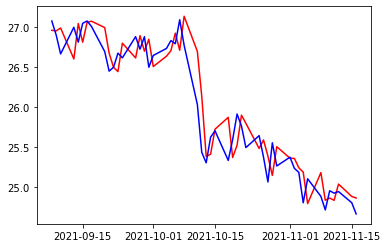

In [4]:
Y_test=Y_t.iloc[675:725]
Y_test=pd.DataFrame(Y_test)
predds_1=pd.DataFrame(predds, index=Y_test.index)
predds_1
plt.plot(predds_1, color='red')
plt.plot(Y_test, color='blue')

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  726
Model:               SARIMAX(6, 1, 2)   Log Likelihood                -412.859
Date:                Thu, 25 Nov 2021   AIC                            843.718
Time:                        12:34:50   BIC                            884.994
Sample:                             0   HQIC                           859.648
                                - 726                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3970      0.106    -13.231      0.000      -1.604      -1.190
ar.L2         -0.6452      0.109     -5.916      0.000      -0.859      -0.431
ar.L3         -0.0691      0.048     -1.439      0.1

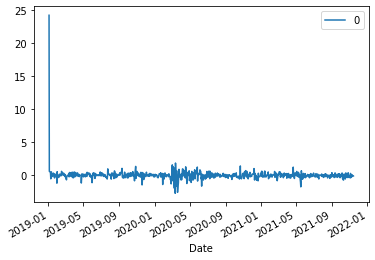

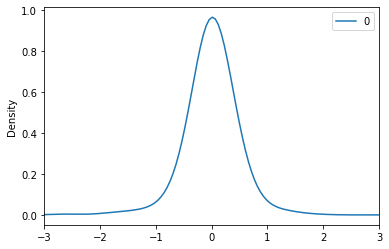

                0
count  724.000000
mean     0.034587
std      0.997456
min     -2.698864
25%     -0.180662
50%      0.023032
75%      0.216027
max     24.241262


In [5]:
arima_residuals = arima_model_fit.resid
print(model.summary())
residuals = pd.DataFrame(arima_residuals)
residuals.plot()
residuals.plot(kind='kde', xlim=(-3,3))
plt.show()
print(residuals.describe())

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3946      0.106    -13.144      0.000      -1.603      -1.187
ar.L2         -0.6422      0.110     -5.865      0.000      -0.857      -0.428
ar.L3         -0.0690      0.048     -1.435      0.151      -0.163       0.025
ar.L4         -0.2155      0.046     -4.699      0.000      -0.305      -0.126
ar.L5         -0.2490      0.046     -5.404      0.000      -0.339      -0.159
ar.L6         -0.1859      0.032     -5.793      0.000      -0.249      -0.123
ma.L1          1.3236      0.108     12.303      0.000       1.113       1.535
ma.L2          0.5731      0.095      6.025      0.000       0.387       0.760
sigma2         0.1832      0.006     32.606      0.000       0.172       0.194


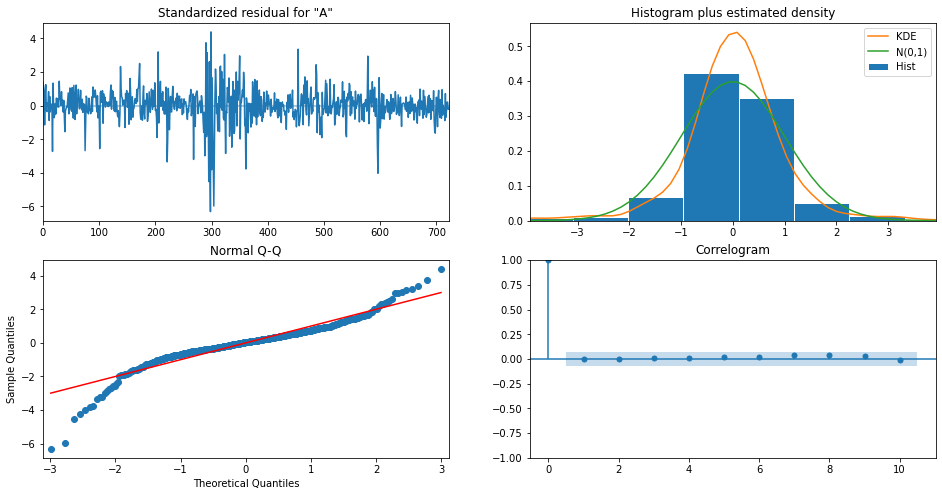

In [6]:

print(arima_model_fit.summary().tables[1])
arima_model_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

In [7]:
stock = web.get_data_yahoo("T",
start = "2019-01-01",
end = "2021-11-17")
y=stock['Adj Close']

Y_t=y.T
Y_t=Y_t.iloc[1:727]
Y_train=Y_t

model = pm.auto_arima(Y_train, start_p=3, start_q=3,start_d=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=6, max_q=6, max_d=2, # maximum p and q
                      m=1,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      #start_P=0, 
                      #D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

#ARIMA model
Errors_000=[]
predds=list()
n=675
for i in range(0,50):
    Y_train=Y_t.iloc[:n+i]
    Y_test=Y_t.iloc[n+i:n+1+i]
    
    arima_model = ARIMA(Y_train, order=model.order)
    arima_model_fit = arima_model.fit()
    preds_arima= arima_model_fit.forecast(len(Y_test),alpha=0.3)
    preds_arima=np.array(preds_arima)
    preds_atempt_1=preds_arima
    preds = pd.Series(preds_arima, index=Y_test.index)
    
    mse = mean_squared_error(Y_test, preds)
    rmse = sqrt(mean_squared_error(Y_test, preds))
    mae = mean_absolute_error(Y_test, preds)
    mape=MAPE(Y_test, preds)
    predds.append(preds_atempt_1)

    Error_i = ([mse, rmse, mae, mape])
    Errors_000.append(Error_i)
    Errors_A=pd.DataFrame(Errors_000)




#Garch model   
Errors_001=[]

for i in range(0,50):
    Y_train=Y_t.iloc[:n+i]
    Y_test=Y_t.iloc[n+i:n+1+i]

    garch = arch_model(Y_train, vol="Garch", p=1, q=1, dist="gaussian")
    garch_fitted = garch.fit()
    garch_forecast = garch_fitted.forecast(horizon=1)
    garch_pred_mean = garch_forecast.mean['h.1'].iloc[-1]
    preds = pd.DataFrame([garch_pred_mean])

    mse = mean_squared_error(Y_test, preds)
    rmse = sqrt(mean_squared_error(Y_test, preds))
    mae = mean_absolute_error(Y_test, preds)
    mape=MAPE(Y_test, preds)
    Error_i = ([mse, rmse, mae, mape])
    Errors_001.append(Error_i)
    Errors_B=pd.DataFrame(Errors_001)

    
#ARIMA-GARCH model  
Errors_002=[]
predds_0=list()
for i in range(0,50):
    Y_train=Y_t.iloc[:n+i]
    Y_test=Y_t.iloc[n+i:n+1+i]
    
    arima_model = ARIMA(Y_train, order=(model.order))
    arima_model_fit = arima_model.fit()
    arima_residuals = arima_model_fit.resid
    predicted_mu = arima_model_fit.forecast(len(Y_test))
    garch = arch_model(arima_residuals, vol="Garch", p=1, q=1, dist="gaussian")
    garch_fitted = garch.fit()
    garch_forecast = garch_fitted.forecast(horizon=1)
    garch_pred_mean = garch_forecast.mean['h.1'].iloc[-1]
    garch_pred_var = garch_forecast.variance['h.1'].iloc[-1]

    # Combine both models' output: yt = mu + et
    preds = predicted_mu + garch_pred_mean
    preds_0=np.array(preds)
    predds_0.append(preds_0)

    mse = mean_squared_error(Y_test, preds)
    rmse = sqrt(mean_squared_error(Y_test, preds))
    mae = mean_absolute_error(Y_test, preds)
    mape=MAPE(Y_test, preds)
    Error_i = ([mse, rmse, mae, mape])
    Errors_002.append(Error_i)
    Errors_C=pd.DataFrame(Errors_002)
    
    
# print(Errors_A[3].mean())
# print(Errors_B[3].mean())
# print(Errors_C[3].mean())

Performing stepwise search to minimize aic
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=860.049, Time=1.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=904.877, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=896.080, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=897.290, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=902.879, Time=0.03 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=896.050, Time=0.90 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=877.467, Time=0.56 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=854.537, Time=1.25 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=859.919, Time=0.64 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=854.464, Time=1.32 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=861.776, Time=1.03 sec
 ARIMA(6,1,3)(0,0,0)[0] intercept   : AIC=854.471, Time=1.62 sec
 ARIMA(5,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=1.57 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=839.176, Time=1.45 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=856.709, 

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sar

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequenc

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequenc

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequenc

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequenc

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequenc

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequenc

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequenc

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequenc

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequenc

Iteration:      1,   Func. Count:      6,   Neg. LLF: 361417186725.8519
Iteration:      2,   Func. Count:     14,   Neg. LLF: 442763682.8597185
Iteration:      3,   Func. Count:     20,   Neg. LLF: 37781517912.55295
Iteration:      4,   Func. Count:     28,   Neg. LLF: 40333.52996266626
Iteration:      5,   Func. Count:     34,   Neg. LLF: 8411.34637853242
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1439.5378670138537
Iteration:      7,   Func. Count:     46,   Neg. LLF: 1215.4115829434552
Iteration:      8,   Func. Count:     52,   Neg. LLF: 1195.2104922554124
Iteration:      9,   Func. Count:     58,   Neg. LLF: 1147.8190487778597
Iteration:     10,   Func. Count:     64,   Neg. LLF: 1224.3993723145818
Iteration:     11,   Func. Count:     70,   Neg. LLF: 1190.8597097559377
Iteration:     12,   Func. Count:     76,   Neg. LLF: 1184.9255676273535
Iteration:     13,   Func. Count:     82,   Neg. LLF: 1153.9461356994293
Iteration:     14,   Func. Count:     88,   Neg. LLF: 118

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      4,   Func. Count:     28,   Neg. LLF: 5133.488532331221
Iteration:      5,   Func. Count:     34,   Neg. LLF: 13174.098763341524
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1912.4764767367578
Iteration:      7,   Func. Count:     46,   Neg. LLF: 1225.4169417159114
Iteration:      8,   Func. Count:     52,   Neg. LLF: 1205.2193790324043
Iteration:      9,   Func. Count:     58,   Neg. LLF: 1153.3256391123819
Iteration:     10,   Func. Count:     64,   Neg. LLF: 1234.938366033896
Iteration:     11,   Func. Count:     70,   Neg. LLF: 1200.9545766944348
Iteration:     12,   Func. Count:     76,   Neg. LLF: 1195.0951116895917
Iteration:     13,   Func. Count:     82,   Neg. LLF: 1154.5514053277707
Iteration:     14,   Func. Count:     88,   Neg. LLF: 1194.7289897218598
Iteration:     15,   Func. Count:     94,   Neg. LLF: 1113.870657077609
Iteration:     16,   Func. Count:     99,   Neg. LLF: 1113.3765818509587
Iteration:     17,   Func. Count:    104,   Neg. LLF: 

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     22,   Func. Count:    130,   Neg. LLF: 1115.917206409025
Iteration:     23,   Func. Count:    134,   Neg. LLF: 1115.917206378535
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1115.917206409025
            Iterations: 23
            Function evaluations: 134
            Gradient evaluations: 23
Iteration:      1,   Func. Count:      6,   Neg. LLF: 5202406635380.301
Iteration:      2,   Func. Count:     14,   Neg. LLF: 426990523.2578497
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1826002479.2667987
Iteration:      4,   Func. Count:     28,   Neg. LLF: 23312.892943729297
Iteration:      5,   Func. Count:     34,   Neg. LLF: 8765.393063183898
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1585.5670910506465
Iteration:      7,   Func. Count:     46,   Neg. LLF: 1233.7954177777578
Iteration:      8,   Func. Count:     52,   Neg. LLF: 1212.3638452931705
Iteration:      9,   Func. Count:     58,   Neg. LLF: 1156.797579

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      8,   Func. Count:     52,   Neg. LLF: 1214.463353374375
Iteration:      9,   Func. Count:     58,   Neg. LLF: 1157.8970557434545
Iteration:     10,   Func. Count:     64,   Neg. LLF: 1227.314924261608
Iteration:     11,   Func. Count:     70,   Neg. LLF: 1205.8490642682548
Iteration:     12,   Func. Count:     76,   Neg. LLF: 1202.9194361206382
Iteration:     13,   Func. Count:     82,   Neg. LLF: 1160.2190868691368
Iteration:     14,   Func. Count:     88,   Neg. LLF: 1203.7400581279817
Iteration:     15,   Func. Count:     94,   Neg. LLF: 1120.9130315773655
Iteration:     16,   Func. Count:     99,   Neg. LLF: 1120.4450120733995
Iteration:     17,   Func. Count:    104,   Neg. LLF: 1120.425498068351
Iteration:     18,   Func. Count:    110,   Neg. LLF: 1120.0977182901984
Iteration:     19,   Func. Count:    115,   Neg. LLF: 1120.0363180243107
Iteration:     20,   Func. Count:    120,   Neg. LLF: 1120.0360353724745
Iteration:     21,   Func. Count:    125,   Neg. LLF: 

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      1,   Func. Count:      6,   Neg. LLF: 5570492289746.546
Iteration:      2,   Func. Count:     14,   Neg. LLF: 421262420.21681416
Iteration:      3,   Func. Count:     20,   Neg. LLF: 509065835995.87823
Iteration:      4,   Func. Count:     28,   Neg. LLF: 33878.448933367115
Iteration:      5,   Func. Count:     34,   Neg. LLF: 28115.794057666273
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1436.5135780557382
Iteration:      7,   Func. Count:     46,   Neg. LLF: 1241.7222675248422
Iteration:      8,   Func. Count:     52,   Neg. LLF: 1219.7767922520115
Iteration:      9,   Func. Count:     58,   Neg. LLF: 1160.7640314349428
Iteration:     10,   Func. Count:     64,   Neg. LLF: 1227.7929401500376
Iteration:     11,   Func. Count:     70,   Neg. LLF: 1210.1757424791112
Iteration:     12,   Func. Count:     76,   Neg. LLF: 1207.2134583125626
Iteration:     13,   Func. Count:     82,   Neg. LLF: 1163.6010639364263
Iteration:     14,   Func. Count:     88,   Neg. LLF

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     14,   Func. Count:     88,   Neg. LLF: 1211.2538986911597
Iteration:     15,   Func. Count:     94,   Neg. LLF: 1127.3561686498163
Iteration:     16,   Func. Count:     99,   Neg. LLF: 1126.9203404390319
Iteration:     17,   Func. Count:    104,   Neg. LLF: 1126.82522221087
Iteration:     18,   Func. Count:    109,   Neg. LLF: 1126.5287943044973
Iteration:     19,   Func. Count:    114,   Neg. LLF: 1126.466722921643
Iteration:     20,   Func. Count:    119,   Neg. LLF: 1126.4600968561274
Iteration:     21,   Func. Count:    124,   Neg. LLF: 1126.4595934642166
Iteration:     22,   Func. Count:    128,   Neg. LLF: 1126.459593463985
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1126.4595934642166
            Iterations: 22
            Function evaluations: 128
            Gradient evaluations: 22
Iteration:      1,   Func. Count:      6,   Neg. LLF: 5792782743705.947
Iteration:      2,   Func. Count:     14,   Neg. LLF: 415176983.

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      2,   Func. Count:     14,   Neg. LLF: 417225267.3989524
Iteration:      3,   Func. Count:     20,   Neg. LLF: 561530144467.3103
Iteration:      4,   Func. Count:     28,   Neg. LLF: 6897.821845220985
Iteration:      5,   Func. Count:     34,   Neg. LLF: 34203.16292055498
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1493.5645815265873
Iteration:      7,   Func. Count:     46,   Neg. LLF: 1256.689854053506
Iteration:      8,   Func. Count:     52,   Neg. LLF: 1233.3634190826833
Iteration:      9,   Func. Count:     58,   Neg. LLF: 1167.901230786561
Iteration:     10,   Func. Count:     64,   Neg. LLF: 1236.647435757893
Iteration:     11,   Func. Count:     70,   Neg. LLF: 1224.2591762086372
Iteration:     12,   Func. Count:     76,   Neg. LLF: 1220.5493526791117
Iteration:     13,   Func. Count:     82,   Neg. LLF: 1170.100701022123
Iteration:     14,   Func. Count:     88,   Neg. LLF: 1211.4254719437913
Iteration:     15,   Func. Count:     94,   Neg. LLF: 1134.

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     16,   Func. Count:     99,   Neg. LLF: 1140.1993364298535
Iteration:     17,   Func. Count:    105,   Neg. LLF: 1139.4224250513062
Iteration:     18,   Func. Count:    110,   Neg. LLF: 1139.075927657207
Iteration:     19,   Func. Count:    115,   Neg. LLF: 1138.9556795821827
Iteration:     20,   Func. Count:    120,   Neg. LLF: 1138.9420980314808
Iteration:     21,   Func. Count:    125,   Neg. LLF: 1138.9410797061719
Iteration:     22,   Func. Count:    130,   Neg. LLF: 1138.9410761099177
Iteration:     23,   Func. Count:    134,   Neg. LLF: 1138.9410760877424
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1138.9410761099177
            Iterations: 23
            Function evaluations: 134
            Gradient evaluations: 23
Iteration:      1,   Func. Count:      6,   Neg. LLF: 6104668739669.518
Iteration:      2,   Func. Count:     14,   Neg. LLF: 418388834.52735543
Iteration:      3,   Func. Count:     20,   Neg. LLF: 4870038

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      2,   Func. Count:     14,   Neg. LLF: 419083798.64125633
Iteration:      3,   Func. Count:     20,   Neg. LLF: 57532250971.8873
Iteration:      4,   Func. Count:     28,   Neg. LLF: 20300.08455701029
Iteration:      5,   Func. Count:     34,   Neg. LLF: 162019.52220987566
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1491.6936969657174
Iteration:      7,   Func. Count:     46,   Neg. LLF: 1264.830300072149
Iteration:      8,   Func. Count:     52,   Neg. LLF: 1247.2454439435867
Iteration:      9,   Func. Count:     58,   Neg. LLF: 1180.7412180042238
Iteration:     10,   Func. Count:     64,   Neg. LLF: 1248.426487462939
Iteration:     11,   Func. Count:     70,   Neg. LLF: 1239.5773130138932
Iteration:     12,   Func. Count:     76,   Neg. LLF: 1235.5478408051627
Iteration:     13,   Func. Count:     82,   Neg. LLF: 1184.3169382871156
Iteration:     14,   Func. Count:     88,   Neg. LLF: 1193.6340322222713
Iteration:     15,   Func. Count:     94,   Neg. LLF: 11

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      2,   Func. Count:     14,   Neg. LLF: 420177168.560796
Iteration:      3,   Func. Count:     20,   Neg. LLF: 5569258017.812252
Iteration:      4,   Func. Count:     28,   Neg. LLF: 87030.53038007702
Iteration:      5,   Func. Count:     34,   Neg. LLF: 36118.1857869508
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1493.153293810166
Iteration:      7,   Func. Count:     46,   Neg. LLF: 1273.3628418526216
Iteration:      8,   Func. Count:     52,   Neg. LLF: 1262.4972122403408
Iteration:      9,   Func. Count:     58,   Neg. LLF: 1194.341706454273
Iteration:     10,   Func. Count:     64,   Neg. LLF: 1260.8576648995545
Iteration:     11,   Func. Count:     70,   Neg. LLF: 1256.2785480418888
Iteration:     12,   Func. Count:     76,   Neg. LLF: 1249.8842589190426
Iteration:     13,   Func. Count:     82,   Neg. LLF: 1199.0067216177047
Iteration:     14,   Func. Count:     88,   Neg. LLF: 1196.7991194283243
Iteration:     15,   Func. Count:     94,   Neg. LLF: 1162.

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     16,   Func. Count:     99,   Neg. LLF: 1168.7659588023157
Iteration:     17,   Func. Count:    104,   Neg. LLF: 1168.1421081528306
Iteration:     18,   Func. Count:    109,   Neg. LLF: 1167.8360539672358
Iteration:     19,   Func. Count:    114,   Neg. LLF: 1167.7695056611906
Iteration:     20,   Func. Count:    119,   Neg. LLF: 1167.7595644832845
Iteration:     21,   Func. Count:    124,   Neg. LLF: 1167.7593512793565
Iteration:     22,   Func. Count:    129,   Neg. LLF: 1167.7593425948364
Iteration:     23,   Func. Count:    133,   Neg. LLF: 1167.759342574032
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1167.7593425948364
            Iterations: 23
            Function evaluations: 133
            Gradient evaluations: 23
Iteration:      1,   Func. Count:      6,   Neg. LLF: 6730034314442.638
Iteration:      2,   Func. Count:     14,   Neg. LLF: 420216587.9404877
Iteration:      3,   Func. Count:     20,   Neg. LLF: 54346239

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      2,   Func. Count:     14,   Neg. LLF: 420048724.1211666
Iteration:      3,   Func. Count:     20,   Neg. LLF: 657617892341.1141
Iteration:      4,   Func. Count:     28,   Neg. LLF: 9517.27579856656
Iteration:      5,   Func. Count:     34,   Neg. LLF: 13758.157661212508
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1502.974446077951
Iteration:      7,   Func. Count:     46,   Neg. LLF: 1284.6770841550974
Iteration:      8,   Func. Count:     52,   Neg. LLF: 1280.7631752725365
Iteration:      9,   Func. Count:     58,   Neg. LLF: 1208.9612836691372
Iteration:     10,   Func. Count:     64,   Neg. LLF: 1274.988122431657
Iteration:     11,   Func. Count:     70,   Neg. LLF: 1275.7189740630033
Iteration:     12,   Func. Count:     76,   Neg. LLF: 1259.4329452813708
Iteration:     13,   Func. Count:     82,   Neg. LLF: 1214.5276011836204
Iteration:     14,   Func. Count:     88,   Neg. LLF: 1206.354088818584
Iteration:     15,   Func. Count:     94,   Neg. LLF: 1178

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     18,   Func. Count:    109,   Neg. LLF: 1183.7962233449143
Iteration:     19,   Func. Count:    114,   Neg. LLF: 1183.7489600799377
Iteration:     20,   Func. Count:    119,   Neg. LLF: 1183.745285478513
Iteration:     21,   Func. Count:    124,   Neg. LLF: 1183.745220053006
Iteration:     22,   Func. Count:    129,   Neg. LLF: 1183.7452191734446
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1183.7452191734446
            Iterations: 22
            Function evaluations: 129
            Gradient evaluations: 22


C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 345732020.1790607
Iteration:      2,   Func. Count:     15,   Neg. LLF: 33538342.86725405
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1809.6293105450122
Iteration:      4,   Func. Count:     28,   Neg. LLF: 349.80349344164193
Iteration:      5,   Func. Count:     35,   Neg. LLF: 760.4978875995291
Iteration:      6,   Func. Count:     41,   Neg. LLF: 330.57183938279644
Iteration:      7,   Func. Count:     46,   Neg. LLF: 330.1177867392329
Iteration:      8,   Func. Count:     51,   Neg. LLF: 329.8766600550357
Iteration:      9,   Func. Count:     56,   Neg. LLF: 329.8691879498095
Iteration:     10,   Func. Count:     61,   Neg. LLF: 329.8678387092339
Iteration:     11,   Func. Count:     66,   Neg. LLF: 329.867778133127
Iteration:     12,   Func. Count:     71,   Neg. LLF: 329.8677709049962
Iteration:     13,   Func. Count:     75,   Neg. LLF: 329.8677709049847
Optimization terminated successfully    (Exit mode 0)
        

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 26827172643152.93
Iteration:      2,   Func. Count:     15,   Neg. LLF: 29649391.501461305
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1827.4018204522351
Iteration:      4,   Func. Count:     28,   Neg. LLF: 385.41211397618986
Iteration:      5,   Func. Count:     34,   Neg. LLF: 781.8994468920243
Iteration:      6,   Func. Count:     40,   Neg. LLF: 330.13298410780857
Iteration:      7,   Func. Count:     45,   Neg. LLF: 329.84628677925633
Iteration:      8,   Func. Count:     50,   Neg. LLF: 329.60099415342796
Iteration:      9,   Func. Count:     55,   Neg. LLF: 329.57641045114224
Iteration:     10,   Func. Count:     60,   Neg. LLF: 329.5755469347099
Iteration:     11,   Func. Count:     65,   Neg. LLF: 329.57553806157335
Iteration:     12,   Func. Count:     69,   Neg. LLF: 329.5755380615109
Optimization terminated successfully    (Exit mode 0)
            Current function value: 329.57553806157335
            Iterati

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 6528971451.584642
Iteration:      2,   Func. Count:     15,   Neg. LLF: 55965991.29900212
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1821.4919061675712
Iteration:      4,   Func. Count:     28,   Neg. LLF: 389.58322663618685
Iteration:      5,   Func. Count:     34,   Neg. LLF: 712.3034590735161
Iteration:      6,   Func. Count:     40,   Neg. LLF: 332.1873717979794
Iteration:      7,   Func. Count:     45,   Neg. LLF: 331.88084278991187
Iteration:      8,   Func. Count:     50,   Neg. LLF: 331.73963207599
Iteration:      9,   Func. Count:     55,   Neg. LLF: 331.72757433987647
Iteration:     10,   Func. Count:     60,   Neg. LLF: 331.72749123269796
Iteration:     11,   Func. Count:     64,   Neg. LLF: 331.7274912324916
Optimization terminated successfully    (Exit mode 0)
            Current function value: 331.72749123269796
            Iterations: 11
            Function evaluations: 64
            Gradient evaluations

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 27984049330426.78
Iteration:      2,   Func. Count:     15,   Neg. LLF: 23214695.266830906
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1827.0856896843445
Iteration:      4,   Func. Count:     28,   Neg. LLF: 368.1035110882106
Iteration:      5,   Func. Count:     35,   Neg. LLF: 681.7205210427024
Iteration:      6,   Func. Count:     41,   Neg. LLF: 330.5969670061737
Iteration:      7,   Func. Count:     46,   Neg. LLF: 330.1661992052329
Iteration:      8,   Func. Count:     51,   Neg. LLF: 329.93093066047953
Iteration:      9,   Func. Count:     56,   Neg. LLF: 329.9205248522376
Iteration:     10,   Func. Count:     61,   Neg. LLF: 329.91981999961644
Iteration:     11,   Func. Count:     66,   Neg. LLF: 329.91960154104413
Iteration:     12,   Func. Count:     71,   Neg. LLF: 329.91958976897786
Iteration:     13,   Func. Count:     75,   Neg. LLF: 329.9195897685535
Optimization terminated successfully    (Exit mode 0)
    

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1521168108.5315342
Iteration:      2,   Func. Count:     15,   Neg. LLF: 27131613.872903526
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1840.716118646458
Iteration:      4,   Func. Count:     28,   Neg. LLF: 423.14568703981956
Iteration:      5,   Func. Count:     34,   Neg. LLF: 714.3072466607797
Iteration:      6,   Func. Count:     40,   Neg. LLF: 332.49486286856745
Iteration:      7,   Func. Count:     45,   Neg. LLF: 332.0993361295445
Iteration:      8,   Func. Count:     50,   Neg. LLF: 331.9219047850978
Iteration:      9,   Func. Count:     55,   Neg. LLF: 331.9176951731505
Iteration:     10,   Func. Count:     60,   Neg. LLF: 331.9176096460491
Iteration:     11,   Func. Count:     65,   Neg. LLF: 331.91760709917236
Iteration:     12,   Func. Count:     69,   Neg. LLF: 331.9176070990677
Optimization terminated successfully    (Exit mode 0)
            Current function value: 331.91760709917236
            Iterations

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 26883057176492.035
Iteration:      2,   Func. Count:     15,   Neg. LLF: 33105782.409178164
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1828.160872885206
Iteration:      4,   Func. Count:     28,   Neg. LLF: 414.8946620336163
Iteration:      5,   Func. Count:     34,   Neg. LLF: 685.7628125949461
Iteration:      6,   Func. Count:     40,   Neg. LLF: 332.71345856142733
Iteration:      7,   Func. Count:     45,   Neg. LLF: 332.39602362067046
Iteration:      8,   Func. Count:     50,   Neg. LLF: 332.2336258388789
Iteration:      9,   Func. Count:     55,   Neg. LLF: 332.2307106319612
Iteration:     10,   Func. Count:     60,   Neg. LLF: 332.230651309114
Iteration:     11,   Func. Count:     65,   Neg. LLF: 332.23065030149945
Iteration:     12,   Func. Count:     69,   Neg. LLF: 332.23065030146927
Optimization terminated successfully    (Exit mode 0)
            Current function value: 332.23065030149945
            Iterations

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 767702966.6363399
Iteration:      2,   Func. Count:     15,   Neg. LLF: 335913154.14589506
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1822.680143883975
Iteration:      4,   Func. Count:     28,   Neg. LLF: 360.9713645753968
Iteration:      5,   Func. Count:     35,   Neg. LLF: 685.8060878455376
Iteration:      6,   Func. Count:     41,   Neg. LLF: 332.3970390437163
Iteration:      7,   Func. Count:     46,   Neg. LLF: 331.9371616816346
Iteration:      8,   Func. Count:     51,   Neg. LLF: 331.66377899849107
Iteration:      9,   Func. Count:     56,   Neg. LLF: 331.643066013517
Iteration:     10,   Func. Count:     61,   Neg. LLF: 331.6354202575726
Iteration:     11,   Func. Count:     66,   Neg. LLF: 331.6353328788124
Iteration:     12,   Func. Count:     71,   Neg. LLF: 331.63531324945916
Iteration:     13,   Func. Count:     75,   Neg. LLF: 331.63531324942437
Optimization terminated successfully    (Exit mode 0)
       

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 27864041909098.625
Iteration:      2,   Func. Count:     15,   Neg. LLF: 336379683.41226304
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1832.0982038297498
Iteration:      4,   Func. Count:     28,   Neg. LLF: 375.8930711919608
Iteration:      5,   Func. Count:     35,   Neg. LLF: 663.4017303584732
Iteration:      6,   Func. Count:     41,   Neg. LLF: 332.01265696876004
Iteration:      7,   Func. Count:     46,   Neg. LLF: 331.5716258720416
Iteration:      8,   Func. Count:     51,   Neg. LLF: 331.30802342482286
Iteration:      9,   Func. Count:     56,   Neg. LLF: 331.30163487302593
Iteration:     10,   Func. Count:     61,   Neg. LLF: 331.30031682162377
Iteration:     11,   Func. Count:     66,   Neg. LLF: 331.30026929752967
Iteration:     12,   Func. Count:     71,   Neg. LLF: 331.30026175970363
Iteration:     13,   Func. Count:     75,   Neg. LLF: 331.30026175972887
Optimization terminated successfully    (Exit mode 0)


C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1700636256.5491424
Iteration:      2,   Func. Count:     15,   Neg. LLF: 336502848.0244533
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1835.6573037734738
Iteration:      4,   Func. Count:     28,   Neg. LLF: 363.2402872732728
Iteration:      5,   Func. Count:     35,   Neg. LLF: 689.190394503187
Iteration:      6,   Func. Count:     41,   Neg. LLF: 330.8268847993812
Iteration:      7,   Func. Count:     46,   Neg. LLF: 330.3241395425455
Iteration:      8,   Func. Count:     51,   Neg. LLF: 330.04515557003407
Iteration:      9,   Func. Count:     56,   Neg. LLF: 330.02961878055896
Iteration:     10,   Func. Count:     61,   Neg. LLF: 330.0285352406688
Iteration:     11,   Func. Count:     66,   Neg. LLF: 330.02848132445484
Iteration:     12,   Func. Count:     71,   Neg. LLF: 330.0284746864024
Iteration:     13,   Func. Count:     75,   Neg. LLF: 330.02847468585173
Optimization terminated successfully    (Exit mode 0)
     

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1787599888.8866153
Iteration:      2,   Func. Count:     15,   Neg. LLF: 31375037.68508381
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1841.467607386206
Iteration:      4,   Func. Count:     28,   Neg. LLF: 436.6459670218794
Iteration:      5,   Func. Count:     34,   Neg. LLF: 659.6998592303678
Iteration:      6,   Func. Count:     40,   Neg. LLF: 333.62911447366764
Iteration:      7,   Func. Count:     45,   Neg. LLF: 333.29299980955375
Iteration:      8,   Func. Count:     50,   Neg. LLF: 333.16739424098546
Iteration:      9,   Func. Count:     55,   Neg. LLF: 333.16614057365655
Iteration:     10,   Func. Count:     61,   Neg. LLF: 333.1579079284092
Iteration:     11,   Func. Count:     66,   Neg. LLF: 333.15789897385196
Iteration:     12,   Func. Count:     70,   Neg. LLF: 333.1578989736376
Optimization terminated successfully    (Exit mode 0)
            Current function value: 333.15789897385196
            Iteration

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 569497274.2629433
Iteration:      2,   Func. Count:     15,   Neg. LLF: 338196678.9316603
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1842.9926173988592
Iteration:      4,   Func. Count:     28,   Neg. LLF: 435.71308374113244
Iteration:      5,   Func. Count:     34,   Neg. LLF: 667.9799437988579
Iteration:      6,   Func. Count:     40,   Neg. LLF: 333.48106300202596
Iteration:      7,   Func. Count:     45,   Neg. LLF: 333.1199333650186
Iteration:      8,   Func. Count:     50,   Neg. LLF: 332.99871438800915
Iteration:      9,   Func. Count:     55,   Neg. LLF: 332.9823432976054
Iteration:     10,   Func. Count:     60,   Neg. LLF: 332.97836451129785
Iteration:     11,   Func. Count:     65,   Neg. LLF: 332.97836266657487
Iteration:     12,   Func. Count:     69,   Neg. LLF: 332.9783626663554
Optimization terminated successfully    (Exit mode 0)
            Current function value: 332.97836266657487
            Iteration

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 7747726577.652119
Iteration:      2,   Func. Count:     15,   Neg. LLF: 338042783.4176458
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1854.6233436694697
Iteration:      4,   Func. Count:     28,   Neg. LLF: 428.5967147326573
Iteration:      5,   Func. Count:     34,   Neg. LLF: 688.4242511349584
Iteration:      6,   Func. Count:     40,   Neg. LLF: 332.4197332425024
Iteration:      7,   Func. Count:     45,   Neg. LLF: 332.0509021125934
Iteration:      8,   Func. Count:     50,   Neg. LLF: 331.91737962110795
Iteration:      9,   Func. Count:     55,   Neg. LLF: 331.8960750070761
Iteration:     10,   Func. Count:     60,   Neg. LLF: 331.89530795105054
Iteration:     11,   Func. Count:     65,   Neg. LLF: 331.89530324436487
Iteration:     12,   Func. Count:     69,   Neg. LLF: 331.89530324398527
Optimization terminated successfully    (Exit mode 0)
            Current function value: 331.89530324436487
            Iterations

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2003185415.3908806
Iteration:      2,   Func. Count:     15,   Neg. LLF: 337545761.2226766
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1839.892867266571
Iteration:      4,   Func. Count:     28,   Neg. LLF: 360.4215734411798
Iteration:      5,   Func. Count:     35,   Neg. LLF: 695.259458852264
Iteration:      6,   Func. Count:     41,   Neg. LLF: 332.45862302778227
Iteration:      7,   Func. Count:     46,   Neg. LLF: 332.0942446409191
Iteration:      8,   Func. Count:     51,   Neg. LLF: 332.3977105855972
Iteration:      9,   Func. Count:     57,   Neg. LLF: 331.6533338020341
Iteration:     10,   Func. Count:     62,   Neg. LLF: 331.6475984048277
Iteration:     11,   Func. Count:     67,   Neg. LLF: 331.64753299125175
Iteration:     12,   Func. Count:     72,   Neg. LLF: 331.647524497259
Iteration:     13,   Func. Count:     77,   Neg. LLF: 331.64752386646916
Optimization terminated successfully    (Exit mode 0)
        

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 30772148543644.59
Iteration:      2,   Func. Count:     15,   Neg. LLF: 337879504.89288497
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1850.0081895743597
Iteration:      4,   Func. Count:     28,   Neg. LLF: 360.89473349094203
Iteration:      5,   Func. Count:     35,   Neg. LLF: 703.1080958208638
Iteration:      6,   Func. Count:     41,   Neg. LLF: 330.316013050916
Iteration:      7,   Func. Count:     46,   Neg. LLF: 329.8290792241486
Iteration:      8,   Func. Count:     51,   Neg. LLF: 329.5267440605228
Iteration:      9,   Func. Count:     56,   Neg. LLF: 329.50005056350096
Iteration:     10,   Func. Count:     61,   Neg. LLF: 329.48943359311147
Iteration:     11,   Func. Count:     66,   Neg. LLF: 329.4890191324952
Iteration:     12,   Func. Count:     71,   Neg. LLF: 329.48893600934775
Iteration:     13,   Func. Count:     75,   Neg. LLF: 329.48893600911913
Optimization terminated successfully    (Exit mode 0)
    

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 574204308.9148651
Iteration:      2,   Func. Count:     15,   Neg. LLF: 84572496.79668601
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1858.1385663990127
Iteration:      4,   Func. Count:     28,   Neg. LLF: 430.0720947153625
Iteration:      5,   Func. Count:     34,   Neg. LLF: 665.9810197729007
Iteration:      6,   Func. Count:     40,   Neg. LLF: 333.08718679161984
Iteration:      7,   Func. Count:     45,   Neg. LLF: 332.6973483531551
Iteration:      8,   Func. Count:     50,   Neg. LLF: 332.58029047384093
Iteration:      9,   Func. Count:     55,   Neg. LLF: 332.54007102803223
Iteration:     10,   Func. Count:     60,   Neg. LLF: 332.539890208102
Iteration:     11,   Func. Count:     64,   Neg. LLF: 332.5398902077858
Optimization terminated successfully    (Exit mode 0)
            Current function value: 332.539890208102
            Iterations: 11
            Function evaluations: 64
            Gradient evaluations: 

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 429685868.2268129
Iteration:      2,   Func. Count:     15,   Neg. LLF: 339599340.43276024
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1862.923786663836
Iteration:      4,   Func. Count:     28,   Neg. LLF: 428.52913620957844
Iteration:      5,   Func. Count:     34,   Neg. LLF: 659.7278226439537
Iteration:      6,   Func. Count:     40,   Neg. LLF: 332.4053342295268
Iteration:      7,   Func. Count:     45,   Neg. LLF: 332.03534495307986
Iteration:      8,   Func. Count:     50,   Neg. LLF: 331.90916482282125
Iteration:      9,   Func. Count:     55,   Neg. LLF: 331.88852633055666
Iteration:     10,   Func. Count:     60,   Neg. LLF: 331.8810455596583
Iteration:     11,   Func. Count:     65,   Neg. LLF: 331.8810375338626
Iteration:     12,   Func. Count:     70,   Neg. LLF: 331.88103697890364
Optimization terminated successfully    (Exit mode 0)
            Current function value: 331.88103697890364
            Iteration

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1708008993.7723036
Iteration:      2,   Func. Count:     15,   Neg. LLF: 339361129.6724423
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1861.9462237698935
Iteration:      4,   Func. Count:     28,   Neg. LLF: 435.47959650445694
Iteration:      5,   Func. Count:     34,   Neg. LLF: 664.2597096448735
Iteration:      6,   Func. Count:     40,   Neg. LLF: 334.4672975520033
Iteration:      7,   Func. Count:     45,   Neg. LLF: 334.09850841288437
Iteration:      8,   Func. Count:     50,   Neg. LLF: 333.97225515003373
Iteration:      9,   Func. Count:     55,   Neg. LLF: 333.94984011162325
Iteration:     10,   Func. Count:     60,   Neg. LLF: 333.94847004560006
Iteration:     11,   Func. Count:     65,   Neg. LLF: 333.94846937319994
Optimization terminated successfully    (Exit mode 0)
            Current function value: 333.94846937319994
            Iterations: 11
            Function evaluations: 65
            Gradient evalua

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 31911332920154.93
Iteration:      2,   Func. Count:     15,   Neg. LLF: 19773376.23849688
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1862.3657570662833
Iteration:      4,   Func. Count:     28,   Neg. LLF: 378.39394416573674
Iteration:      5,   Func. Count:     35,   Neg. LLF: 669.9979573287143
Iteration:      6,   Func. Count:     41,   Neg. LLF: 331.134605489277
Iteration:      7,   Func. Count:     46,   Neg. LLF: 330.6591841030123
Iteration:      8,   Func. Count:     51,   Neg. LLF: 330.355195133062
Iteration:      9,   Func. Count:     56,   Neg. LLF: 330.32397150183124
Iteration:     10,   Func. Count:     61,   Neg. LLF: 330.31236060970593
Iteration:     11,   Func. Count:     66,   Neg. LLF: 330.3118919055062
Iteration:     12,   Func. Count:     71,   Neg. LLF: 330.311798645448
Iteration:     13,   Func. Count:     75,   Neg. LLF: 330.311798645197
Optimization terminated successfully    (Exit mode 0)
          

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 32590861955678.492
Iteration:      2,   Func. Count:     15,   Neg. LLF: 176073163.25129327
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1855.6835350626498
Iteration:      4,   Func. Count:     28,   Neg. LLF: 352.48154014458987
Iteration:      5,   Func. Count:     35,   Neg. LLF: 739.1788542098689
Iteration:      6,   Func. Count:     42,   Neg. LLF: 330.95557112350684
Iteration:      7,   Func. Count:     47,   Neg. LLF: 330.71586292513894
Iteration:      8,   Func. Count:     52,   Neg. LLF: 331.1017563880871
Iteration:      9,   Func. Count:     58,   Neg. LLF: 330.0588830116849
Iteration:     10,   Func. Count:     63,   Neg. LLF: 329.9936140819698
Iteration:     11,   Func. Count:     68,   Neg. LLF: 329.9889077382506
Iteration:     12,   Func. Count:     73,   Neg. LLF: 329.98884794668254
Iteration:     13,   Func. Count:     78,   Neg. LLF: 329.9888386010424
Iteration:     14,   Func. Count:     83,   Neg. LLF: 329

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 321637030.1759591
Iteration:      2,   Func. Count:     15,   Neg. LLF: 13087551.384315925
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1868.712353811554
Iteration:      4,   Func. Count:     28,   Neg. LLF: 434.12099340325074
Iteration:      5,   Func. Count:     34,   Neg. LLF: 658.8643034751811
Iteration:      6,   Func. Count:     40,   Neg. LLF: 332.81801602093435
Iteration:      7,   Func. Count:     45,   Neg. LLF: 332.4555942524041
Iteration:      8,   Func. Count:     50,   Neg. LLF: 332.30802736458867
Iteration:      9,   Func. Count:     55,   Neg. LLF: 332.2801645183479
Iteration:     10,   Func. Count:     60,   Neg. LLF: 332.27874971643837
Iteration:     11,   Func. Count:     65,   Neg. LLF: 332.2787415653409
Iteration:     12,   Func. Count:     70,   Neg. LLF: 332.27874093771175
Optimization terminated successfully    (Exit mode 0)
            Current function value: 332.27874093771175
            Iteration

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 370753887.8911576
Iteration:      2,   Func. Count:     15,   Neg. LLF: 26351057.3011498
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1870.1440792896497
Iteration:      4,   Func. Count:     28,   Neg. LLF: 391.3471329186124
Iteration:      5,   Func. Count:     35,   Neg. LLF: 671.7429889904245
Iteration:      6,   Func. Count:     41,   Neg. LLF: 331.8358726042176
Iteration:      7,   Func. Count:     46,   Neg. LLF: 331.3458787444154
Iteration:      8,   Func. Count:     51,   Neg. LLF: 331.03513716963676
Iteration:      9,   Func. Count:     56,   Neg. LLF: 330.99178705729673
Iteration:     10,   Func. Count:     61,   Neg. LLF: 330.9859612512496
Iteration:     11,   Func. Count:     66,   Neg. LLF: 330.9853693524896
Iteration:     12,   Func. Count:     71,   Neg. LLF: 330.98529691865247
Iteration:     13,   Func. Count:     75,   Neg. LLF: 330.98529691809983
Optimization terminated successfully    (Exit mode 0)
      

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 32713791722312.4
Iteration:      2,   Func. Count:     15,   Neg. LLF: 17697080.729866583
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1866.1522529775316
Iteration:      4,   Func. Count:     28,   Neg. LLF: 352.2426732565143
Iteration:      5,   Func. Count:     35,   Neg. LLF: 734.4359501198605
Iteration:      6,   Func. Count:     42,   Neg. LLF: 330.03692265410615
Iteration:      7,   Func. Count:     47,   Neg. LLF: 329.73147958177606
Iteration:      8,   Func. Count:     52,   Neg. LLF: 341.2831208439328
Iteration:      9,   Func. Count:     58,   Neg. LLF: 329.1138213072958
Iteration:     10,   Func. Count:     63,   Neg. LLF: 329.02010293304306
Iteration:     11,   Func. Count:     68,   Neg. LLF: 329.00845002379424
Iteration:     12,   Func. Count:     73,   Neg. LLF: 329.00520484925744
Iteration:     13,   Func. Count:     78,   Neg. LLF: 329.0050732075673
Iteration:     14,   Func. Count:     83,   Neg. LLF: 329.

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 893753890.1303805
Iteration:      2,   Func. Count:     15,   Neg. LLF: 342919592.90854585
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1877.5321179366256
Iteration:      4,   Func. Count:     28,   Neg. LLF: 396.4978172032013
Iteration:      5,   Func. Count:     35,   Neg. LLF: 666.9065139633526
Iteration:      6,   Func. Count:     41,   Neg. LLF: 331.22043989143606
Iteration:      7,   Func. Count:     46,   Neg. LLF: 330.7400242464379
Iteration:      8,   Func. Count:     51,   Neg. LLF: 330.42062457175876
Iteration:      9,   Func. Count:     56,   Neg. LLF: 330.389001590474
Iteration:     10,   Func. Count:     61,   Neg. LLF: 330.37314096301463
Iteration:     11,   Func. Count:     66,   Neg. LLF: 330.37271732601755
Iteration:     12,   Func. Count:     71,   Neg. LLF: 330.37261060286124
Iteration:     13,   Func. Count:     75,   Neg. LLF: 330.37261060271686
Optimization terminated successfully    (Exit mode 0)
   

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 6491099855.63888
Iteration:      2,   Func. Count:     15,   Neg. LLF: 343936305.3661888
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1883.6344827168998
Iteration:      4,   Func. Count:     28,   Neg. LLF: 371.4222783563895
Iteration:      5,   Func. Count:     35,   Neg. LLF: 685.1674153266124
Iteration:      6,   Func. Count:     41,   Neg. LLF: 329.5126629339197
Iteration:      7,   Func. Count:     46,   Neg. LLF: 328.97029899575455
Iteration:      8,   Func. Count:     51,   Neg. LLF: 328.59040324342084
Iteration:      9,   Func. Count:     56,   Neg. LLF: 328.53101624060366
Iteration:     10,   Func. Count:     61,   Neg. LLF: 328.52660096270057
Iteration:     11,   Func. Count:     66,   Neg. LLF: 328.5254221583606
Iteration:     12,   Func. Count:     71,   Neg. LLF: 328.5254140133612
Iteration:     13,   Func. Count:     75,   Neg. LLF: 328.52541401325885
Optimization terminated successfully    (Exit mode 0)
     

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 4150871118.9148335
Iteration:      2,   Func. Count:     15,   Neg. LLF: 11443426.330407154
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1886.060940241563
Iteration:      4,   Func. Count:     28,   Neg. LLF: 438.8506480783711
Iteration:      5,   Func. Count:     34,   Neg. LLF: 676.0568133592216
Iteration:      6,   Func. Count:     40,   Neg. LLF: 333.1565683254182
Iteration:      7,   Func. Count:     45,   Neg. LLF: 332.74442228671353
Iteration:      8,   Func. Count:     50,   Neg. LLF: 332.5869233987761
Iteration:      9,   Func. Count:     55,   Neg. LLF: 332.5806005784928
Iteration:     10,   Func. Count:     60,   Neg. LLF: 332.5802299473031
Iteration:     11,   Func. Count:     65,   Neg. LLF: 332.57976911648547
Iteration:     12,   Func. Count:     69,   Neg. LLF: 332.57976911623246
Optimization terminated successfully    (Exit mode 0)
            Current function value: 332.57976911648547
            Iterations

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 356127498.2782326
Iteration:      2,   Func. Count:     15,   Neg. LLF: 352367552.2550587
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1874.5972644756355
Iteration:      4,   Func. Count:     28,   Neg. LLF: 364.2385162824095
Iteration:      5,   Func. Count:     35,   Neg. LLF: 695.4428584679229
Iteration:      6,   Func. Count:     42,   Neg. LLF: 331.9212442660416
Iteration:      7,   Func. Count:     47,   Neg. LLF: 331.4106507603393
Iteration:      8,   Func. Count:     52,   Neg. LLF: 331.30315429055327
Iteration:      9,   Func. Count:     57,   Neg. LLF: 331.00801066808765
Iteration:     10,   Func. Count:     62,   Neg. LLF: 330.98570452085437
Iteration:     11,   Func. Count:     67,   Neg. LLF: 330.97986084102916
Iteration:     12,   Func. Count:     72,   Neg. LLF: 330.9795466823524
Iteration:     13,   Func. Count:     77,   Neg. LLF: 330.979544832287
Iteration:     14,   Func. Count:     81,   Neg. LLF: 330.97

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 30687362069696.65
Iteration:      2,   Func. Count:     15,   Neg. LLF: 19687894.779335886
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1877.8481554701243
Iteration:      4,   Func. Count:     28,   Neg. LLF: 431.50616484061703
Iteration:      5,   Func. Count:     34,   Neg. LLF: 670.4801515390533
Iteration:      6,   Func. Count:     40,   Neg. LLF: 333.37763209907854
Iteration:      7,   Func. Count:     45,   Neg. LLF: 333.03788675558656
Iteration:      8,   Func. Count:     50,   Neg. LLF: 332.88605198760126
Iteration:      9,   Func. Count:     55,   Neg. LLF: 332.8753358151696
Iteration:     10,   Func. Count:     60,   Neg. LLF: 332.8730247944242
Iteration:     11,   Func. Count:     65,   Neg. LLF: 332.8730217709443
Iteration:     12,   Func. Count:     69,   Neg. LLF: 332.8730217706965
Optimization terminated successfully    (Exit mode 0)
            Current function value: 332.8730217709443
            Iterations

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 5052883324.855692
Iteration:      2,   Func. Count:     15,   Neg. LLF: 352896600.3094481
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1883.04799570758
Iteration:      4,   Func. Count:     28,   Neg. LLF: 451.2765213517738
Iteration:      5,   Func. Count:     34,   Neg. LLF: 667.7585456477767
Iteration:      6,   Func. Count:     40,   Neg. LLF: 334.17741655602237
Iteration:      7,   Func. Count:     45,   Neg. LLF: 333.8375231806291
Iteration:      8,   Func. Count:     50,   Neg. LLF: 333.67066573530485
Iteration:      9,   Func. Count:     55,   Neg. LLF: 333.65992877823055
Iteration:     10,   Func. Count:     60,   Neg. LLF: 333.6574629301179
Iteration:     11,   Func. Count:     65,   Neg. LLF: 333.6574458879639
Iteration:     12,   Func. Count:     70,   Neg. LLF: 333.65744451316004
Iteration:     13,   Func. Count:     74,   Neg. LLF: 333.6574445131538
Optimization terminated successfully    (Exit mode 0)
       

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 32833602637496.758
Iteration:      2,   Func. Count:     15,   Neg. LLF: 352790738.84695375
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1882.3125159545157
Iteration:      4,   Func. Count:     28,   Neg. LLF: 433.7236572398606
Iteration:      5,   Func. Count:     34,   Neg. LLF: 668.1207784854917
Iteration:      6,   Func. Count:     40,   Neg. LLF: 334.3713875569798
Iteration:      7,   Func. Count:     45,   Neg. LLF: 334.02157119001845
Iteration:      8,   Func. Count:     50,   Neg. LLF: 333.84693929916796
Iteration:      9,   Func. Count:     55,   Neg. LLF: 333.83579978368414
Iteration:     10,   Func. Count:     60,   Neg. LLF: 333.83445664724366
Iteration:     11,   Func. Count:     65,   Neg. LLF: 333.8344391276684
Iteration:     12,   Func. Count:     70,   Neg. LLF: 333.834438089592
Iteration:     13,   Func. Count:     74,   Neg. LLF: 333.834438089579
Optimization terminated successfully    (Exit mode 0)
     

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 31903342961417.605
Iteration:      2,   Func. Count:     15,   Neg. LLF: 7707809.577650079
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1906.4195610009815
Iteration:      4,   Func. Count:     28,   Neg. LLF: 434.9380129021624
Iteration:      5,   Func. Count:     34,   Neg. LLF: 735.8707331584899
Iteration:      6,   Func. Count:     40,   Neg. LLF: 334.94185738143227
Iteration:      7,   Func. Count:     45,   Neg. LLF: 334.4770163828338
Iteration:      8,   Func. Count:     50,   Neg. LLF: 334.35974187574425
Iteration:      9,   Func. Count:     55,   Neg. LLF: 334.32942249129417
Iteration:     10,   Func. Count:     60,   Neg. LLF: 334.32883259848734
Iteration:     11,   Func. Count:     64,   Neg. LLF: 334.3288325985626
Optimization terminated successfully    (Exit mode 0)
            Current function value: 334.32883259848734
            Iterations: 11
            Function evaluations: 64
            Gradient evaluati

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2847766596.0208893
Iteration:      2,   Func. Count:     15,   Neg. LLF: 354388414.40780437
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1897.4221542869614
Iteration:      4,   Func. Count:     28,   Neg. LLF: 446.66195295700766
Iteration:      5,   Func. Count:     34,   Neg. LLF: 677.8618067813958
Iteration:      6,   Func. Count:     40,   Neg. LLF: 335.07645012618343
Iteration:      7,   Func. Count:     45,   Neg. LLF: 334.6802199958189
Iteration:      8,   Func. Count:     50,   Neg. LLF: 334.5126008113034
Iteration:      9,   Func. Count:     55,   Neg. LLF: 334.5084283301728
Iteration:     10,   Func. Count:     61,   Neg. LLF: 334.49961822872774
Iteration:     11,   Func. Count:     66,   Neg. LLF: 334.4995954286012
Iteration:     12,   Func. Count:     71,   Neg. LLF: 334.49959474984655
Optimization terminated successfully    (Exit mode 0)
            Current function value: 334.49959474984655
            Iteratio

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1130789544.1483543
Iteration:      2,   Func. Count:     15,   Neg. LLF: 356156188.1300649
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1906.1310989947458
Iteration:      4,   Func. Count:     28,   Neg. LLF: 439.01561270945786
Iteration:      5,   Func. Count:     34,   Neg. LLF: 709.5091372514116
Iteration:      6,   Func. Count:     40,   Neg. LLF: 335.4549146407637
Iteration:      7,   Func. Count:     45,   Neg. LLF: 334.9816931052439
Iteration:      8,   Func. Count:     50,   Neg. LLF: 334.8448899677941
Iteration:      9,   Func. Count:     55,   Neg. LLF: 334.83906535228783
Iteration:     10,   Func. Count:     60,   Neg. LLF: 334.838349739083
Iteration:     11,   Func. Count:     65,   Neg. LLF: 334.8378094476144
Iteration:     12,   Func. Count:     69,   Neg. LLF: 334.8378094473336
Optimization terminated successfully    (Exit mode 0)
            Current function value: 334.8378094476144
            Iterations: 1

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 34046940669450.14
Iteration:      2,   Func. Count:     15,   Neg. LLF: 355914001.7039312
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1902.2538747098683
Iteration:      4,   Func. Count:     28,   Neg. LLF: 447.41544010688597
Iteration:      5,   Func. Count:     34,   Neg. LLF: 675.3406728376045
Iteration:      6,   Func. Count:     40,   Neg. LLF: 334.44782612243813
Iteration:      7,   Func. Count:     45,   Neg. LLF: 334.0510887606633
Iteration:      8,   Func. Count:     50,   Neg. LLF: 333.87096359990693
Iteration:      9,   Func. Count:     55,   Neg. LLF: 333.8653708741531
Iteration:     10,   Func. Count:     60,   Neg. LLF: 333.8591974905863
Iteration:     11,   Func. Count:     65,   Neg. LLF: 333.8591811215896
Iteration:     12,   Func. Count:     70,   Neg. LLF: 333.859179657018
Iteration:     13,   Func. Count:     74,   Neg. LLF: 333.8591796570179
Optimization terminated successfully    (Exit mode 0)
       

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 33761092999445.625
Iteration:      2,   Func. Count:     15,   Neg. LLF: 21704145.272700306
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1906.1224426126264
Iteration:      4,   Func. Count:     28,   Neg. LLF: 448.26388996638786
Iteration:      5,   Func. Count:     34,   Neg. LLF: 693.7492736289742
Iteration:      6,   Func. Count:     40,   Neg. LLF: 336.773387216876
Iteration:      7,   Func. Count:     45,   Neg. LLF: 336.36658016904653
Iteration:      8,   Func. Count:     50,   Neg. LLF: 336.22856889604435
Iteration:      9,   Func. Count:     55,   Neg. LLF: 336.22672891337476
Iteration:     10,   Func. Count:     61,   Neg. LLF: 336.21846806884366
Iteration:     11,   Func. Count:     66,   Neg. LLF: 336.21846234555477
Iteration:     12,   Func. Count:     70,   Neg. LLF: 336.2184623453318
Optimization terminated successfully    (Exit mode 0)
            Current function value: 336.21846234555477
            Iterati

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 34368303330414.69
Iteration:      2,   Func. Count:     15,   Neg. LLF: 22230297.566006288
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1912.58936846992
Iteration:      4,   Func. Count:     28,   Neg. LLF: 443.7237288984682
Iteration:      5,   Func. Count:     34,   Neg. LLF: 729.6267366385977
Iteration:      6,   Func. Count:     40,   Neg. LLF: 336.0633928679192
Iteration:      7,   Func. Count:     45,   Neg. LLF: 335.64090979916136
Iteration:      8,   Func. Count:     50,   Neg. LLF: 335.4857954322404
Iteration:      9,   Func. Count:     55,   Neg. LLF: 335.46747320023485
Iteration:     10,   Func. Count:     60,   Neg. LLF: 335.466958931477
Iteration:     11,   Func. Count:     65,   Neg. LLF: 335.46695523494975
Iteration:     12,   Func. Count:     69,   Neg. LLF: 335.4669552345605
Optimization terminated successfully    (Exit mode 0)
            Current function value: 335.46695523494975
            Iterations: 1

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 34318993658324.523
Iteration:      2,   Func. Count:     15,   Neg. LLF: 34760241.873806015
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1909.8264191534658
Iteration:      4,   Func. Count:     28,   Neg. LLF: 447.9762451556568
Iteration:      5,   Func. Count:     34,   Neg. LLF: 688.3310056200316
Iteration:      6,   Func. Count:     40,   Neg. LLF: 336.5522482296104
Iteration:      7,   Func. Count:     45,   Neg. LLF: 336.1245861207996
Iteration:      8,   Func. Count:     50,   Neg. LLF: 335.96949241403047
Iteration:      9,   Func. Count:     55,   Neg. LLF: 335.96488906836254
Iteration:     10,   Func. Count:     60,   Neg. LLF: 335.9610634832441
Iteration:     11,   Func. Count:     65,   Neg. LLF: 335.96100758454634
Iteration:     12,   Func. Count:     69,   Neg. LLF: 335.96100758408625
Optimization terminated successfully    (Exit mode 0)
            Current function value: 335.96100758454634
            Iteratio

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 33996215859591.977
Iteration:      2,   Func. Count:     15,   Neg. LLF: 61722514.8199176
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1918.0314492452128
Iteration:      4,   Func. Count:     28,   Neg. LLF: 441.8903184604018
Iteration:      5,   Func. Count:     34,   Neg. LLF: 708.9620785228282
Iteration:      6,   Func. Count:     40,   Neg. LLF: 335.6881654880309
Iteration:      7,   Func. Count:     45,   Neg. LLF: 335.241644475112
Iteration:      8,   Func. Count:     50,   Neg. LLF: 335.1087375297624
Iteration:      9,   Func. Count:     55,   Neg. LLF: 335.1063565874043
Iteration:     10,   Func. Count:     61,   Neg. LLF: 335.1004986853018
Iteration:     11,   Func. Count:     66,   Neg. LLF: 335.100489595982
Iteration:     12,   Func. Count:     70,   Neg. LLF: 335.10048959569036
Optimization terminated successfully    (Exit mode 0)
            Current function value: 335.100489595982
            Iterations: 12
  

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 621909654.880012
Iteration:      2,   Func. Count:     15,   Neg. LLF: 358564042.84774804
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1925.2987378111088
Iteration:      4,   Func. Count:     28,   Neg. LLF: 436.5525730142019
Iteration:      5,   Func. Count:     34,   Neg. LLF: 651.7502051200723
Iteration:      6,   Func. Count:     40,   Neg. LLF: 337.98145323333597
Iteration:      7,   Func. Count:     45,   Neg. LLF: 337.5441528606313
Iteration:      8,   Func. Count:     50,   Neg. LLF: 337.42453820758044
Iteration:      9,   Func. Count:     55,   Neg. LLF: 337.40915356171934
Iteration:     10,   Func. Count:     60,   Neg. LLF: 337.40646613024165
Iteration:     11,   Func. Count:     65,   Neg. LLF: 337.40646325392913
Iteration:     12,   Func. Count:     69,   Neg. LLF: 337.40646325360484
Optimization terminated successfully    (Exit mode 0)
            Current function value: 337.40646325392913
            Iteratio

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 690732891.0917541
Iteration:      2,   Func. Count:     15,   Neg. LLF: 359040877.7997415
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1920.572786262615
Iteration:      4,   Func. Count:     28,   Neg. LLF: 448.93789203601705
Iteration:      5,   Func. Count:     34,   Neg. LLF: 730.3953076189769
Iteration:      6,   Func. Count:     40,   Neg. LLF: 339.40987091158115
Iteration:      7,   Func. Count:     45,   Neg. LLF: 338.9208158179429
Iteration:      8,   Func. Count:     50,   Neg. LLF: 338.8250167772966
Iteration:      9,   Func. Count:     55,   Neg. LLF: 338.8200502005533
Iteration:     10,   Func. Count:     60,   Neg. LLF: 338.81133453986286
Iteration:     11,   Func. Count:     65,   Neg. LLF: 338.81132354826855
Iteration:     12,   Func. Count:     70,   Neg. LLF: 338.8113218856589
Iteration:     13,   Func. Count:     74,   Neg. LLF: 338.8113218856746
Optimization terminated successfully    (Exit mode 0)
      

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 33403703323744.4
Iteration:      2,   Func. Count:     15,   Neg. LLF: 67391547.3961837
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1920.2130931478564
Iteration:      4,   Func. Count:     28,   Neg. LLF: 448.0653698076164
Iteration:      5,   Func. Count:     34,   Neg. LLF: 735.834571792356
Iteration:      6,   Func. Count:     40,   Neg. LLF: 338.68089899275384
Iteration:      7,   Func. Count:     45,   Neg. LLF: 338.1810860309174
Iteration:      8,   Func. Count:     50,   Neg. LLF: 338.1012590811415
Iteration:      9,   Func. Count:     55,   Neg. LLF: 338.0675903970074
Iteration:     10,   Func. Count:     60,   Neg. LLF: 338.06609020104236
Iteration:     11,   Func. Count:     65,   Neg. LLF: 338.0660718883802
Iteration:     12,   Func. Count:     70,   Neg. LLF: 338.06606901998737
Iteration:     13,   Func. Count:     74,   Neg. LLF: 338.06606901998236
Optimization terminated successfully    (Exit mode 0)
        

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 5405115518.938516
Iteration:      2,   Func. Count:     15,   Neg. LLF: 15870877.294607028
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1919.7104928737476
Iteration:      4,   Func. Count:     28,   Neg. LLF: 451.40100149780807
Iteration:      5,   Func. Count:     34,   Neg. LLF: 699.9991958660735
Iteration:      6,   Func. Count:     40,   Neg. LLF: 336.3259183047661
Iteration:      7,   Func. Count:     45,   Neg. LLF: 335.9222653863318
Iteration:      8,   Func. Count:     50,   Neg. LLF: 335.7526322643912
Iteration:      9,   Func. Count:     55,   Neg. LLF: 335.7466596923545
Iteration:     10,   Func. Count:     60,   Neg. LLF: 335.74512180203357
Iteration:     11,   Func. Count:     65,   Neg. LLF: 335.74485305031976
Iteration:     12,   Func. Count:     70,   Neg. LLF: 335.74485225545095
Optimization terminated successfully    (Exit mode 0)
            Current function value: 335.74485225545095
            Iteration

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 687940465.0090947
Iteration:      2,   Func. Count:     15,   Neg. LLF: 115383701.01310313
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1932.0264374857547
Iteration:      4,   Func. Count:     28,   Neg. LLF: 436.5967891734333
Iteration:      5,   Func. Count:     34,   Neg. LLF: 639.3918842747216
Iteration:      6,   Func. Count:     40,   Neg. LLF: 338.963171173556
Iteration:      7,   Func. Count:     45,   Neg. LLF: 338.4755503651696
Iteration:      8,   Func. Count:     50,   Neg. LLF: 338.2748110845236
Iteration:      9,   Func. Count:     55,   Neg. LLF: 338.26093925792634
Iteration:     10,   Func. Count:     60,   Neg. LLF: 338.2606830691065
Iteration:     11,   Func. Count:     65,   Neg. LLF: 338.260674863976
Iteration:     12,   Func. Count:     69,   Neg. LLF: 338.26067486379895
Optimization terminated successfully    (Exit mode 0)
            Current function value: 338.260674863976
            Iterations: 12


C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 35098245509996.03
Iteration:      2,   Func. Count:     15,   Neg. LLF: 25825166.932709962
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1938.519871802491
Iteration:      4,   Func. Count:     28,   Neg. LLF: 427.65256101461387
Iteration:      5,   Func. Count:     34,   Neg. LLF: 612.1894604898508
Iteration:      6,   Func. Count:     40,   Neg. LLF: 338.2772508343164
Iteration:      7,   Func. Count:     46,   Neg. LLF: 337.0764052038108
Iteration:      8,   Func. Count:     51,   Neg. LLF: 336.88667197265113
Iteration:      9,   Func. Count:     56,   Neg. LLF: 336.86842914934965
Iteration:     10,   Func. Count:     61,   Neg. LLF: 336.86189954767866
Iteration:     11,   Func. Count:     66,   Neg. LLF: 336.86188764759066
Iteration:     12,   Func. Count:     71,   Neg. LLF: 336.86188614798937
Iteration:     13,   Func. Count:     75,   Neg. LLF: 336.861886147995
Optimization terminated successfully    (Exit mode 0)
    

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2234735450.5734425
Iteration:      2,   Func. Count:     15,   Neg. LLF: 360562179.9886122
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1934.4258764198275
Iteration:      4,   Func. Count:     28,   Neg. LLF: 447.7993658356249
Iteration:      5,   Func. Count:     34,   Neg. LLF: 755.4193041016317
Iteration:      6,   Func. Count:     40,   Neg. LLF: 339.39711555937015
Iteration:      7,   Func. Count:     45,   Neg. LLF: 338.91480233686264
Iteration:      8,   Func. Count:     50,   Neg. LLF: 338.8010663930664
Iteration:      9,   Func. Count:     55,   Neg. LLF: 338.7974325266837
Iteration:     10,   Func. Count:     60,   Neg. LLF: 338.79449572309613
Iteration:     11,   Func. Count:     65,   Neg. LLF: 338.7943733864995
Iteration:     12,   Func. Count:     70,   Neg. LLF: 338.79437248626465
Optimization terminated successfully    (Exit mode 0)
            Current function value: 338.79437248626465
            Iteration

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 35911674678364.51
Iteration:      2,   Func. Count:     15,   Neg. LLF: 16424907.112000171
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1927.1440831066516
Iteration:      4,   Func. Count:     28,   Neg. LLF: 453.36729361636117
Iteration:      5,   Func. Count:     34,   Neg. LLF: 696.0712173341451
Iteration:      6,   Func. Count:     40,   Neg. LLF: 337.5558696437187
Iteration:      7,   Func. Count:     45,   Neg. LLF: 337.11672543214524
Iteration:      8,   Func. Count:     50,   Neg. LLF: 336.962754414454
Iteration:      9,   Func. Count:     55,   Neg. LLF: 336.9416002575682
Iteration:     10,   Func. Count:     60,   Neg. LLF: 336.9399933379344
Iteration:     11,   Func. Count:     65,   Neg. LLF: 336.939991611227
Iteration:     12,   Func. Count:     69,   Neg. LLF: 336.9399916114794
Optimization terminated successfully    (Exit mode 0)
            Current function value: 336.939991611227
            Iterations: 12


C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 36257064843408.79
Iteration:      2,   Func. Count:     15,   Neg. LLF: 360095206.555199
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1937.0448038947984
Iteration:      4,   Func. Count:     28,   Neg. LLF: 450.5229256931702
Iteration:      5,   Func. Count:     34,   Neg. LLF: 706.8108810342402
Iteration:      6,   Func. Count:     40,   Neg. LLF: 340.72313033395756
Iteration:      7,   Func. Count:     45,   Neg. LLF: 340.2668485194664
Iteration:      8,   Func. Count:     50,   Neg. LLF: 340.16302565621464
Iteration:      9,   Func. Count:     55,   Neg. LLF: 340.14253498775184
Iteration:     10,   Func. Count:     60,   Neg. LLF: 340.13899977902804
Iteration:     11,   Func. Count:     65,   Neg. LLF: 340.13898455048167
Iteration:     12,   Func. Count:     70,   Neg. LLF: 340.138982380766
Iteration:     13,   Func. Count:     74,   Neg. LLF: 340.1389823807567
Optimization terminated successfully    (Exit mode 0)
      

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 35372796997364.93
Iteration:      2,   Func. Count:     15,   Neg. LLF: 361095046.9052494
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1941.0097506414038
Iteration:      4,   Func. Count:     28,   Neg. LLF: 442.0154902310806
Iteration:      5,   Func. Count:     34,   Neg. LLF: 633.9736392594358
Iteration:      6,   Func. Count:     40,   Neg. LLF: 341.1799372518002
Iteration:      7,   Func. Count:     45,   Neg. LLF: 340.75421620120994
Iteration:      8,   Func. Count:     50,   Neg. LLF: 340.62913012775965
Iteration:      9,   Func. Count:     55,   Neg. LLF: 340.6263664052649
Iteration:     10,   Func. Count:     60,   Neg. LLF: 340.623445222834
Iteration:     11,   Func. Count:     65,   Neg. LLF: 340.6234007313303
Iteration:     12,   Func. Count:     69,   Neg. LLF: 340.6234007313067
Optimization terminated successfully    (Exit mode 0)
            Current function value: 340.6234007313303
            Iterations: 12

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1306336692.3666766
Iteration:      2,   Func. Count:     15,   Neg. LLF: 361081006.479193
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1937.8459165130876
Iteration:      4,   Func. Count:     28,   Neg. LLF: 447.7122655124351
Iteration:      5,   Func. Count:     34,   Neg. LLF: 719.9603309694529
Iteration:      6,   Func. Count:     40,   Neg. LLF: 337.5750813934373
Iteration:      7,   Func. Count:     45,   Neg. LLF: 337.10602206551357
Iteration:      8,   Func. Count:     50,   Neg. LLF: 336.9744700344618
Iteration:      9,   Func. Count:     55,   Neg. LLF: 336.9476331849553
Iteration:     10,   Func. Count:     60,   Neg. LLF: 336.944109915558
Iteration:     11,   Func. Count:     65,   Neg. LLF: 336.94410736798636
Iteration:     12,   Func. Count:     69,   Neg. LLF: 336.94410736825085
Optimization terminated successfully    (Exit mode 0)
            Current function value: 336.94410736798636
            Iterations: 

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 36974814062410.11
Iteration:      2,   Func. Count:     15,   Neg. LLF: 361362059.32279027
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1942.8789329500892
Iteration:      4,   Func. Count:     28,   Neg. LLF: 447.476352747088
Iteration:      5,   Func. Count:     34,   Neg. LLF: 735.1613395846986
Iteration:      6,   Func. Count:     40,   Neg. LLF: 338.79194942794965
Iteration:      7,   Func. Count:     45,   Neg. LLF: 338.3195130346345
Iteration:      8,   Func. Count:     50,   Neg. LLF: 338.201020270594
Iteration:      9,   Func. Count:     55,   Neg. LLF: 338.190997335368
Iteration:     10,   Func. Count:     60,   Neg. LLF: 338.18250290030494
Iteration:     11,   Func. Count:     65,   Neg. LLF: 338.182497010682
Iteration:     12,   Func. Count:     70,   Neg. LLF: 338.18249637557153
Optimization terminated successfully    (Exit mode 0)
            Current function value: 338.18249637557153
            Iterations: 12

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


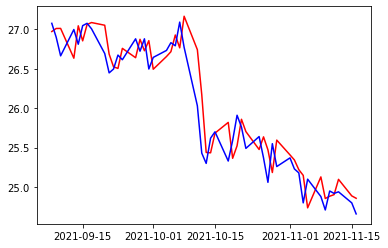

In [8]:
Y_test=Y_t.iloc[675:725]
Y_test=pd.DataFrame(Y_test)
predds_1=pd.DataFrame(predds_0, index=Y_test.index)
predds_1
plt.plot(predds_1, color='red')
plt.plot(Y_test, color='blue')

In [9]:
print(Errors_A[3].mean())
print(Errors_B[3].mean())
print(Errors_C[3].mean())

0.8383710960891224
5.165794690764553
0.8526638482380885


In [10]:
stock = web.get_data_yahoo("NVDA",
start = "2019-01-01",
end = "2021-11-17")
y=stock['Adj Close']

Y_t=y.T
Y_t=Y_t.iloc[1:727]
Y_train=Y_t

model = pm.auto_arima(Y_train, start_p=3, start_q=3,start_d=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=6, max_q=6, max_d=2, # maximum p and q
                      m=1,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      #start_P=0, 
                      #D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

#ARIMA model
Errors_000=[]
predds=list()
n=675
for i in range(0,50):
    Y_train=Y_t.iloc[:n+i]
    Y_test=Y_t.iloc[n+i:n+1+i]
    
    arima_model = ARIMA(Y_train, order=model.order)
    arima_model_fit = arima_model.fit()
    preds_arima= arima_model_fit.forecast(len(Y_test),alpha=0.3)
    preds_arima=np.array(preds_arima)
    preds_atempt_1=preds_arima
    preds = pd.Series(preds_arima, index=Y_test.index)
    
    mse = mean_squared_error(Y_test, preds)
    rmse = sqrt(mean_squared_error(Y_test, preds))
    mae = mean_absolute_error(Y_test, preds)
    mape=MAPE(Y_test, preds)
    predds.append(preds_atempt_1)

    Error_i = ([mse, rmse, mae, mape])
    Errors_000.append(Error_i)
    Errors_A=pd.DataFrame(Errors_000)




#Garch model   
Errors_001=[]

for i in range(0,50):
    Y_train=Y_t.iloc[:n+i]
    Y_test=Y_t.iloc[n+i:n+1+i]

    garch = arch_model(Y_train, vol="Garch", p=1, q=1, dist="gaussian")
    garch_fitted = garch.fit()
    garch_forecast = garch_fitted.forecast(horizon=1)
    garch_pred_mean = garch_forecast.mean['h.1'].iloc[-1]
    preds = pd.DataFrame([garch_pred_mean])

    mse = mean_squared_error(Y_test, preds)
    rmse = sqrt(mean_squared_error(Y_test, preds))
    mae = mean_absolute_error(Y_test, preds)
    mape=MAPE(Y_test, preds)
    Error_i = ([mse, rmse, mae, mape])
    Errors_001.append(Error_i)
    Errors_B=pd.DataFrame(Errors_001)

    
#ARIMA-GARCH model  
Errors_002=[]
predds_0=list()
for i in range(0,50):
    Y_train=Y_t.iloc[:n+i]
    Y_test=Y_t.iloc[n+i:n+1+i]
    
    arima_model = ARIMA(Y_train, order=(model.order))
    arima_model_fit = arima_model.fit()
    arima_residuals = arima_model_fit.resid
    predicted_mu = arima_model_fit.forecast(len(Y_test))
    garch = arch_model(arima_residuals, vol="Garch", p=1, q=1, dist="gaussian")
    garch_fitted = garch.fit()
    garch_forecast = garch_fitted.forecast(horizon=1)
    garch_pred_mean = garch_forecast.mean['h.1'].iloc[-1]
    garch_pred_var = garch_forecast.variance['h.1'].iloc[-1]

    # Combine both models' output: yt = mu + et
    preds = predicted_mu + garch_pred_mean
    preds_0=np.array(preds)
    predds_0.append(preds_0)

    mse = mean_squared_error(Y_test, preds)
    rmse = sqrt(mean_squared_error(Y_test, preds))
    mae = mean_absolute_error(Y_test, preds)
    mape=MAPE(Y_test, preds)
    Error_i = ([mse, rmse, mae, mape])
    Errors_002.append(Error_i)
    Errors_C=pd.DataFrame(Errors_002)
    
    
# print(Errors_A[3].mean())
# print(Errors_B[3].mean())
# print(Errors_C[3].mean())

Performing stepwise search to minimize aic
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3797.769, Time=0.78 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3797.602, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3797.312, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3797.646, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3804.109, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3794.222, Time=0.11 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3796.220, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3796.221, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3797.375, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3798.222, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3800.068, Time=0.04 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 1.751 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A dat

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19006.377870546115
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3361.5199185930896
Iteration:      3,   Func. Count:     18,   Neg. LLF: 3259.633588659536
Iteration:      4,   Func. Count:     23,   Neg. LLF: 3587.941383590306
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4520.298294644161
Iteration:      6,   Func. Count:     36,   Neg. LLF: 3429.736391036626
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3191.862293849103
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3188.247978999274
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3181.794370328886
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3314.4212435045415
Iteration:     11,   Func. Count:     63,   Neg. LLF: 3272.576320879241
Iteration:     12,   Func. Count:     69,   Neg. LLF: 3788.259739688484
Iteration:     13,   Func. Count:     75,   Neg. LLF: 3189.3009023137797
Iteration:     14,   Func. Count:     81,   Neg. LLF: 3167.8

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      2,   Func. Count:     13,   Neg. LLF: 3386.4986004449584
Iteration:      3,   Func. Count:     18,   Neg. LLF: 3348.5232711865506
Iteration:      4,   Func. Count:     23,   Neg. LLF: 3205.780388733714
Iteration:      5,   Func. Count:     28,   Neg. LLF: 3220.732259995456
Iteration:      6,   Func. Count:     34,   Neg. LLF: 3201.978696841732
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3184.7718973721308
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3257.423741535872
Iteration:      9,   Func. Count:     50,   Neg. LLF: 3658.90475732736
Iteration:     10,   Func. Count:     56,   Neg. LLF: 3143.4741323854923
Iteration:     11,   Func. Count:     61,   Neg. LLF: 3189.427598795777
Iteration:     12,   Func. Count:     69,   Neg. LLF: 3200.1890472576183
Iteration:     13,   Func. Count:     76,   Neg. LLF: 3112.780773485213
Iteration:     14,   Func. Count:     81,   Neg. LLF: 1087712994.054723
Iteration:     15,   Func. Count:     88,   Neg. LLF: 3134.1

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      2,   Func. Count:     13,   Neg. LLF: 3421.498879627649
Iteration:      3,   Func. Count:     18,   Neg. LLF: 3336.5307244092237
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4016.959468009006
Iteration:      5,   Func. Count:     29,   Neg. LLF: 3665.808235583993
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3231.7352373950625
Iteration:      7,   Func. Count:     41,   Neg. LLF: 3224.984788316797
Iteration:      8,   Func. Count:     46,   Neg. LLF: 3210.2747017848587
Iteration:      9,   Func. Count:     51,   Neg. LLF: 3773.108962615527
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3436.6195939610498
Iteration:     11,   Func. Count:     63,   Neg. LLF: 3376.8909726277116
Iteration:     12,   Func. Count:     69,   Neg. LLF: 3129.605670519084
Iteration:     13,   Func. Count:     74,   Neg. LLF: 3271.492362093036
Iteration:     14,   Func. Count:     80,   Neg. LLF: 3925.6344550178565
Iteration:     15,   Func. Count:     87,   Neg. LLF: 3181

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     33,   Func. Count:    194,   Neg. LLF: 3135.8084317343337
Iteration:     34,   Func. Count:    200,   Neg. LLF: 3135.766609880995
Iteration:     35,   Func. Count:    205,   Neg. LLF: 3135.7648237101303
Iteration:     36,   Func. Count:    210,   Neg. LLF: 3135.7648130854195
Iteration:     37,   Func. Count:    214,   Neg. LLF: 3135.7648129658287
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3135.7648130854195
            Iterations: 39
            Function evaluations: 214
            Gradient evaluations: 37
Iteration:      1,   Func. Count:      6,   Neg. LLF: 19231.96123990194
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3452.92361566012
Iteration:      3,   Func. Count:     18,   Neg. LLF: 3251.239127337246
Iteration:      4,   Func. Count:     23,   Neg. LLF: 3521.3246825986735
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3248.691938741803
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3238.903087

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     17,   Func. Count:    100,   Neg. LLF: 3326.0353471799617
Iteration:     18,   Func. Count:    106,   Neg. LLF: 3314.8436736961758
Iteration:     19,   Func. Count:    112,   Neg. LLF: 3169.5846894452475
Iteration:     20,   Func. Count:    117,   Neg. LLF: 3220.175594185568
Iteration:     21,   Func. Count:    123,   Neg. LLF: 3339.483812367715
Iteration:     22,   Func. Count:    130,   Neg. LLF: 3967.459251883337
Iteration:     23,   Func. Count:    137,   Neg. LLF: 3631.429862556357
Iteration:     24,   Func. Count:    143,   Neg. LLF: 3162.6191163570015
Iteration:     25,   Func. Count:    149,   Neg. LLF: 3291.0089463358136
Iteration:     26,   Func. Count:    155,   Neg. LLF: 3157.519115463803
Iteration:     27,   Func. Count:    161,   Neg. LLF: 3155.532948042458
Iteration:     28,   Func. Count:    167,   Neg. LLF: 3155.448435531448
Iteration:     29,   Func. Count:    173,   Neg. LLF: 3155.4451350715517
Iteration:     30,   Func. Count:    178,   Neg. LLF: 3155

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      2,   Func. Count:     13,   Neg. LLF: 3497.6178879173594
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4181.652205485614
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5112.726512281263
Iteration:      5,   Func. Count:     31,   Neg. LLF: 3339.227813284363
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3285.5378597261497
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3284.9300408062063
Iteration:      8,   Func. Count:     48,   Neg. LLF: 3272.922537425061
Iteration:      9,   Func. Count:     53,   Neg. LLF: 3209.510930440258
Iteration:     10,   Func. Count:     58,   Neg. LLF: 3789.672705079472
Iteration:     11,   Func. Count:     64,   Neg. LLF: 3792.646692312418
Iteration:     12,   Func. Count:     70,   Neg. LLF: 3794.10183677837
Iteration:     13,   Func. Count:     76,   Neg. LLF: 3178.54833447174
Iteration:     14,   Func. Count:     81,   Neg. LLF: 3849.862194311801
Iteration:     15,   Func. Count:     89,   Neg. LLF: 3217.2555

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     11,   Func. Count:     66,   Neg. LLF: 3522.6912846527534
Iteration:     12,   Func. Count:     72,   Neg. LLF: 3622.891640926686
Iteration:     13,   Func. Count:     78,   Neg. LLF: 3625.110532410692
Iteration:     14,   Func. Count:     84,   Neg. LLF: 3524.24056016188
Iteration:     15,   Func. Count:     90,   Neg. LLF: 103603.54116031247
Iteration:     16,   Func. Count:     96,   Neg. LLF: 3293.703051625429
Iteration:     17,   Func. Count:    102,   Neg. LLF: 220189.0664719201
Iteration:     18,   Func. Count:    108,   Neg. LLF: 3266.6868793468607
Iteration:     19,   Func. Count:    113,   Neg. LLF: 4122.765127220588
Iteration:     20,   Func. Count:    119,   Neg. LLF: 4087.2478840797853
Iteration:     21,   Func. Count:    125,   Neg. LLF: 3973.5627253940984
Iteration:     22,   Func. Count:    131,   Neg. LLF: 3275.905471691975
Iteration:     23,   Func. Count:    137,   Neg. LLF: 3417.443328742146
Iteration:     24,   Func. Count:    143,   Neg. LLF: 3225.0

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     21,   Func. Count:    124,   Neg. LLF: 3227.70086497877
Iteration:     22,   Func. Count:    130,   Neg. LLF: 3227.3681180172207
Iteration:     23,   Func. Count:    135,   Neg. LLF: 3227.365995900247
Iteration:     24,   Func. Count:    140,   Neg. LLF: 3227.3659765900256
Iteration:     25,   Func. Count:    145,   Neg. LLF: 3227.3659698954757
Iteration:     26,   Func. Count:    149,   Neg. LLF: 3227.3659697769763
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3227.3659698954757
            Iterations: 27
            Function evaluations: 149
            Gradient evaluations: 26
Iteration:      1,   Func. Count:      6,   Neg. LLF: 19627.36415376353
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3565.5433062592883
Iteration:      3,   Func. Count:     18,   Neg. LLF: 3776.695398929692
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5077.955680125576
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4212.111510

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     32,   Func. Count:    186,   Neg. LLF: 3246.944677823346
Iteration:     33,   Func. Count:    190,   Neg. LLF: 3246.9446777047274
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3246.944677823346
            Iterations: 35
            Function evaluations: 190
            Gradient evaluations: 33
Iteration:      1,   Func. Count:      6,   Neg. LLF: 19712.255067572747
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3587.8785807929135
Iteration:      3,   Func. Count:     18,   Neg. LLF: 3464.290198717348
Iteration:      4,   Func. Count:     23,   Neg. LLF: 3576.633448786115
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3365.2801212634545
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3365.250538084616
Iteration:      7,   Func. Count:     41,   Neg. LLF: 3357.9725503889413
Iteration:      8,   Func. Count:     46,   Neg. LLF: 3340.6939001257597
Iteration:      9,   Func. Count:     51,   Neg. LLF: 4149.90766

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      2,   Func. Count:     13,   Neg. LLF: 3603.0013863303375
Iteration:      3,   Func. Count:     18,   Neg. LLF: 3378.2729515776073
Iteration:      4,   Func. Count:     23,   Neg. LLF: 3442.037742207485
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3375.9812081636155
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3366.568916098014
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3288.2014141453938
Iteration:      8,   Func. Count:     45,   Neg. LLF: 3622.9077106966442
Iteration:      9,   Func. Count:     51,   Neg. LLF: 3887.929599614238
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3840.235107379927
Iteration:     11,   Func. Count:     63,   Neg. LLF: 3417.4244344504286
Iteration:     12,   Func. Count:     69,   Neg. LLF: 3583.5150913137477
Iteration:     13,   Func. Count:     75,   Neg. LLF: 3330.693754245686
Iteration:     14,   Func. Count:     81,   Neg. LLF: 3882.4582832644014
Iteration:     15,   Func. Count:     87,   Neg. LLF: 33

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     33,   Func. Count:    189,   Neg. LLF: 3279.7605916841294
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3279.76059180409
            Iterations: 33
            Function evaluations: 189
            Gradient evaluations: 33
Iteration:      1,   Func. Count:      6,   Neg. LLF: 19854.894725698818
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3625.975571616169
Iteration:      3,   Func. Count:     18,   Neg. LLF: 3436.968782027805
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4937.831629377689
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3609.916681357805
Iteration:      6,   Func. Count:     36,   Neg. LLF: 3396.8080492161675
Iteration:      7,   Func. Count:     41,   Neg. LLF: 3394.302821170141
Iteration:      8,   Func. Count:     46,   Neg. LLF: 3370.9844660477215
Iteration:      9,   Func. Count:     51,   Neg. LLF: 3347.0147530080476
Iteration:     10,   Func. Count:     56,   Neg. LLF: 3370.0775326

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      2,   Func. Count:     13,   Neg. LLF: 3648.825840246726
Iteration:      3,   Func. Count:     18,   Neg. LLF: 3505.239871900977
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4977.9666737157895
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3844.083071165919
Iteration:      6,   Func. Count:     36,   Neg. LLF: 3438.9261204792747
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3416.2821248621617
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3409.5706156783217
Iteration:      9,   Func. Count:     52,   Neg. LLF: 4260.891802607426
Iteration:     10,   Func. Count:     58,   Neg. LLF: 4260.654671028791
Iteration:     11,   Func. Count:     64,   Neg. LLF: 8416.839204518688
Iteration:     12,   Func. Count:     70,   Neg. LLF: 8309.272775254605
Iteration:     13,   Func. Count:     76,   Neg. LLF: 8185.680749520121
Iteration:     14,   Func. Count:     82,   Neg. LLF: 4315.896666723587
Iteration:     15,   Func. Count:     88,   Neg. LLF: 105191

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     15,   Func. Count:     88,   Neg. LLF: 3328.0734748561754
Iteration:     16,   Func. Count:     93,   Neg. LLF: 1717144833.8996792
Iteration:     17,   Func. Count:    100,   Neg. LLF: 3498.068465081502
Iteration:     18,   Func. Count:    106,   Neg. LLF: 3459.3290200419833
Iteration:     19,   Func. Count:    112,   Neg. LLF: 3356.749823263669
Iteration:     20,   Func. Count:    118,   Neg. LLF: 3930.70455718422
Iteration:     21,   Func. Count:    124,   Neg. LLF: 3565.9762954124553
Iteration:     22,   Func. Count:    130,   Neg. LLF: 3460.972503073641
Iteration:     23,   Func. Count:    136,   Neg. LLF: 3432.9476700195073
Iteration:     24,   Func. Count:    142,   Neg. LLF: 3340.2963048632582
Iteration:     25,   Func. Count:    148,   Neg. LLF: 3321.1229730928817
Iteration:     26,   Func. Count:    154,   Neg. LLF: 3319.644094190063
Iteration:     27,   Func. Count:    159,   Neg. LLF: 3319.639899268799
Iteration:     28,   Func. Count:    164,   Neg. LLF: 3319

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     12,   Func. Count:     71,   Neg. LLF: 3595.289135410634
Iteration:     13,   Func. Count:     77,   Neg. LLF: 3340.8120016122357
Iteration:     14,   Func. Count:     82,   Neg. LLF: 3512.339437968574
Iteration:     15,   Func. Count:     88,   Neg. LLF: 3371.729539300337
Iteration:     16,   Func. Count:     96,   Neg. LLF: 3339.993999633614
Iteration:     17,   Func. Count:    101,   Neg. LLF: 3339.901587887854
Iteration:     18,   Func. Count:    106,   Neg. LLF: 3339.887657207926
Iteration:     19,   Func. Count:    111,   Neg. LLF: 3339.8875026179026
Iteration:     20,   Func. Count:    116,   Neg. LLF: 3339.8874998864294
Iteration:     21,   Func. Count:    120,   Neg. LLF: 3339.887499763514
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3339.8874998864294
            Iterations: 21
            Function evaluations: 120
            Gradient evaluations: 21
Iteration:      1,   Func. Count:      6,   Neg. LLF: 20116.943204

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      6,   Func. Count:     36,   Neg. LLF: 4098.741643743703
Iteration:      7,   Func. Count:     42,   Neg. LLF: 4858.725434065696
Iteration:      8,   Func. Count:     49,   Neg. LLF: 3494.002979304721
Iteration:      9,   Func. Count:     55,   Neg. LLF: 3472.0299234840772
Iteration:     10,   Func. Count:     60,   Neg. LLF: 3458.0707655428573
Iteration:     11,   Func. Count:     65,   Neg. LLF: 3897.2095144797963
Iteration:     12,   Func. Count:     71,   Neg. LLF: 3487.0701130131993
Iteration:     13,   Func. Count:     77,   Neg. LLF: 3643.3133136290007
Iteration:     14,   Func. Count:     83,   Neg. LLF: 3707.2984771849074
Iteration:     15,   Func. Count:     89,   Neg. LLF: 3697.554127463415
Iteration:     16,   Func. Count:     95,   Neg. LLF: 3629.2897394864567
Iteration:     17,   Func. Count:    101,   Neg. LLF: 193255.10692237728
Iteration:     18,   Func. Count:    107,   Neg. LLF: 3424.807202502906
Iteration:     19,   Func. Count:    113,   Neg. LLF: 18

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     13,   Func. Count:     74,   Neg. LLF: 3578.6418201955403
Iteration:     14,   Func. Count:     80,   Neg. LLF: 3410.598636894787
Iteration:     15,   Func. Count:     85,   Neg. LLF: 1830093682.3928645
Iteration:     16,   Func. Count:     91,   Neg. LLF: 4993.447986636802
Iteration:     17,   Func. Count:     97,   Neg. LLF: 3711.4350838142273
Iteration:     18,   Func. Count:    103,   Neg. LLF: 3803.643647206686
Iteration:     19,   Func. Count:    109,   Neg. LLF: 3843.64200859953
Iteration:     20,   Func. Count:    115,   Neg. LLF: 3823.5410479821503
Iteration:     21,   Func. Count:    121,   Neg. LLF: 3549.0792478891526
Iteration:     22,   Func. Count:    128,   Neg. LLF: 3716.624665574012
Iteration:     23,   Func. Count:    134,   Neg. LLF: 3526.528458665303
Iteration:     24,   Func. Count:    140,   Neg. LLF: 3475.8792530733867
Iteration:     25,   Func. Count:    146,   Neg. LLF: 3657.2892269833915
Iteration:     26,   Func. Count:    152,   Neg. LLF: 3481

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     30,   Func. Count:    172,   Neg. LLF: 3409.180373156941
Iteration:     31,   Func. Count:    177,   Neg. LLF: 3409.1803710599706
Iteration:     32,   Func. Count:    181,   Neg. LLF: 3409.1803709333003
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3409.1803710599706
            Iterations: 32
            Function evaluations: 181
            Gradient evaluations: 32
Iteration:      1,   Func. Count:      6,   Neg. LLF: 20425.75468256937
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3770.248404735479
Iteration:      3,   Func. Count:     18,   Neg. LLF: 3766.0908430782965
Iteration:      4,   Func. Count:     23,   Neg. LLF: 3708.431245876669
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4983.984401294179
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5067.316909736185
Iteration:      7,   Func. Count:     42,   Neg. LLF: 4051.9075651864287
Iteration:      8,   Func. Count:     48,   Neg. LLF: 3553.950702

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Us

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3541.4798932694407
Iteration:      2,   Func. Count:     14,   Neg. LLF: 51731.981988567306
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1534.1556209789742
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1563.1684877182606
Iteration:      5,   Func. Count:     34,   Neg. LLF: 1533.3343006601795
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1518.4220610508273
Iteration:      7,   Func. Count:     45,   Neg. LLF: 1518.4280360217024
Iteration:      8,   Func. Count:     51,   Neg. LLF: 1518.3872623108937
Iteration:      9,   Func. Count:     56,   Neg. LLF: 1518.387227986218
Iteration:     10,   Func. Count:     60,   Neg. LLF: 1518.387227283814
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1518.387227986218
            Iterations: 10
            Function evaluations: 60
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      6,   Neg. LLF: 3537.2373

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3546.923012392985
Iteration:      2,   Func. Count:     14,   Neg. LLF: 48449.07837532548
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1541.678665604085
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1572.5835217427546
Iteration:      5,   Func. Count:     34,   Neg. LLF: 1540.940966657035
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1525.799381389664
Iteration:      7,   Func. Count:     45,   Neg. LLF: 1525.809780340906
Iteration:      8,   Func. Count:     51,   Neg. LLF: 1525.7678999373406
Iteration:      9,   Func. Count:     56,   Neg. LLF: 1525.7678860432197
Iteration:     10,   Func. Count:     60,   Neg. LLF: 1525.7678853724806
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1525.7678860432197
            Iterations: 10
            Function evaluations: 60
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      6,   Neg. LLF: 3554.1487119

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Us

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3565.7953169991615
Iteration:      2,   Func. Count:     14,   Neg. LLF: 60806.894406331616
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1548.0511248268303
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1585.3097472722518
Iteration:      5,   Func. Count:     34,   Neg. LLF: 1542.8700106174306
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1531.898966938409
Iteration:      7,   Func. Count:     45,   Neg. LLF: 1531.915316544259
Iteration:      8,   Func. Count:     51,   Neg. LLF: 1531.8833130038338
Iteration:      9,   Func. Count:     56,   Neg. LLF: 1531.883279485141
Iteration:     10,   Func. Count:     60,   Neg. LLF: 1531.883278881567
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1531.883279485141
            Iterations: 10
            Function evaluations: 60
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      6,   Neg. LLF: 3557.301107

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Us

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3516.642828230064
Iteration:      2,   Func. Count:     14,   Neg. LLF: 52839.67230986128
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1559.3265718661467
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1550.9582262289396
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1560.155989023575
Iteration:      6,   Func. Count:     39,   Neg. LLF: 1543.7054853194768
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1543.7011077291127
Iteration:      8,   Func. Count:     49,   Neg. LLF: 1543.7004988274678
Iteration:      9,   Func. Count:     54,   Neg. LLF: 1543.6993492138974
Iteration:     10,   Func. Count:     59,   Neg. LLF: 1543.699257968217
Iteration:     11,   Func. Count:     64,   Neg. LLF: 1543.699254931681
Iteration:     12,   Func. Count:     68,   Neg. LLF: 1543.6992541243133
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1543.699254931681
            Iteration

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Us

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3573.406344264086
Iteration:      2,   Func. Count:     14,   Neg. LLF: 201581.06454884418
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1569.2894985665548
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1578.5598955082273
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1568.707777399276
Iteration:      6,   Func. Count:     39,   Neg. LLF: 1553.5242521783857
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1553.538177493795
Iteration:      8,   Func. Count:     50,   Neg. LLF: 1553.5059105127843
Iteration:      9,   Func. Count:     55,   Neg. LLF: 1553.5059009477009
Iteration:     10,   Func. Count:     59,   Neg. LLF: 1553.5059000514973
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1553.5059009477009
            Iterations: 10
            Function evaluations: 59
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      6,   Neg. LLF: 3552.3915

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Us

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3478.121039990238
Iteration:      2,   Func. Count:     14,   Neg. LLF: 227157.8790292963
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1580.143298325167
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1566.9951685189126
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1565.376285051677
Iteration:      6,   Func. Count:     39,   Neg. LLF: 1564.1342053343883
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1564.0936491838606
Iteration:      8,   Func. Count:     49,   Neg. LLF: 1564.0924812694295
Iteration:      9,   Func. Count:     54,   Neg. LLF: 1564.0924711381947
Iteration:     10,   Func. Count:     58,   Neg. LLF: 1564.0924701571917
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1564.0924711381947
            Iterations: 10
            Function evaluations: 58
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      6,   Neg. LLF: 3499.62210

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Us

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3440.1946320066054
Iteration:      2,   Func. Count:     14,   Neg. LLF: 656381.7640432421
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1590.306042709509
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1577.1213419602504
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1574.6867332642996
Iteration:      6,   Func. Count:     38,   Neg. LLF: 1574.2876961837778
Iteration:      7,   Func. Count:     43,   Neg. LLF: 1574.2403795648074
Iteration:      8,   Func. Count:     48,   Neg. LLF: 1574.2387351151485
Iteration:      9,   Func. Count:     53,   Neg. LLF: 1574.2384584310898
Iteration:     10,   Func. Count:     57,   Neg. LLF: 1574.2384573800891
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1574.2384584310898
            Iterations: 10
            Function evaluations: 57
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      6,   Neg. LLF: 3488.305

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3538.7223980715053
Iteration:      2,   Func. Count:     14,   Neg. LLF: 63893.60260262219
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1599.195293445578
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1587.715546300173
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1587.2951995524938
Iteration:      6,   Func. Count:     39,   Neg. LLF: 1583.1917293374681
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1583.2045917457017
Iteration:      8,   Func. Count:     50,   Neg. LLF: 1583.1672593776473
Iteration:      9,   Func. Count:     55,   Neg. LLF: 1583.16723441103
Iteration:     10,   Func. Count:     59,   Neg. LLF: 1583.1672334119316
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1583.16723441103
            Iterations: 10
            Function evaluations: 59
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      6,   Neg. LLF: 3528.39496634

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3525.0840702866117
Iteration:      2,   Func. Count:     14,   Neg. LLF: 205782.4909558816
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1606.9579148641533
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1594.3729956840625
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1592.2310676668244
Iteration:      6,   Func. Count:     39,   Neg. LLF: 1590.8816546547207
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1590.8511815300485
Iteration:      8,   Func. Count:     49,   Neg. LLF: 1590.8481030939047
Iteration:      9,   Func. Count:     54,   Neg. LLF: 1590.8480815804228
Iteration:     10,   Func. Count:     58,   Neg. LLF: 1590.8480806680811
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1590.8480815804228
            Iterations: 10
            Function evaluations: 58
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      6,   Neg. LLF: 3544.28

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Us

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3598.517725944461
Iteration:      2,   Func. Count:     14,   Neg. LLF: 160431.36846878164
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1616.3326067965513
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1607.157291244635
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1615.207053397073
Iteration:      6,   Func. Count:     39,   Neg. LLF: 1600.5474882145745
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1600.540519367909
Iteration:      8,   Func. Count:     49,   Neg. LLF: 1600.543753659783
Iteration:      9,   Func. Count:     55,   Neg. LLF: 1600.5383958586854
Iteration:     10,   Func. Count:     60,   Neg. LLF: 1600.538241851139
Iteration:     11,   Func. Count:     64,   Neg. LLF: 1600.5382408775677
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1600.538241851139
            Iterations: 11
            Function evaluations: 64
            Gradient evaluation

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Us

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3616.1447000041253
Iteration:      2,   Func. Count:     14,   Neg. LLF: 101386.37438076989
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1623.8936691889373
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1614.5493060309357
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1623.2190361629132
Iteration:      6,   Func. Count:     39,   Neg. LLF: 1608.0687553084795
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1608.061513255871
Iteration:      8,   Func. Count:     49,   Neg. LLF: 1608.0634451204119
Iteration:      9,   Func. Count:     55,   Neg. LLF: 1608.0599672929425
Iteration:     10,   Func. Count:     60,   Neg. LLF: 1608.0598122305805
Iteration:     11,   Func. Count:     64,   Neg. LLF: 1608.0598113256794
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1608.0598122305805
            Iterations: 11
            Function evaluations: 64
            Gradient eval

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3674.6464674513854
Iteration:      2,   Func. Count:     14,   Neg. LLF: 249895.78551986502
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1632.310639423163
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1631.6884687625038
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1632.401217519467
Iteration:      6,   Func. Count:     39,   Neg. LLF: 1616.6871578858409
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1616.6929001711128
Iteration:      8,   Func. Count:     50,   Neg. LLF: 1616.680909600043
Iteration:      9,   Func. Count:     55,   Neg. LLF: 1616.6808519238546
Iteration:     10,   Func. Count:     59,   Neg. LLF: 1616.6808510037336
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1616.6808519238546
            Iterations: 10
            Function evaluations: 59
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      6,   Neg. LLF: 3780.9346

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Us

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3793.4379763681463
Iteration:      2,   Func. Count:     14,   Neg. LLF: 73302.73232084324
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1649.9373545230342
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1651.6979136277523
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1666.5709709188707
Iteration:      6,   Func. Count:     39,   Neg. LLF: 1633.8480071939787
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1633.9149648594653
Iteration:      8,   Func. Count:     50,   Neg. LLF: 1633.8434492333017
Iteration:      9,   Func. Count:     55,   Neg. LLF: 1633.8434070222072
Iteration:     10,   Func. Count:     59,   Neg. LLF: 1633.8434056417825
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1633.8434070222072
            Iterations: 10
            Function evaluations: 59
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      6,   Neg. LLF: 3827.50

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Us

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3864.8581269690503
Iteration:      2,   Func. Count:     14,   Neg. LLF: 79172.9409790776
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1686.0593061932584
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1658.5306370564626
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1654.4739337678536
Iteration:      6,   Func. Count:     39,   Neg. LLF: 1645.440207177076
Iteration:      7,   Func. Count:     45,   Neg. LLF: 1643.3921600053936
Iteration:      8,   Func. Count:     50,   Neg. LLF: 1643.3850533710365
Iteration:      9,   Func. Count:     56,   Neg. LLF: 1643.3681897429942
Iteration:     10,   Func. Count:     61,   Neg. LLF: 1643.3681742313684
Iteration:     11,   Func. Count:     65,   Neg. LLF: 1643.368172880681
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1643.3681742313684
            Iterations: 11
            Function evaluations: 65
            Gradient evaluat

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      9,   Func. Count:     57,   Neg. LLF: 1668.1064828307394
Iteration:     10,   Func. Count:     61,   Neg. LLF: 1668.1064802189285
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1668.1064828307394
            Iterations: 10
            Function evaluations: 61
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      6,   Neg. LLF: 4031.734510823469
Iteration:      2,   Func. Count:     15,   Neg. LLF: 179025.96834730363
Iteration:      3,   Func. Count:     22,   Neg. LLF: 1686.7092284631765
Iteration:      4,   Func. Count:     28,   Neg. LLF: 1687.5511847074501
Iteration:      5,   Func. Count:     34,   Neg. LLF: 1683.9491250717183
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1671.7217544120645
Iteration:      7,   Func. Count:     45,   Neg. LLF: 1672.6736747670677
Iteration:      8,   Func. Count:     52,   Neg. LLF: 1671.7195077392003
Iteration:      9,   Func. Count:     57,   Neg. LLF: 1671.71

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Us

Iteration:      1,   Func. Count:      6,   Neg. LLF: 4045.8820034550467
Iteration:      2,   Func. Count:     15,   Neg. LLF: 164107.81913933068
Iteration:      3,   Func. Count:     22,   Neg. LLF: 1694.9708082845527
Iteration:      4,   Func. Count:     28,   Neg. LLF: 1696.133735885233
Iteration:      5,   Func. Count:     34,   Neg. LLF: 1693.7634651093442
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1680.4411150368387
Iteration:      7,   Func. Count:     45,   Neg. LLF: 1680.8274023206868
Iteration:      8,   Func. Count:     52,   Neg. LLF: 1680.4396745483534
Iteration:      9,   Func. Count:     57,   Neg. LLF: 1680.4396499685197
Iteration:     10,   Func. Count:     61,   Neg. LLF: 1680.439647452201
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1680.4396499685197
            Iterations: 10
            Function evaluations: 61
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      6,   Neg. LLF: 4002.577

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 4058.5255988930303
Iteration:      2,   Func. Count:     15,   Neg. LLF: 970419.9142772246
Iteration:      3,   Func. Count:     22,   Neg. LLF: 1704.9044460698017
Iteration:      4,   Func. Count:     28,   Neg. LLF: 1706.642947655912
Iteration:      5,   Func. Count:     34,   Neg. LLF: 1705.9956710111642
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1689.9101482309397
Iteration:      7,   Func. Count:     45,   Neg. LLF: 1689.9118762404155
Iteration:      8,   Func. Count:     51,   Neg. LLF: 1689.9100507164703
Iteration:      9,   Func. Count:     56,   Neg. LLF: 1689.909706453022
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1689.909708913438
            Iterations: 9
            Function evaluations: 56
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      6,   Neg. LLF: 4047.5660030778895
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1310664.8277

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Us

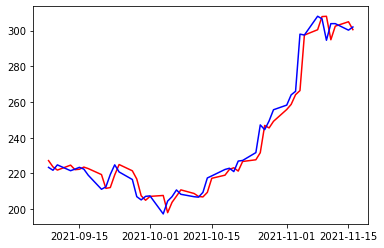

In [11]:
Y_test=Y_t.iloc[675:725]
Y_test=pd.DataFrame(Y_test)
predds_1=pd.DataFrame(predds_0, index=Y_test.index)
predds_1
plt.plot(predds_1, color='red')
plt.plot(Y_test, color='blue')

In [12]:
print(Errors_A[3].mean())
print(Errors_B[3].mean())
print(Errors_C[3].mean())

1.9075578384085106
81.0840994302937
1.8927956564239585


In [13]:
stock = web.get_data_yahoo("MSFT",
start = "2019-01-01",
end = "2021-11-17")
y=stock['Adj Close']

Y_t=y.T
Y_t=Y_t.iloc[1:727]
Y_train=Y_t

model = pm.auto_arima(Y_train, start_p=3, start_q=3,start_d=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=6, max_q=6, max_d=2, # maximum p and q
                      m=1,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      #start_P=0, 
                      #D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

#ARIMA model
Errors_000=[]
predds=list()
n=675
for i in range(0,50):
    Y_train=Y_t.iloc[:n+i]
    Y_test=Y_t.iloc[n+i:n+1+i]
    
    arima_model = ARIMA(Y_train, order=model.order)
    arima_model_fit = arima_model.fit()
    preds_arima= arima_model_fit.forecast(len(Y_test),alpha=0.3)
    preds_arima=np.array(preds_arima)
    preds_atempt_1=preds_arima
    preds = pd.Series(preds_arima, index=Y_test.index)
    
    mse = mean_squared_error(Y_test, preds)
    rmse = sqrt(mean_squared_error(Y_test, preds))
    mae = mean_absolute_error(Y_test, preds)
    mape=MAPE(Y_test, preds)
    predds.append(preds_atempt_1)

    Error_i = ([mse, rmse, mae, mape])
    Errors_000.append(Error_i)
    Errors_A=pd.DataFrame(Errors_000)




#Garch model   
Errors_001=[]

for i in range(0,50):
    Y_train=Y_t.iloc[:n+i]
    Y_test=Y_t.iloc[n+i:n+1+i]

    garch = arch_model(Y_train, vol="Garch", p=1, q=1, dist="gaussian")
    garch_fitted = garch.fit()
    garch_forecast = garch_fitted.forecast(horizon=1)
    garch_pred_mean = garch_forecast.mean['h.1'].iloc[-1]
    preds = pd.DataFrame([garch_pred_mean])

    mse = mean_squared_error(Y_test, preds)
    rmse = sqrt(mean_squared_error(Y_test, preds))
    mae = mean_absolute_error(Y_test, preds)
    mape=MAPE(Y_test, preds)
    Error_i = ([mse, rmse, mae, mape])
    Errors_001.append(Error_i)
    Errors_B=pd.DataFrame(Errors_001)

    
#ARIMA-GARCH model  
Errors_002=[]
predds_0=list()
for i in range(0,50):
    Y_train=Y_t.iloc[:n+i]
    Y_test=Y_t.iloc[n+i:n+1+i]
    
    arima_model = ARIMA(Y_train, order=(model.order))
    arima_model_fit = arima_model.fit()
    arima_residuals = arima_model_fit.resid
    predicted_mu = arima_model_fit.forecast(len(Y_test))
    garch = arch_model(arima_residuals, vol="Garch", p=1, q=1, dist="gaussian")
    garch_fitted = garch.fit()
    garch_forecast = garch_fitted.forecast(horizon=1)
    garch_pred_mean = garch_forecast.mean['h.1'].iloc[-1]
    garch_pred_var = garch_forecast.variance['h.1'].iloc[-1]

    # Combine both models' output: yt = mu + et
    preds = predicted_mu + garch_pred_mean
    preds_0=np.array(preds)
    predds_0.append(preds_0)

    mse = mean_squared_error(Y_test, preds)
    rmse = sqrt(mean_squared_error(Y_test, preds))
    mae = mean_absolute_error(Y_test, preds)
    mape=MAPE(Y_test, preds)
    Error_i = ([mse, rmse, mae, mape])
    Errors_002.append(Error_i)
    Errors_C=pd.DataFrame(Errors_002)
    
    
# print(Errors_A[3].mean())
# print(Errors_B[3].mean())
# print(Errors_C[3].mean())

Performing stepwise search to minimize aic
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3854.338, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3818.683, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3822.513, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3859.283, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3819.786, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3819.830, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3821.786, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3827.463, Time=0.03 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.812 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  726
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -1906.342
Date:                Thu, 25 Nov 2021   AIC           

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A dat

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19008.995177410197
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3422.7247257474874
Iteration:      3,   Func. Count:     18,   Neg. LLF: 3420.9235896747687
Iteration:      4,   Func. Count:     23,   Neg. LLF: 3420.5586266043056
Iteration:      5,   Func. Count:     28,   Neg. LLF: 3420.3719374743855
Iteration:      6,   Func. Count:     33,   Neg. LLF: 3419.669838392846
Iteration:      7,   Func. Count:     38,   Neg. LLF: 3418.7049011287736
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3417.4156882190573
Iteration:      9,   Func. Count:     48,   Neg. LLF: 3414.5383920181303
Iteration:     10,   Func. Count:     53,   Neg. LLF: 11876.076259248439
Iteration:     11,   Func. Count:     59,   Neg. LLF: 10516.641183415637
Iteration:     12,   Func. Count:     65,   Neg. LLF: 6679.7100116849
Iteration:     13,   Func. Count:     71,   Neg. LLF: 3667.243393192224
Iteration:     14,   Func. Count:     77,   Neg. LLF: 36

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19094.651366105434
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3442.346927785763
Iteration:      3,   Func. Count:     18,   Neg. LLF: 3440.0167776226185
Iteration:      4,   Func. Count:     23,   Neg. LLF: 3439.3271414750807
Iteration:      5,   Func. Count:     28,   Neg. LLF: 3439.194801170618
Iteration:      6,   Func. Count:     33,   Neg. LLF: 3438.516597279814
Iteration:      7,   Func. Count:     38,   Neg. LLF: 3435.4155308268078
Iteration:      8,   Func. Count:     43,   Neg. LLF: 8698.635032480868
Iteration:      9,   Func. Count:     49,   Neg. LLF: 6528.225375567575
Iteration:     10,   Func. Count:     55,   Neg. LLF: 3496.5314264142366
Iteration:     11,   Func. Count:     61,   Neg. LLF: 3497.6057085693183
Iteration:     12,   Func. Count:     67,   Neg. LLF: 3489.313943216627
Iteration:     13,   Func. Count:     73,   Neg. LLF: 3523.974383340993
Iteration:     14,   Func. Count:     79,   Neg. LLF: 3467

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19180.584771702044
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3462.1368619512687
Iteration:      3,   Func. Count:     18,   Neg. LLF: 3459.4551236173943
Iteration:      4,   Func. Count:     23,   Neg. LLF: 3458.2892713309775
Iteration:      5,   Func. Count:     28,   Neg. LLF: 3458.1003025648083
Iteration:      6,   Func. Count:     33,   Neg. LLF: 3457.7380071747916
Iteration:      7,   Func. Count:     38,   Neg. LLF: 3457.289147972818
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3454.349578481064
Iteration:      9,   Func. Count:     48,   Neg. LLF: 5738.427027577723
Iteration:     10,   Func. Count:     54,   Neg. LLF: 3862.328861058104
Iteration:     11,   Func. Count:     60,   Neg. LLF: 7606.952546452611
Iteration:     12,   Func. Count:     66,   Neg. LLF: 4881.768654974792
Iteration:     13,   Func. Count:     72,   Neg. LLF: 4364.403084379021
Iteration:     14,   Func. Count:     78,   Neg. LLF: 4937

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     34,   Func. Count:    190,   Neg. LLF: 3448.0458467404715
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3448.0458467404715
            Iterations: 35
            Function evaluations: 190
            Gradient evaluations: 34
Iteration:      1,   Func. Count:      6,   Neg. LLF: 19266.659012632743
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3481.899579012842
Iteration:      3,   Func. Count:     18,   Neg. LLF: 3479.143952904733
Iteration:      4,   Func. Count:     23,   Neg. LLF: 3478.0589622894922
Iteration:      5,   Func. Count:     28,   Neg. LLF: 3477.297171947089
Iteration:      6,   Func. Count:     33,   Neg. LLF: 3482.111689154432
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3476.7216891604658
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3476.289338977665
Iteration:      9,   Func. Count:     49,   Neg. LLF: 3474.1554088554503
Iteration:     10,   Func. Count:     54,   Neg. LLF: 3470.66390

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     18,   Func. Count:    100,   Neg. LLF: 3540.091244384981
Iteration:     19,   Func. Count:    106,   Neg. LLF: 3533.797005764864
Iteration:     20,   Func. Count:    112,   Neg. LLF: 5972.997997416561
Iteration:     21,   Func. Count:    118,   Neg. LLF: 7578.166978200947
Iteration:     22,   Func. Count:    124,   Neg. LLF: 4417.1729196155975
Iteration:     23,   Func. Count:    130,   Neg. LLF: 6202.255224470688
Iteration:     24,   Func. Count:    136,   Neg. LLF: 3614.8383485376344
Iteration:     25,   Func. Count:    142,   Neg. LLF: 3539.890768819163
Iteration:     26,   Func. Count:    148,   Neg. LLF: 3522.27803309755
Iteration:     27,   Func. Count:    154,   Neg. LLF: 3533.939894635957
Iteration:     28,   Func. Count:    160,   Neg. LLF: 3469.510973327635
Iteration:     29,   Func. Count:    166,   Neg. LLF: 3466.7236677158203
Iteration:     30,   Func. Count:    171,   Neg. LLF: 3466.5594863996803
Iteration:     31,   Func. Count:    176,   Neg. LLF: 3466.53

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      2,   Func. Count:     13,   Neg. LLF: 3514.532896902836
Iteration:      3,   Func. Count:     18,   Neg. LLF: 3512.1940874251436
Iteration:      4,   Func. Count:     23,   Neg. LLF: 3509.5642609866845
Iteration:      5,   Func. Count:     28,   Neg. LLF: 3508.6566826374924
Iteration:      6,   Func. Count:     33,   Neg. LLF: 3514.2629169757056
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3508.121877741398
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3507.2060844713124
Iteration:      9,   Func. Count:     49,   Neg. LLF: 3505.133485964393
Iteration:     10,   Func. Count:     54,   Neg. LLF: 3500.231271430785
Iteration:     11,   Func. Count:     59,   Neg. LLF: 5115.310960145422
Iteration:     12,   Func. Count:     65,   Neg. LLF: 3713.0507507337143
Iteration:     13,   Func. Count:     71,   Neg. LLF: 3591.536926040084
Iteration:     14,   Func. Count:     77,   Neg. LLF: 3521.3196267018925
Iteration:     15,   Func. Count:     83,   Neg. LLF: 355

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      2,   Func. Count:     13,   Neg. LLF: 3533.42531144205
Iteration:      3,   Func. Count:     18,   Neg. LLF: 3531.5011159860233
Iteration:      4,   Func. Count:     23,   Neg. LLF: 3527.547790691849
Iteration:      5,   Func. Count:     28,   Neg. LLF: 3526.811679089824
Iteration:      6,   Func. Count:     33,   Neg. LLF: 3526.664292392229
Iteration:      7,   Func. Count:     38,   Neg. LLF: 3526.4593019799195
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3525.0192441828976
Iteration:      9,   Func. Count:     48,   Neg. LLF: 3520.61163669666
Iteration:     10,   Func. Count:     53,   Neg. LLF: 3517.245616469357
Iteration:     11,   Func. Count:     58,   Neg. LLF: 3529.7702906500467
Iteration:     12,   Func. Count:     64,   Neg. LLF: 3641.2570937254336
Iteration:     13,   Func. Count:     70,   Neg. LLF: 3571.8824444370407
Iteration:     14,   Func. Count:     76,   Neg. LLF: 3575.0467309334413
Iteration:     15,   Func. Count:     82,   Neg. LLF: 6667.

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19581.942576051235
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3552.3460765504046
Iteration:      3,   Func. Count:     18,   Neg. LLF: 3550.8753487363833
Iteration:      4,   Func. Count:     23,   Neg. LLF: 3545.5493607135113
Iteration:      5,   Func. Count:     28,   Neg. LLF: 3545.2949931023954
Iteration:      6,   Func. Count:     33,   Neg. LLF: 3545.149490170409
Iteration:      7,   Func. Count:     38,   Neg. LLF: 3544.263225840614
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3539.3279407076707
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4805.31634803043
Iteration:     10,   Func. Count:     54,   Neg. LLF: 10864.978523495258
Iteration:     11,   Func. Count:     60,   Neg. LLF: 10921.29268816647
Iteration:     12,   Func. Count:     66,   Neg. LLF: 5993.119148802307
Iteration:     13,   Func. Count:     72,   Neg. LLF: 4298.6224925058195
Iteration:     14,   Func. Count:     78,   Neg. LLF: 355

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     13,   Func. Count:     71,   Neg. LLF: 4014.3967973866784
Iteration:     14,   Func. Count:     77,   Neg. LLF: 4112.048844162326
Iteration:     15,   Func. Count:     83,   Neg. LLF: 4162.022350401847
Iteration:     16,   Func. Count:     89,   Neg. LLF: 6155.530290979204
Iteration:     17,   Func. Count:     96,   Neg. LLF: 3566.6549881768274
Iteration:     18,   Func. Count:    102,   Neg. LLF: 3562.753609980727
Iteration:     19,   Func. Count:    107,   Neg. LLF: 3560.9404179612666
Iteration:     20,   Func. Count:    112,   Neg. LLF: 3893.08981146176
Iteration:     21,   Func. Count:    118,   Neg. LLF: 3638.969047163898
Iteration:     22,   Func. Count:    124,   Neg. LLF: 3617.190349195594
Iteration:     23,   Func. Count:    130,   Neg. LLF: 3606.460625328806
Iteration:     24,   Func. Count:    136,   Neg. LLF: 4099.427933259602
Iteration:     25,   Func. Count:    142,   Neg. LLF: 3607.2184296376654
Iteration:     26,   Func. Count:    148,   Neg. LLF: 3613.30

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      7,   Func. Count:     39,   Neg. LLF: 3550.5024397946763
Iteration:      8,   Func. Count:     45,   Neg. LLF: 3540.978883165958
Iteration:      9,   Func. Count:     50,   Neg. LLF: 3533.171108595954
Iteration:     10,   Func. Count:     55,   Neg. LLF: 3530.563727229629
Iteration:     11,   Func. Count:     60,   Neg. LLF: 3529.2786066864783
Iteration:     12,   Func. Count:     65,   Neg. LLF: 3522.1845383168775
Iteration:     13,   Func. Count:     70,   Neg. LLF: 3640.2768073398397
Iteration:     14,   Func. Count:     76,   Neg. LLF: 3645.849404259514
Iteration:     15,   Func. Count:     82,   Neg. LLF: 3652.0883174250675
Iteration:     16,   Func. Count:     88,   Neg. LLF: 3653.2740461109042
Iteration:     17,   Func. Count:     94,   Neg. LLF: 3653.6147944960608
Iteration:     18,   Func. Count:    100,   Neg. LLF: 97131.7412418556
Iteration:     19,   Func. Count:    107,   Neg. LLF: 18523.195050943417
Iteration:     20,   Func. Count:    114,   Neg. LLF: 355

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     25,   Func. Count:    141,   Neg. LLF: 3589.9815209705193
Iteration:     26,   Func. Count:    147,   Neg. LLF: 3588.515076710578
Iteration:     27,   Func. Count:    153,   Neg. LLF: 3573.6638510614794
Iteration:     28,   Func. Count:    159,   Neg. LLF: 3541.2509082137476
Iteration:     29,   Func. Count:    165,   Neg. LLF: 3536.8627160588735
Iteration:     30,   Func. Count:    171,   Neg. LLF: 3490.791368347882
Iteration:     31,   Func. Count:    177,   Neg. LLF: 3497.133670842742
Iteration:     32,   Func. Count:    183,   Neg. LLF: 3492.918582986521
Iteration:     33,   Func. Count:    189,   Neg. LLF: 3477.303212019504
Iteration:     34,   Func. Count:    195,   Neg. LLF: 3478.5494719207363
Iteration:     35,   Func. Count:    201,   Neg. LLF: 3476.256035403553
Iteration:     36,   Func. Count:    207,   Neg. LLF: 3475.16538441135
Iteration:     37,   Func. Count:    213,   Neg. LLF: 3466.1771358992555
Iteration:     38,   Func. Count:    219,   Neg. LLF: 3465.

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     16,   Func. Count:     86,   Neg. LLF: 4764.3062710402355
Iteration:     17,   Func. Count:     92,   Neg. LLF: 3621.7528780808734
Iteration:     18,   Func. Count:     98,   Neg. LLF: 4197.687783884915
Iteration:     19,   Func. Count:    104,   Neg. LLF: 3896.1746467376247
Iteration:     20,   Func. Count:    110,   Neg. LLF: 3734.1200951669825
Iteration:     21,   Func. Count:    116,   Neg. LLF: 3690.739391072884
Iteration:     22,   Func. Count:    122,   Neg. LLF: 3667.7013352940103
Iteration:     23,   Func. Count:    128,   Neg. LLF: 3613.07255188989
Iteration:     24,   Func. Count:    134,   Neg. LLF: 3584.5398716236987
Iteration:     25,   Func. Count:    140,   Neg. LLF: 3583.4516273694726
Iteration:     26,   Func. Count:    146,   Neg. LLF: 3583.3204356682813
Iteration:     27,   Func. Count:    151,   Neg. LLF: 3583.2606220093257
Iteration:     28,   Func. Count:    156,   Neg. LLF: 3583.2368566405175
Iteration:     29,   Func. Count:    161,   Neg. LLF: 3

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     10,   Func. Count:     56,   Neg. LLF: 3560.7087828534623
Iteration:     11,   Func. Count:     61,   Neg. LLF: 5069.813087169968
Iteration:     12,   Func. Count:     67,   Neg. LLF: 3863.74930990266
Iteration:     13,   Func. Count:     73,   Neg. LLF: 3747.033882581529
Iteration:     14,   Func. Count:     79,   Neg. LLF: 3674.3015233884526
Iteration:     15,   Func. Count:     85,   Neg. LLF: 3650.5797285762774
Iteration:     16,   Func. Count:     91,   Neg. LLF: 3568.934434346891
Iteration:     17,   Func. Count:     97,   Neg. LLF: 3555.9374931547536
Iteration:     18,   Func. Count:    103,   Neg. LLF: 3554.523213081866
Iteration:     19,   Func. Count:    108,   Neg. LLF: 3554.4995335173653
Iteration:     20,   Func. Count:    113,   Neg. LLF: 3554.499383004762
Iteration:     21,   Func. Count:    119,   Neg. LLF: 3554.4928868813636
Iteration:     22,   Func. Count:    124,   Neg. LLF: 3554.4921007721787
Iteration:     23,   Func. Count:    129,   Neg. LLF: 3554

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      1,   Func. Count:      6,   Neg. LLF: 20168.74444954677
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3677.236353137341
Iteration:      3,   Func. Count:     18,   Neg. LLF: 3671.986516011644
Iteration:      4,   Func. Count:     23,   Neg. LLF: 3688.3503312209286
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4573.890082342845
Iteration:      6,   Func. Count:     36,   Neg. LLF: 3622.9459414958465
Iteration:      7,   Func. Count:     41,   Neg. LLF: 3622.2194386799474
Iteration:      8,   Func. Count:     46,   Neg. LLF: 3618.14423813618
Iteration:      9,   Func. Count:     51,   Neg. LLF: 3613.2450342808843
Iteration:     10,   Func. Count:     56,   Neg. LLF: 3608.878591019329
Iteration:     11,   Func. Count:     61,   Neg. LLF: 3603.4277524852505
Iteration:     12,   Func. Count:     66,   Neg. LLF: 3601.383195121485
Iteration:     13,   Func. Count:     71,   Neg. LLF: 3599.4623520501646
Iteration:     14,   Func. Count:     76,   Neg. LLF: 3598.

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     20,   Func. Count:    112,   Neg. LLF: 3616.3842461448244
Iteration:     21,   Func. Count:    117,   Neg. LLF: 3616.359448057424
Iteration:     22,   Func. Count:    122,   Neg. LLF: 3616.357680027573
Iteration:     23,   Func. Count:    127,   Neg. LLF: 3616.3576095819
Iteration:     24,   Func. Count:    132,   Neg. LLF: 3616.3576085538302
Iteration:     25,   Func. Count:    136,   Neg. LLF: 3616.357608553876
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3616.3576085538302
            Iterations: 25
            Function evaluations: 136
            Gradient evaluations: 25
Iteration:      1,   Func. Count:      6,   Neg. LLF: 20289.795070634682
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3701.050524467011
Iteration:      3,   Func. Count:     18,   Neg. LLF: 3685.287161841233
Iteration:      4,   Func. Count:     23,   Neg. LLF: 3893.7444522671713
Iteration:      5,   Func. Count:     29,   Neg. LLF: 3652.50781167

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      3,   Func. Count:     18,   Neg. LLF: 3690.631756984386
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4034.209248518639
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3668.8623756784864
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3668.3281903527295
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3665.268855864417
Iteration:      8,   Func. Count:     45,   Neg. LLF: 3660.1823762102995
Iteration:      9,   Func. Count:     50,   Neg. LLF: 3656.4175132079827
Iteration:     10,   Func. Count:     55,   Neg. LLF: 3651.3096305240924
Iteration:     11,   Func. Count:     60,   Neg. LLF: 6324.4457849617
Iteration:     12,   Func. Count:     66,   Neg. LLF: 3934.9300012204512
Iteration:     13,   Func. Count:     72,   Neg. LLF: 3901.78234286904
Iteration:     14,   Func. Count:     78,   Neg. LLF: 3838.342514333097
Iteration:     15,   Func. Count:     84,   Neg. LLF: 3783.1825084701777
Iteration:     16,   Func. Count:     90,   Neg. LLF: 3746.3

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e

Iteration:      1,   Func. Count:      6,   Neg. LLF: 14632547167.047308
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1289031515.1036794
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1811.9312049095217
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1690.1790187635575
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1666.5718458272652
Iteration:      6,   Func. Count:     38,   Neg. LLF: 1666.259516336749
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1691.5517031935212
Iteration:      8,   Func. Count:     50,   Neg. LLF: 1665.0375689535224
Iteration:      9,   Func. Count:     55,   Neg. LLF: 1665.0126445287442
Iteration:     10,   Func. Count:     60,   Neg. LLF: 1665.0120835009297
Iteration:     11,   Func. Count:     65,   Neg. LLF: 1665.0120771935535
Iteration:     12,   Func. Count:     69,   Neg. LLF: 1665.01207711105
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1665.0120771935535
            Iterat

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Us

Iteration:      1,   Func. Count:      6,   Neg. LLF: 14479200473.50321
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1319709938.9291697
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1818.2441414090783
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1694.1537509924506
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1673.4955991240545
Iteration:      6,   Func. Count:     38,   Neg. LLF: 1673.3658291697252
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1692.067044351618
Iteration:      8,   Func. Count:     50,   Neg. LLF: 1672.2222207941077
Iteration:      9,   Func. Count:     55,   Neg. LLF: 1672.2000312379937
Iteration:     10,   Func. Count:     60,   Neg. LLF: 1672.1998285689574
Iteration:     11,   Func. Count:     65,   Neg. LLF: 1672.1998274202085
Iteration:     12,   Func. Count:     69,   Neg. LLF: 1672.1998273436418
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1672.1998274202085
            Itera

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Us

Iteration:      1,   Func. Count:      6,   Neg. LLF: 15163993842.104465
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1292552179.3008027
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1825.9256337208897
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1696.8763084167545
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1681.4519580721962
Iteration:      6,   Func. Count:     38,   Neg. LLF: 1681.4899804124987
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1687.7120647004915
Iteration:      8,   Func. Count:     50,   Neg. LLF: 1680.5513332091869
Iteration:      9,   Func. Count:     55,   Neg. LLF: 1680.5348754189345
Iteration:     10,   Func. Count:     60,   Neg. LLF: 1680.5348202286086
Iteration:     11,   Func. Count:     64,   Neg. LLF: 1680.5348201154075
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1680.5348202286086
            Iterations: 11
            Function evaluations: 64
            Gradient eva

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Us

Iteration:      1,   Func. Count:      6,   Neg. LLF: 13432574933.99633
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1437635676.1315637
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1838.055608505292
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1706.6371198266365
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1690.8607846887987
Iteration:      6,   Func. Count:     38,   Neg. LLF: 1690.8116293042212
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1693.2811345740056
Iteration:      8,   Func. Count:     50,   Neg. LLF: 1689.9334901308746
Iteration:      9,   Func. Count:     55,   Neg. LLF: 1689.9169076265384
Iteration:     10,   Func. Count:     60,   Neg. LLF: 1689.9168890123112
Iteration:     11,   Func. Count:     64,   Neg. LLF: 1689.9168888295762
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1689.9168890123112
            Iterations: 11
            Function evaluations: 64
            Gradient evalu

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Us

Iteration:      1,   Func. Count:      6,   Neg. LLF: 14559855138.551456
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1348415873.7181082
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1846.59885382774
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1713.539511063669
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1698.4124169078805
Iteration:      6,   Func. Count:     38,   Neg. LLF: 1698.4471838724075
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1702.9957141746759
Iteration:      8,   Func. Count:     50,   Neg. LLF: 1697.5427082642882
Iteration:      9,   Func. Count:     55,   Neg. LLF: 1697.527251775684
Iteration:     10,   Func. Count:     60,   Neg. LLF: 1697.5272109152197
Iteration:     11,   Func. Count:     64,   Neg. LLF: 1697.5272107821938
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1697.5272109152197
            Iterations: 11
            Function evaluations: 64
            Gradient evaluat

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Us

Iteration:      1,   Func. Count:      6,   Neg. LLF: 10102732391.550344
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1901888375.305735
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1856.4901574017736
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1731.705570298603
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1710.8632606822134
Iteration:      6,   Func. Count:     38,   Neg. LLF: 1710.432814213952
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1709.6038240951766
Iteration:      8,   Func. Count:     49,   Neg. LLF: 1709.5636327961306
Iteration:      9,   Func. Count:     54,   Neg. LLF: 1709.5636025325289
Iteration:     10,   Func. Count:     58,   Neg. LLF: 1709.563602217448
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1709.5636025325289
            Iterations: 10
            Function evaluations: 58
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      6,   Neg. LLF: 9722864302

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Us

Iteration:      2,   Func. Count:     13,   Neg. LLF: 1838580858.7813547
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1866.515018842152
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1740.8933312211025
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1719.8630861762801
Iteration:      6,   Func. Count:     38,   Neg. LLF: 1719.500080214746
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1718.6437634660097
Iteration:      8,   Func. Count:     49,   Neg. LLF: 1718.5963491813934
Iteration:      9,   Func. Count:     54,   Neg. LLF: 1718.59629888597
Iteration:     10,   Func. Count:     59,   Neg. LLF: 1718.5962980595064
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1718.5962980595064
            Iterations: 10
            Function evaluations: 59
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      6,   Neg. LLF: 9403392157.75209
Iteration:      2,   Func. Count:     13,   Neg. LLF: 2042745909.1

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Us

Iteration:      1,   Func. Count:      6,   Neg. LLF: 11450800086.586987
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1725871746.577392
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1876.8751477333944
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1748.639407298105
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1728.9650814171873
Iteration:      6,   Func. Count:     38,   Neg. LLF: 1728.7026839808518
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1727.926692702296
Iteration:      8,   Func. Count:     49,   Neg. LLF: 1727.8052477242577
Iteration:      9,   Func. Count:     54,   Neg. LLF: 1727.805232890521
Iteration:     10,   Func. Count:     58,   Neg. LLF: 1727.8052326317006
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1727.805232890521
            Iterations: 10
            Function evaluations: 58
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      6,   Neg. LLF: 12005610238

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Us

Iteration:      1,   Func. Count:      6,   Neg. LLF: 11687936642.923502
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1698824513.2293818
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1884.4887650522196
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1754.1177204560263
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1736.1789759291064
Iteration:      6,   Func. Count:     38,   Neg. LLF: 1736.0437569394035
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1738.3886788353432
Iteration:      8,   Func. Count:     50,   Neg. LLF: 1735.1556530042867
Iteration:      9,   Func. Count:     55,   Neg. LLF: 1735.1369671289542
Iteration:     10,   Func. Count:     60,   Neg. LLF: 1735.1369568371294
Iteration:     11,   Func. Count:     64,   Neg. LLF: 1735.136956634697
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1735.1369568371294
            Iterations: 11
            Function evaluations: 64
            Gradient eval

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Us

Iteration:      2,   Func. Count:     13,   Neg. LLF: 1583371480.2966704
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1890.7493866797079
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1762.1746095220851
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1745.1772286223973
Iteration:      6,   Func. Count:     38,   Neg. LLF: 1745.0648515669618
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1744.4038343926932
Iteration:      8,   Func. Count:     50,   Neg. LLF: 1744.2027633848393
Iteration:      9,   Func. Count:     55,   Neg. LLF: 1744.202525293076
Iteration:     10,   Func. Count:     60,   Neg. LLF: 1744.2024806178651
Iteration:     11,   Func. Count:     64,   Neg. LLF: 1744.202480371604
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1744.2024806178651
            Iterations: 11
            Function evaluations: 64
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      6,   Neg. LLF: 13577487

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Us

Iteration:      1,   Func. Count:      6,   Neg. LLF: 14168213360.342287
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1490502229.9384344
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1898.3996429698193
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1768.4964772826715
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1752.3424299948624
Iteration:      6,   Func. Count:     38,   Neg. LLF: 1752.3202233884017
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1753.0638130598359
Iteration:      8,   Func. Count:     50,   Neg. LLF: 1751.4531649599003
Iteration:      9,   Func. Count:     55,   Neg. LLF: 1751.4380777544766
Iteration:     10,   Func. Count:     60,   Neg. LLF: 1751.4380719529395
Iteration:     11,   Func. Count:     64,   Neg. LLF: 1751.4380717498384
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1751.4380719529395
            Iterations: 11
            Function evaluations: 64
            Gradient eva

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Us

Iteration:      1,   Func. Count:      6,   Neg. LLF: 13718882512.077724
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1537736673.4002275
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1905.5304775920963
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1775.1894790148617
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1759.1180300878757
Iteration:      6,   Func. Count:     38,   Neg. LLF: 1759.1161163895704
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1761.98564389651
Iteration:      8,   Func. Count:     50,   Neg. LLF: 1758.230522115721
Iteration:      9,   Func. Count:     55,   Neg. LLF: 1758.213864279605
Iteration:     10,   Func. Count:     60,   Neg. LLF: 1758.21384912272
Iteration:     11,   Func. Count:     64,   Neg. LLF: 1758.2138489500198
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1758.21384912272
            Iterations: 11
            Function evaluations: 64
            Gradient evaluations

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Us

Iteration:      1,   Func. Count:      6,   Neg. LLF: 17166849688.62789
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1404528407.7090592
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1920.0482230031034
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1786.5542956264098
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1779.5624523894107
Iteration:      6,   Func. Count:     38,   Neg. LLF: 1779.893148642375
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1779.4418631425974
Iteration:      8,   Func. Count:     49,   Neg. LLF: 1779.431471634734
Iteration:      9,   Func. Count:     54,   Neg. LLF: 1779.4311624309678
Iteration:     10,   Func. Count:     59,   Neg. LLF: 1779.4311456489365
Iteration:     11,   Func. Count:     63,   Neg. LLF: 1779.4311452337104
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1779.4311456489365
            Iterations: 11
            Function evaluations: 63
            Gradient evalua

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Us

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19963740051.806797
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1245460785.8200486
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1929.915759442007
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1795.255000632767
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1788.2526426591355
Iteration:      6,   Func. Count:     38,   Neg. LLF: 1788.5727517904406
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1788.1413190596895
Iteration:      8,   Func. Count:     49,   Neg. LLF: 1788.1300394701657
Iteration:      9,   Func. Count:     54,   Neg. LLF: 1788.1295283182903
Iteration:     10,   Func. Count:     59,   Neg. LLF: 1788.1294773957964
Iteration:     11,   Func. Count:     63,   Neg. LLF: 1788.1294770182408
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1788.1294773957964
            Iterations: 11
            Function evaluations: 63
            Gradient evalu

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Us

Iteration:      1,   Func. Count:      6,   Neg. LLF: 21186341619.18631
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1192816729.272374
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1938.2749160092358
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1802.6511241906062
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1796.159110655607
Iteration:      6,   Func. Count:     38,   Neg. LLF: 1796.3823015651492
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1796.0747627646228
Iteration:      8,   Func. Count:     49,   Neg. LLF: 1796.0500618071248
Iteration:      9,   Func. Count:     54,   Neg. LLF: 1796.049287711091
Iteration:     10,   Func. Count:     59,   Neg. LLF: 1796.0491538767064
Iteration:     11,   Func. Count:     63,   Neg. LLF: 1796.0491535586787
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1796.0491538767064
            Iterations: 11
            Function evaluations: 63
            Gradient evaluat

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Us

Iteration:      1,   Func. Count:      6,   Neg. LLF: 20223628810.58593
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1232882580.0505836
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1945.3589550732472
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1808.6983664199695
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1802.81250570538
Iteration:      6,   Func. Count:     38,   Neg. LLF: 1802.940518778893
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1802.7518824593185
Iteration:      8,   Func. Count:     50,   Neg. LLF: 1802.6998468133988
Iteration:      9,   Func. Count:     55,   Neg. LLF: 1802.6991844179001
Iteration:     10,   Func. Count:     59,   Neg. LLF: 1802.6991841535903
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1802.6991844179001
            Iterations: 10
            Function evaluations: 59
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1989412917

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Us

Iteration:      1,   Func. Count:      6,   Neg. LLF: 20805183392.347687
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1218604873.7332354
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1952.3457607519251
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1818.5035529363067
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1811.967922175402
Iteration:      6,   Func. Count:     38,   Neg. LLF: 1812.1289697556685
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1811.9106912744926
Iteration:      8,   Func. Count:     50,   Neg. LLF: 1811.8579387873795
Iteration:      9,   Func. Count:     55,   Neg. LLF: 1811.8572500646542
Iteration:     10,   Func. Count:     59,   Neg. LLF: 1811.8572497670646
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1811.8572500646542
            Iterations: 10
            Function evaluations: 59
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2071473

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


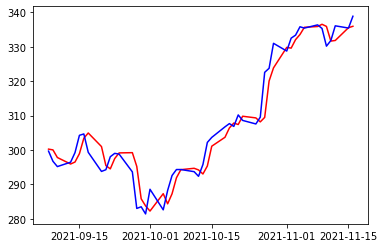

In [14]:
Y_test=Y_t.iloc[675:725]
Y_test=pd.DataFrame(Y_test)
predds_1=pd.DataFrame(predds_0, index=Y_test.index)
predds_1
plt.plot(predds_1, color='red')
plt.plot(Y_test, color='blue')

In [15]:
print(Errors_A[3].mean())
print(Errors_B[3].mean())
print(Errors_C[3].mean())

1.035962992110205
39.25626920897657
1.018074191406836


In [16]:
stock = web.get_data_yahoo("GOOGL",
start = "2019-01-01",
end = "2021-11-17")
y=stock['Adj Close']

Y_t=y.T
Y_t=Y_t.iloc[1:727]
Y_train=Y_t

model = pm.auto_arima(Y_train, start_p=3, start_q=3,start_d=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=6, max_q=6, max_d=2, # maximum p and q
                      m=1,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      #start_P=0, 
                      #D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

#ARIMA model
Errors_000=[]
predds=list()
n=675
for i in range(0,50):
    Y_train=Y_t.iloc[:n+i]
    Y_test=Y_t.iloc[n+i:n+1+i]
    
    arima_model = ARIMA(Y_train, order=model.order)
    arima_model_fit = arima_model.fit()
    preds_arima= arima_model_fit.forecast(len(Y_test),alpha=0.3)
    preds_arima=np.array(preds_arima)
    preds_atempt_1=preds_arima
    preds = pd.Series(preds_arima, index=Y_test.index)
    
    mse = mean_squared_error(Y_test, preds)
    rmse = sqrt(mean_squared_error(Y_test, preds))
    mae = mean_absolute_error(Y_test, preds)
    mape=MAPE(Y_test, preds)
    predds.append(preds_atempt_1)

    Error_i = ([mse, rmse, mae, mape])
    Errors_000.append(Error_i)
    Errors_A=pd.DataFrame(Errors_000)




#Garch model   
Errors_001=[]

for i in range(0,50):
    Y_train=Y_t.iloc[:n+i]
    Y_test=Y_t.iloc[n+i:n+1+i]

    garch = arch_model(Y_train, vol="Garch", p=1, q=1, dist="gaussian")
    garch_fitted = garch.fit()
    garch_forecast = garch_fitted.forecast(horizon=1)
    garch_pred_mean = garch_forecast.mean['h.1'].iloc[-1]
    preds = pd.DataFrame([garch_pred_mean])

    mse = mean_squared_error(Y_test, preds)
    rmse = sqrt(mean_squared_error(Y_test, preds))
    mae = mean_absolute_error(Y_test, preds)
    mape=MAPE(Y_test, preds)
    Error_i = ([mse, rmse, mae, mape])
    Errors_001.append(Error_i)
    Errors_B=pd.DataFrame(Errors_001)

    
#ARIMA-GARCH model  
Errors_002=[]
predds_0=list()
for i in range(0,50):
    Y_train=Y_t.iloc[:n+i]
    Y_test=Y_t.iloc[n+i:n+1+i]
    
    arima_model = ARIMA(Y_train, order=(model.order))
    arima_model_fit = arima_model.fit()
    arima_residuals = arima_model_fit.resid
    predicted_mu = arima_model_fit.forecast(len(Y_test))
    garch = arch_model(arima_residuals, vol="Garch", p=1, q=1, dist="gaussian")
    garch_fitted = garch.fit()
    garch_forecast = garch_fitted.forecast(horizon=1)
    garch_pred_mean = garch_forecast.mean['h.1'].iloc[-1]
    garch_pred_var = garch_forecast.variance['h.1'].iloc[-1]

    # Combine both models' output: yt = mu + et
    preds = predicted_mu + garch_pred_mean
    preds_0=np.array(preds)
    predds_0.append(preds_0)

    mse = mean_squared_error(Y_test, preds)
    rmse = sqrt(mean_squared_error(Y_test, preds))
    mae = mean_absolute_error(Y_test, preds)
    mape=MAPE(Y_test, preds)
    Error_i = ([mse, rmse, mae, mape])
    Errors_002.append(Error_i)
    Errors_C=pd.DataFrame(Errors_002)
    
    
# print(Errors_A[3].mean())
# print(Errors_B[3].mean())
# print(Errors_C[3].mean())

Performing stepwise search to minimize aic
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=6941.293, Time=1.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6964.352, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6956.646, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6957.000, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6968.302, Time=0.02 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=6959.613, Time=0.92 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=6951.273, Time=0.91 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.32 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=1.20 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6959.597, Time=0.62 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=6961.613, Time=0.97 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=6959.876, Time=1.05 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=6935.303, Time=1.23 sec
 ARIMA(5,1,4)(0,0,0)[0] intercept   : AIC=6937.207, Time=1.36 sec
 ARIMA(4,1,5)(0,0,0)[0] intercept   : AIC=6

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604:

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequenc

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequenc

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequenc

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequenc

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequenc

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequenc

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequenc

Iteration:      1,   Func. Count:      6,   Neg. LLF: 20341.722323883972
Iteration:      2,   Func. Count:     13,   Neg. LLF: 4807.29045551798
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4797.646098605217
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4749.080797550714
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4645.358824252474
Iteration:      6,   Func. Count:     33,   Neg. LLF: 4633.869893786588
Iteration:      7,   Func. Count:     38,   Neg. LLF: 4763.626157783188
Iteration:      8,   Func. Count:     44,   Neg. LLF: 5902.296674542584
Iteration:      9,   Func. Count:     51,   Neg. LLF: 4625.668320251656
Iteration:     10,   Func. Count:     57,   Neg. LLF: 4613.69512256123
Iteration:     11,   Func. Count:     62,   Neg. LLF: 4613.4633117781295
Iteration:     12,   Func. Count:     67,   Neg. LLF: 4612.847628016805
Iteration:     13,   Func. Count:     72,   Neg. LLF: 4612.837673886319
Iteration:     14,   Func. Count:     77,   Neg. LLF: 4612.83732

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.342e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:     40,   Func. Count:    218,   Neg. LLF: 4607.259487269371
Iteration:     41,   Func. Count:    223,   Neg. LLF: 4607.252768941061
Iteration:     42,   Func. Count:    228,   Neg. LLF: 4607.232742310077
Iteration:     43,   Func. Count:    233,   Neg. LLF: 4607.185126246746
Iteration:     44,   Func. Count:    238,   Neg. LLF: 4607.054413383184
Iteration:     45,   Func. Count:    243,   Neg. LLF: 4606.732978279628
Iteration:     46,   Func. Count:    248,   Neg. LLF: 4605.7338023141365
Iteration:     47,   Func. Count:    253,   Neg. LLF: 4602.173192833072
Iteration:     48,   Func. Count:    258,   Neg. LLF: 4589.624261945666
Iteration:     49,   Func. Count:    263,   Neg. LLF: 4600.075676455268
Iteration:     50,   Func. Count:    271,   Neg. LLF: 4583.886210560174
Iteration:     51,   Func. Count:    276,   Neg. LLF: 4580.941753702466
Iteration:     52,   Func. Count:    281,   Neg. LLF: 4580.833239037847
Iteration:     53,   Func. Count:    286,   Neg. LLF: 4580.8297

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.381e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:     16,   Func. Count:     87,   Neg. LLF: 4658.858731906066
Iteration:     17,   Func. Count:     92,   Neg. LLF: 4658.855024515881
Iteration:     18,   Func. Count:     97,   Neg. LLF: 4658.83555938541
Iteration:     19,   Func. Count:    102,   Neg. LLF: 4658.734955824602
Iteration:     20,   Func. Count:    107,   Neg. LLF: 4658.215747111464
Iteration:     21,   Func. Count:    112,   Neg. LLF: 4655.503134012152
Iteration:     22,   Func. Count:    117,   Neg. LLF: 4639.881748301316
Iteration:     23,   Func. Count:    122,   Neg. LLF: 4873.229503087555
Iteration:     24,   Func. Count:    128,   Neg. LLF: 4895.661577422064
Iteration:     25,   Func. Count:    134,   Neg. LLF: 4821.229453543016
Iteration:     26,   Func. Count:    140,   Neg. LLF: 4832.644916605766
Iteration:     27,   Func. Count:    146,   Neg. LLF: 4674.65643438601
Iteration:     28,   Func. Count:    152,   Neg. LLF: 4616.13565811939
Iteration:     29,   Func. Count:    157,   Neg. LLF: 4721.18641484

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.422e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:     12,   Func. Count:     67,   Neg. LLF: 4677.383695223965
Iteration:     13,   Func. Count:     72,   Neg. LLF: 4677.323992154876
Iteration:     14,   Func. Count:     77,   Neg. LLF: 4677.316500672284
Iteration:     15,   Func. Count:     82,   Neg. LLF: 4677.316395923011
Iteration:     16,   Func. Count:     87,   Neg. LLF: 4677.315911980141
Iteration:     17,   Func. Count:     92,   Neg. LLF: 4677.314799093844
Iteration:     18,   Func. Count:     97,   Neg. LLF: 4677.31173057752
Iteration:     19,   Func. Count:    102,   Neg. LLF: 4677.303951124292
Iteration:     20,   Func. Count:    107,   Neg. LLF: 4677.281712811086
Iteration:     21,   Func. Count:    112,   Neg. LLF: 4677.224701497128
Iteration:     22,   Func. Count:    117,   Neg. LLF: 4677.085194004083
Iteration:     23,   Func. Count:    122,   Neg. LLF: 4676.698471869855
Iteration:     24,   Func. Count:    127,   Neg. LLF: 4675.647977605521
Iteration:     25,   Func. Count:    132,   Neg. LLF: 4673.054489

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.46e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this 

Iteration:      1,   Func. Count:      6,   Neg. LLF: 20638.362589139913
Iteration:      2,   Func. Count:     13,   Neg. LLF: 4907.233459702097
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4898.74242592685
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4853.444892302947
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4729.42108374596
Iteration:      6,   Func. Count:     33,   Neg. LLF: 4718.618460806358
Iteration:      7,   Func. Count:     38,   Neg. LLF: 4778.8395117658565
Iteration:      8,   Func. Count:     44,   Neg. LLF: 5929.12274016614
Iteration:      9,   Func. Count:     51,   Neg. LLF: 4703.956309658149
Iteration:     10,   Func. Count:     57,   Neg. LLF: 4696.465620061733
Iteration:     11,   Func. Count:     62,   Neg. LLF: 4696.157032247293
Iteration:     12,   Func. Count:     67,   Neg. LLF: 4695.627321952239
Iteration:     13,   Func. Count:     72,   Neg. LLF: 4695.53753020299
Iteration:     14,   Func. Count:     77,   Neg. LLF: 4695.5241654

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.494e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Optimization terminated successfully    (Exit mode 0)
            Current function value: 4642.582229210897
            Iterations: 43
            Function evaluations: 235
            Gradient evaluations: 43
Iteration:      1,   Func. Count:      6,   Neg. LLF: 20703.425657869982
Iteration:      2,   Func. Count:     13,   Neg. LLF: 4928.802850646967
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4920.621574933665
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4876.56627764434
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4748.449645449138
Iteration:      6,   Func. Count:     33,   Neg. LLF: 4737.911977126472
Iteration:      7,   Func. Count:     38,   Neg. LLF: 4784.016734725999
Iteration:      8,   Func. Count:     44,   Neg. LLF: 5932.720212030266
Iteration:      9,   Func. Count:     51,   Neg. LLF: 4720.272984026946
Iteration:     10,   Func. Count:     57,   Neg. LLF: 4714.666441161291
Iteration:     11,   Func. Count:     62,   Neg. LLF: 4714.28165020313

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.529e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:     35,   Func. Count:    189,   Neg. LLF: 4775.013813335101
Iteration:     36,   Func. Count:    195,   Neg. LLF: 4934.611627135246
Iteration:     37,   Func. Count:    201,   Neg. LLF: 4678.885592989664
Iteration:     38,   Func. Count:    207,   Neg. LLF: 4683.98783586176
Iteration:     39,   Func. Count:    213,   Neg. LLF: 4683.941663596104
Iteration:     40,   Func. Count:    219,   Neg. LLF: 4681.653740216561
Iteration:     41,   Func. Count:    225,   Neg. LLF: 4678.721316104825
Iteration:     42,   Func. Count:    231,   Neg. LLF: 4676.222074328141
Iteration:     43,   Func. Count:    237,   Neg. LLF: 4667.578928019771
Iteration:     44,   Func. Count:    243,   Neg. LLF: 4661.366641040215
Iteration:     45,   Func. Count:    249,   Neg. LLF: 4660.3172654412165
Iteration:     46,   Func. Count:    254,   Neg. LLF: 4660.249847220789
Iteration:     47,   Func. Count:    259,   Neg. LLF: 4660.207678380439
Iteration:     48,   Func. Count:    264,   Neg. LLF: 4660.21377

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.566e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:     31,   Func. Count:    166,   Neg. LLF: 5243.578635002913
Iteration:     32,   Func. Count:    172,   Neg. LLF: 8946.047888643332
Iteration:     33,   Func. Count:    178,   Neg. LLF: 4785.891786591957
Iteration:     34,   Func. Count:    184,   Neg. LLF: 4818.847689022984
Iteration:     35,   Func. Count:    190,   Neg. LLF: 15813.097165079891
Iteration:     36,   Func. Count:    196,   Neg. LLF: 4725.804133317662
Iteration:     37,   Func. Count:    202,   Neg. LLF: 4725.793015247211
Iteration:     38,   Func. Count:    208,   Neg. LLF: 4853.575012012088
Iteration:     39,   Func. Count:    214,   Neg. LLF: 4714.270289574943
Iteration:     40,   Func. Count:    220,   Neg. LLF: 4759.126662019456
Iteration:     41,   Func. Count:    226,   Neg. LLF: 4858.707532583723
Iteration:     42,   Func. Count:    232,   Neg. LLF: 4764.7382605125695
Iteration:     43,   Func. Count:    238,   Neg. LLF: 4690.990925441238
Iteration:     44,   Func. Count:    244,   Neg. LLF: 4681.061

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.593e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:     20,   Func. Count:    107,   Neg. LLF: 4759.00181229219
Iteration:     21,   Func. Count:    112,   Neg. LLF: 4758.914486131954
Iteration:     22,   Func. Count:    117,   Neg. LLF: 4758.696597339884
Iteration:     23,   Func. Count:    122,   Neg. LLF: 4758.061039479375
Iteration:     24,   Func. Count:    127,   Neg. LLF: 4756.594441605132
Iteration:     25,   Func. Count:    132,   Neg. LLF: 4752.919123593179
Iteration:     26,   Func. Count:    137,   Neg. LLF: 4744.253222098863
Iteration:     27,   Func. Count:    142,   Neg. LLF: 4748.409577259938
Iteration:     28,   Func. Count:    148,   Neg. LLF: 4760.433521969134
Iteration:     29,   Func. Count:    154,   Neg. LLF: 5978.297490004296
Iteration:     30,   Func. Count:    160,   Neg. LLF: 4746.403738060876
Iteration:     31,   Func. Count:    166,   Neg. LLF: 4942.1272860990775
Iteration:     32,   Func. Count:    172,   Neg. LLF: 4729.374482348822
Iteration:     33,   Func. Count:    178,   Neg. LLF: 4723.66089

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.62e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this 

Iteration:     13,   Func. Count:     72,   Neg. LLF: 4776.980871132619
Iteration:     14,   Func. Count:     77,   Neg. LLF: 4776.980677960969
Iteration:     15,   Func. Count:     82,   Neg. LLF: 4776.980545262326
Iteration:     16,   Func. Count:     87,   Neg. LLF: 4776.979890093406
Iteration:     17,   Func. Count:     92,   Neg. LLF: 4776.978336773611
Iteration:     18,   Func. Count:     97,   Neg. LLF: 4776.974512898079
Iteration:     19,   Func. Count:    102,   Neg. LLF: 4776.963951130183
Iteration:     20,   Func. Count:    107,   Neg. LLF: 4776.934495441315
Iteration:     21,   Func. Count:    112,   Neg. LLF: 4776.862327135809
Iteration:     22,   Func. Count:    117,   Neg. LLF: 4776.6629787378015
Iteration:     23,   Func. Count:    122,   Neg. LLF: 4776.181368112775
Iteration:     24,   Func. Count:    127,   Neg. LLF: 4774.572472873786
Iteration:     25,   Func. Count:    132,   Neg. LLF: 4769.93306572481
Iteration:     26,   Func. Count:    137,   Neg. LLF: 4759.95807

C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.646e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the opt

Iteration:     24,   Func. Count:    126,   Neg. LLF: 4793.977886202372
Iteration:     25,   Func. Count:    131,   Neg. LLF: 4792.512121325225
Iteration:     26,   Func. Count:    136,   Neg. LLF: 4787.6230277475515
Iteration:     27,   Func. Count:    141,   Neg. LLF: 4776.486596804125
Iteration:     28,   Func. Count:    146,   Neg. LLF: 4857.706103278998
Iteration:     29,   Func. Count:    152,   Neg. LLF: 4785.973769905193
Iteration:     30,   Func. Count:    158,   Neg. LLF: 4791.924973903174
Iteration:     31,   Func. Count:    164,   Neg. LLF: 4788.9925028312655
Iteration:     32,   Func. Count:    170,   Neg. LLF: 4746.320146942246
Iteration:     33,   Func. Count:    176,   Neg. LLF: 4736.242643868271
Iteration:     34,   Func. Count:    181,   Neg. LLF: 4736.018469110408
Iteration:     35,   Func. Count:    187,   Neg. LLF: 4731.776297019776
Iteration:     36,   Func. Count:    192,   Neg. LLF: 4730.674816350507
Iteration:     37,   Func. Count:    197,   Neg. LLF: 4730.493

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.692e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:      6,   Func. Count:     33,   Neg. LLF: 4860.232661900887
Iteration:      7,   Func. Count:     38,   Neg. LLF: 4832.469334679157
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4838.440705174213
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4832.109534020428
Iteration:     10,   Func. Count:     54,   Neg. LLF: 4831.353484065685
Iteration:     11,   Func. Count:     59,   Neg. LLF: 4831.063688497677
Iteration:     12,   Func. Count:     64,   Neg. LLF: 4831.050880514229
Iteration:     13,   Func. Count:     69,   Neg. LLF: 4831.050347731978
Iteration:     14,   Func. Count:     74,   Neg. LLF: 4831.050243533351
Iteration:     15,   Func. Count:     79,   Neg. LLF: 4831.049760898875
Iteration:     16,   Func. Count:     84,   Neg. LLF: 4831.048871845596
Iteration:     17,   Func. Count:     89,   Neg. LLF: 4831.045621042999
Iteration:     18,   Func. Count:     94,   Neg. LLF: 4831.038831726324
Iteration:     19,   Func. Count:     99,   Neg. LLF: 4831.01745

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.721e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:     51,   Func. Count:    281,   Neg. LLF: 4774.171657458931
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4774.171655699232
            Iterations: 51
            Function evaluations: 282
            Gradient evaluations: 51
Iteration:      1,   Func. Count:      6,   Neg. LLF: 21186.080122468033
Iteration:      2,   Func. Count:     13,   Neg. LLF: 5085.3337845133965
Iteration:      3,   Func. Count:     18,   Neg. LLF: 5079.847266441489
Iteration:      4,   Func. Count:     23,   Neg. LLF: 5049.435438046506
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4899.9542402074385
Iteration:      6,   Func. Count:     33,   Neg. LLF: 4874.687543370735
Iteration:      7,   Func. Count:     38,   Neg. LLF: 4852.788867420764
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5289.059598604529
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4850.195835502469
Iteration:     10,   Func. Count:     54,   Neg. LLF: 4849.92918499

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.752e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:     34,   Func. Count:    183,   Neg. LLF: 4836.553433975736
Iteration:     35,   Func. Count:    189,   Neg. LLF: 4793.462671198882
Iteration:     36,   Func. Count:    194,   Neg. LLF: 4854.59125769174
Iteration:     37,   Func. Count:    200,   Neg. LLF: 4793.3219167764255
Iteration:     38,   Func. Count:    206,   Neg. LLF: 4792.999972961228
Iteration:     39,   Func. Count:    211,   Neg. LLF: 4792.562066669963
Iteration:     40,   Func. Count:    216,   Neg. LLF: 4793.104558270598
Iteration:     41,   Func. Count:    222,   Neg. LLF: 4791.938020782388
Iteration:     42,   Func. Count:    227,   Neg. LLF: 4791.801534294536
Iteration:     43,   Func. Count:    232,   Neg. LLF: 4791.765950170506
Iteration:     44,   Func. Count:    237,   Neg. LLF: 4791.758352957019
Iteration:     45,   Func. Count:    242,   Neg. LLF: 4791.757966833062
Iteration:     46,   Func. Count:    247,   Neg. LLF: 4791.757915216551
Iteration:     47,   Func. Count:    252,   Neg. LLF: 4791.75791

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.786e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:     22,   Func. Count:    114,   Neg. LLF: 4875.741157317478
Iteration:     23,   Func. Count:    119,   Neg. LLF: 4874.8798309861195
Iteration:     24,   Func. Count:    124,   Neg. LLF: 4872.273785718305
Iteration:     25,   Func. Count:    129,   Neg. LLF: 4866.600743792145
Iteration:     26,   Func. Count:    134,   Neg. LLF: 5303.268274500386
Iteration:     27,   Func. Count:    140,   Neg. LLF: 5908.706275386533
Iteration:     28,   Func. Count:    146,   Neg. LLF: 5674.881044135451
Iteration:     29,   Func. Count:    152,   Neg. LLF: 5317.993517700059
Iteration:     30,   Func. Count:    158,   Neg. LLF: 5272.518628916434
Iteration:     31,   Func. Count:    164,   Neg. LLF: 6524.067701826643
Iteration:     32,   Func. Count:    170,   Neg. LLF: 7929.251240503923
Iteration:     33,   Func. Count:    176,   Neg. LLF: 5098.575260912699
Iteration:     34,   Func. Count:    182,   Neg. LLF: 4916.24710294885
Iteration:     35,   Func. Count:    188,   Neg. LLF: 5051.98255

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.82e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this 

Iteration:      8,   Func. Count:     44,   Neg. LLF: 4896.088343497411
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4895.111180429771
Iteration:     10,   Func. Count:     54,   Neg. LLF: 4894.577553819767
Iteration:     11,   Func. Count:     59,   Neg. LLF: 4894.540995136853
Iteration:     12,   Func. Count:     64,   Neg. LLF: 4894.540277839539
Iteration:     13,   Func. Count:     69,   Neg. LLF: 4894.540191471306
Iteration:     14,   Func. Count:     74,   Neg. LLF: 4894.53962849812
Iteration:     15,   Func. Count:     79,   Neg. LLF: 4894.536238432814
Iteration:     16,   Func. Count:     84,   Neg. LLF: 4894.5189154636555
Iteration:     17,   Func. Count:     89,   Neg. LLF: 4894.487412573467
Iteration:     18,   Func. Count:     94,   Neg. LLF: 4894.412796412999
Iteration:     19,   Func. Count:     99,   Neg. LLF: 4894.153191047288
Iteration:     20,   Func. Count:    104,   Neg. LLF: 4893.6273582720805
Iteration:     21,   Func. Count:    109,   Neg. LLF: 4891.5435

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.85e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this 

Iteration:      2,   Func. Count:     13,   Neg. LLF: 5157.63538149275
Iteration:      3,   Func. Count:     18,   Neg. LLF: 5153.464946132122
Iteration:      4,   Func. Count:     23,   Neg. LLF: 5130.448069352383
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4990.639693521953
Iteration:      6,   Func. Count:     33,   Neg. LLF: 5011.444736089919
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4915.945453715016
Iteration:      8,   Func. Count:     44,   Neg. LLF: 5005.943302137408
Iteration:      9,   Func. Count:     50,   Neg. LLF: 4914.01688787167
Iteration:     10,   Func. Count:     55,   Neg. LLF: 4913.793758933341
Iteration:     11,   Func. Count:     60,   Neg. LLF: 4912.933169591078
Iteration:     12,   Func. Count:     65,   Neg. LLF: 4912.618871134982
Iteration:     13,   Func. Count:     70,   Neg. LLF: 4912.604402097822
Iteration:     14,   Func. Count:     75,   Neg. LLF: 4912.604196130901
Iteration:     15,   Func. Count:     80,   Neg. LLF: 4912.6040854

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.878e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:     33,   Func. Count:    174,   Neg. LLF: 5073.258937189001
Iteration:     34,   Func. Count:    180,   Neg. LLF: 5093.134267917938
Iteration:     35,   Func. Count:    186,   Neg. LLF: 5075.2148638689805
Iteration:     36,   Func. Count:    192,   Neg. LLF: 4894.050638894028
Iteration:     37,   Func. Count:    198,   Neg. LLF: 4899.411880673957
Iteration:     38,   Func. Count:    204,   Neg. LLF: 4892.1726426624855
Iteration:     39,   Func. Count:    210,   Neg. LLF: 4893.756013102646
Iteration:     40,   Func. Count:    216,   Neg. LLF: 4891.727910977675
Iteration:     41,   Func. Count:    221,   Neg. LLF: 4891.726951718048
Iteration:     42,   Func. Count:    226,   Neg. LLF: 4891.721477609388
Iteration:     43,   Func. Count:    231,   Neg. LLF: 4891.7007371897525
Iteration:     44,   Func. Count:    236,   Neg. LLF: 4891.685856009784
Iteration:     45,   Func. Count:    241,   Neg. LLF: 4891.685496535807
Iteration:     46,   Func. Count:    246,   Neg. LLF: 4891.68

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.916e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:     15,   Func. Count:     81,   Neg. LLF: 4958.194983449967
Iteration:     16,   Func. Count:     86,   Neg. LLF: 4958.194498232029
Iteration:     17,   Func. Count:     91,   Neg. LLF: 4958.191908674425
Iteration:     18,   Func. Count:     96,   Neg. LLF: 4958.177974737385
Iteration:     19,   Func. Count:    101,   Neg. LLF: 4958.103787108559
Iteration:     20,   Func. Count:    106,   Neg. LLF: 4957.710670981238
Iteration:     21,   Func. Count:    111,   Neg. LLF: 4955.616637623065
Iteration:     22,   Func. Count:    116,   Neg. LLF: 4943.724196598347
Iteration:     23,   Func. Count:    121,   Neg. LLF: 5661.183011490515
Iteration:     24,   Func. Count:    127,   Neg. LLF: 6889.4715331138095
Iteration:     25,   Func. Count:    133,   Neg. LLF: 6804.683732541329
Iteration:     26,   Func. Count:    139,   Neg. LLF: 6937.948259652167
Iteration:     27,   Func. Count:    145,   Neg. LLF: 5293.372055036865
Iteration:     28,   Func. Count:    151,   Neg. LLF: 4928.3100

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.953e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:     48,   Func. Count:    266,   Neg. LLF: 4900.101920629511
Iteration:     49,   Func. Count:    271,   Neg. LLF: 4920.584636226208
Iteration:     50,   Func. Count:    277,   Neg. LLF: 4898.92919084901
Iteration:     51,   Func. Count:    282,   Neg. LLF: 4905.919789840527
Iteration:     52,   Func. Count:    288,   Neg. LLF: 4902.4523174588585
Iteration:     53,   Func. Count:    294,   Neg. LLF: 4897.819765298289
Iteration:     54,   Func. Count:    299,   Neg. LLF: 4897.764055601336
Iteration:     55,   Func. Count:    304,   Neg. LLF: 4897.74506948565
Iteration:     56,   Func. Count:    309,   Neg. LLF: 4897.732680530302
Iteration:     57,   Func. Count:    314,   Neg. LLF: 4897.732310280371
Iteration:     58,   Func. Count:    319,   Neg. LLF: 4897.73230564097
Iteration:     59,   Func. Count:    324,   Neg. LLF: 4897.735764174704
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4897.732304756175
            Iterations: 59
   

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.99e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this 

Iteration:     26,   Func. Count:    136,   Neg. LLF: 4979.920690549399
Iteration:     27,   Func. Count:    141,   Neg. LLF: 6124.547572449745
Iteration:     28,   Func. Count:    147,   Neg. LLF: 6230.326851559556
Iteration:     29,   Func. Count:    153,   Neg. LLF: 6099.399850873607
Iteration:     30,   Func. Count:    159,   Neg. LLF: 6070.44876881796
Iteration:     31,   Func. Count:    165,   Neg. LLF: 6074.667301865553
Iteration:     32,   Func. Count:    171,   Neg. LLF: 5825.553010361946
Iteration:     33,   Func. Count:    177,   Neg. LLF: 6927.6531789051505
Iteration:     34,   Func. Count:    183,   Neg. LLF: 4957.42650486043
Iteration:     35,   Func. Count:    189,   Neg. LLF: 5196.753299583375
Iteration:     36,   Func. Count:    195,   Neg. LLF: 4984.681839744195
Iteration:     37,   Func. Count:    201,   Neg. LLF: 5199.272307658197
Iteration:     38,   Func. Count:    207,   Neg. LLF: 5039.664970973658
Iteration:     39,   Func. Count:    213,   Neg. LLF: 5077.851699

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.03e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this 

Iteration:     11,   Func. Count:     61,   Neg. LLF: 5005.206973830562
Iteration:     12,   Func. Count:     66,   Neg. LLF: 5004.836442718512
Iteration:     13,   Func. Count:     71,   Neg. LLF: 5004.4148213700955
Iteration:     14,   Func. Count:     76,   Neg. LLF: 5004.108770986095
Iteration:     15,   Func. Count:     81,   Neg. LLF: 5004.065674270019
Iteration:     16,   Func. Count:     86,   Neg. LLF: 5004.062018832041
Iteration:     17,   Func. Count:     91,   Neg. LLF: 5004.061941817919
Iteration:     18,   Func. Count:     96,   Neg. LLF: 5004.061509635519
Iteration:     19,   Func. Count:    101,   Neg. LLF: 5004.058764439671
Iteration:     20,   Func. Count:    106,   Neg. LLF: 5004.048919564748
Iteration:     21,   Func. Count:    111,   Neg. LLF: 5004.032724817052
Iteration:     22,   Func. Count:    116,   Neg. LLF: 5003.9780832246815
Iteration:     23,   Func. Count:    121,   Neg. LLF: 5003.857002154067
Iteration:     24,   Func. Count:    126,   Neg. LLF: 5003.517

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.07e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this 

Iteration:     23,   Func. Count:    121,   Neg. LLF: 5031.23961736849
Iteration:     24,   Func. Count:    126,   Neg. LLF: 5030.623669158544
Iteration:     25,   Func. Count:    131,   Neg. LLF: 5028.759514602011
Iteration:     26,   Func. Count:    136,   Neg. LLF: 5023.0889456001405
Iteration:     27,   Func. Count:    141,   Neg. LLF: 5025.133964490671
Iteration:     28,   Func. Count:    147,   Neg. LLF: 7172.143765969043
Iteration:     29,   Func. Count:    153,   Neg. LLF: 8559.977900715046
Iteration:     30,   Func. Count:    159,   Neg. LLF: 6198.958342368924
Iteration:     31,   Func. Count:    165,   Neg. LLF: 5300.135455322656
Iteration:     32,   Func. Count:    171,   Neg. LLF: 5092.80527591147
Iteration:     33,   Func. Count:    177,   Neg. LLF: 5106.846988408599
Iteration:     34,   Func. Count:    183,   Neg. LLF: 5066.459844029068
Iteration:     35,   Func. Count:    189,   Neg. LLF: 5023.233955560838
Iteration:     36,   Func. Count:    195,   Neg. LLF: 5015.675686

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.105e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:      7,   Func. Count:     39,   Neg. LLF: 5060.670490250709
Iteration:      8,   Func. Count:     44,   Neg. LLF: 5277.0880345178
Iteration:      9,   Func. Count:     50,   Neg. LLF: 5266.637491563336
Iteration:     10,   Func. Count:     56,   Neg. LLF: 5052.195515889642
Iteration:     11,   Func. Count:     62,   Neg. LLF: 5051.157377579023
Iteration:     12,   Func. Count:     67,   Neg. LLF: 5050.3094117191595
Iteration:     13,   Func. Count:     72,   Neg. LLF: 5049.991694493956
Iteration:     14,   Func. Count:     77,   Neg. LLF: 5049.976857296235
Iteration:     15,   Func. Count:     82,   Neg. LLF: 5049.976649211637
Iteration:     16,   Func. Count:     87,   Neg. LLF: 5049.976556133602
Iteration:     17,   Func. Count:     92,   Neg. LLF: 5049.97602437236
Iteration:     18,   Func. Count:     97,   Neg. LLF: 5049.974857087051
Iteration:     19,   Func. Count:    102,   Neg. LLF: 5049.970913001351
Iteration:     20,   Func. Count:    107,   Neg. LLF: 5049.9623274

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.143e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:      1,   Func. Count:      6,   Neg. LLF: 18823.72221978382
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3286.969762054194
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3188.321881899443
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3200.5804149752894
Iteration:      5,   Func. Count:     31,   Neg. LLF: 3186.35007856076
Iteration:      6,   Func. Count:     36,   Neg. LLF: 3184.4710938426797
Iteration:      7,   Func. Count:     41,   Neg. LLF: 3179.928954773467
Iteration:      8,   Func. Count:     46,   Neg. LLF: 3177.0310349082374
Iteration:      9,   Func. Count:     51,   Neg. LLF: 3175.2908221619728
Iteration:     10,   Func. Count:     56,   Neg. LLF: 3174.93617564579
Iteration:     11,   Func. Count:     61,   Neg. LLF: 3174.883824135774
Iteration:     12,   Func. Count:     66,   Neg. LLF: 3174.8600988516664
Iteration:     13,   Func. Count:     71,   Neg. LLF: 3174.85158576527
Iteration:     14,   Func. Count:     76,   Neg. LLF: 3174.849

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 18852.84318905033
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3300.6609218875215
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3189.9769821528766
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3207.2724157446173
Iteration:      5,   Func. Count:     31,   Neg. LLF: 3188.077807938054
Iteration:      6,   Func. Count:     36,   Neg. LLF: 3186.427825878566
Iteration:      7,   Func. Count:     41,   Neg. LLF: 3183.0215285171603
Iteration:      8,   Func. Count:     46,   Neg. LLF: 3180.0902609329805
Iteration:      9,   Func. Count:     51,   Neg. LLF: 3177.6020414314394
Iteration:     10,   Func. Count:     56,   Neg. LLF: 3176.7394407968277
Iteration:     11,   Func. Count:     61,   Neg. LLF: 3176.66494572954
Iteration:     12,   Func. Count:     66,   Neg. LLF: 3176.6467057227937
Iteration:     13,   Func. Count:     71,   Neg. LLF: 3176.6368698599063
Iteration:     14,   Func. Count:     76,   Neg. LLF: 31

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 18870.638123980592
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3300.3124630181146
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3195.709462737628
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3205.8704471900064
Iteration:      5,   Func. Count:     31,   Neg. LLF: 3194.206452538695
Iteration:      6,   Func. Count:     36,   Neg. LLF: 3192.1587515381643
Iteration:      7,   Func. Count:     41,   Neg. LLF: 3187.1178942016186
Iteration:      8,   Func. Count:     46,   Neg. LLF: 3184.063656818446
Iteration:      9,   Func. Count:     51,   Neg. LLF: 3182.2236012339663
Iteration:     10,   Func. Count:     56,   Neg. LLF: 3181.898700871073
Iteration:     11,   Func. Count:     61,   Neg. LLF: 3181.8350641498096
Iteration:     12,   Func. Count:     66,   Neg. LLF: 3181.798968368461
Iteration:     13,   Func. Count:     71,   Neg. LLF: 3181.791719443173
Iteration:     14,   Func. Count:     76,   Neg. LLF: 318

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 18885.821761925516
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3313.950914804491
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3400.4730103745887
Iteration:      4,   Func. Count:     26,   Neg. LLF: 3202.177305627705
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3199.1742478310402
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3197.5167314669848
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3192.5594496074687
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3189.322683475184
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3187.6449054080053
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3187.088861490472
Iteration:     11,   Func. Count:     62,   Neg. LLF: 3186.975272343118
Iteration:     12,   Func. Count:     67,   Neg. LLF: 3186.937291496646
Iteration:     13,   Func. Count:     72,   Neg. LLF: 3186.9271620719765
Iteration:     14,   Func. Count:     77,   Neg. LLF: 318

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 18915.258094500095
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3329.422498399389
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3405.4783178819575
Iteration:      4,   Func. Count:     26,   Neg. LLF: 3208.671316129987
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3203.8393176723707
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3202.3272357306796
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3197.623358041065
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3194.1991392458135
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3192.475777787964
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3191.85370317696
Iteration:     11,   Func. Count:     62,   Neg. LLF: 3191.730078576084
Iteration:     12,   Func. Count:     67,   Neg. LLF: 3191.691298754272
Iteration:     13,   Func. Count:     72,   Neg. LLF: 3191.680423758389
Iteration:     14,   Func. Count:     77,   Neg. LLF: 3191.6

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 18942.160153691217
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3337.2102164629346
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3410.0801939447797
Iteration:      4,   Func. Count:     26,   Neg. LLF: 3213.6867050903966
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3208.155480363298
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3206.624847510472
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3201.8705009084197
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3198.4213630702875
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3196.6760641591563
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3196.0464830702927
Iteration:     11,   Func. Count:     62,   Neg. LLF: 3195.9206145926178
Iteration:     12,   Func. Count:     67,   Neg. LLF: 3195.8810646267284
Iteration:     13,   Func. Count:     72,   Neg. LLF: 3195.8697736171584
Iteration:     14,   Func. Count:     77,   Neg. LLF:

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 18973.369834743375
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3355.5677927681877
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3415.0587613481375
Iteration:      4,   Func. Count:     26,   Neg. LLF: 3222.99254015741
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3212.887203556867
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3211.5367160974383
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3207.137989437312
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3203.464734036505
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3201.671318959885
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3200.973472895257
Iteration:     11,   Func. Count:     62,   Neg. LLF: 3200.833368889024
Iteration:     12,   Func. Count:     67,   Neg. LLF: 3200.7917736218055
Iteration:     13,   Func. Count:     72,   Neg. LLF: 3200.7797956472923
Iteration:     14,   Func. Count:     77,   Neg. LLF: 3200.

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19003.16377459965
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3354.1855987664103
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3420.67388237913
Iteration:      4,   Func. Count:     26,   Neg. LLF: 3224.6441742315283
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3217.263298281461
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3215.9216169622205
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3211.5733293643075
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3208.0099312945104
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3206.287864422751
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3205.620106022011
Iteration:     11,   Func. Count:     62,   Neg. LLF: 3205.4889562865465
Iteration:     12,   Func. Count:     67,   Neg. LLF: 3205.4513383190324
Iteration:     13,   Func. Count:     72,   Neg. LLF: 3205.4404581332988
Iteration:     14,   Func. Count:     77,   Neg. LLF: 320

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19047.486323753063
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3389.6885698697624
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3225.516986839967
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3538.429202004301
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3224.39125814802
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3223.3823240380516
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3222.086494746958
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3218.845264960312
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3215.7185841126834
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3213.679095957244
Iteration:     11,   Func. Count:     62,   Neg. LLF: 3213.2457764104297
Iteration:     12,   Func. Count:     67,   Neg. LLF: 3213.2248027479495
Iteration:     13,   Func. Count:     72,   Neg. LLF: 3213.2203312144293
Iteration:     14,   Func. Count:     77,   Neg. LLF: 3213

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19074.18411311908
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3377.3340645687263
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3230.5584978653224
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3276.6825934411963
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3229.401796287733
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3228.245088231955
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3226.652357908836
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3223.4549806211126
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3220.3746579774865
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3218.5146490909347
Iteration:     11,   Func. Count:     62,   Neg. LLF: 3218.1961693172916
Iteration:     12,   Func. Count:     67,   Neg. LLF: 3218.180940715311
Iteration:     13,   Func. Count:     72,   Neg. LLF: 3218.1767943248224
Iteration:     14,   Func. Count:     77,   Neg. LLF: 32

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19093.13540562936
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3398.8610133351795
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3234.7899547205457
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3411.7960903665353
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3233.936842462801
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3232.8042988562684
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3231.2164513009857
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3228.0858940976714
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3224.9291567333
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3222.932031006985
Iteration:     11,   Func. Count:     62,   Neg. LLF: 3222.5006214293644
Iteration:     12,   Func. Count:     67,   Neg. LLF: 3222.4746425541125
Iteration:     13,   Func. Count:     72,   Neg. LLF: 3222.469877893373
Iteration:     14,   Func. Count:     77,   Neg. LLF: 3222

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19116.40618376407
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3414.6309929977833
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3239.3707008144434
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3561.9053939078094
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3238.532163239243
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3237.2763774567948
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3235.044149237543
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3231.9197568726686
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3228.617040648789
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3226.7010498013287
Iteration:     11,   Func. Count:     62,   Neg. LLF: 3226.368310119651
Iteration:     12,   Func. Count:     67,   Neg. LLF: 3226.342154739183
Iteration:     13,   Func. Count:     72,   Neg. LLF: 3226.3367483925595
Iteration:     14,   Func. Count:     77,   Neg. LLF: 322

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19144.826514770426
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3441.878937034812
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3244.114332063563
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3542.357612506463
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3243.293903541372
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3242.072606001404
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3239.993697977171
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3236.8569880825653
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3233.457706590434
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3231.391367213935
Iteration:     11,   Func. Count:     62,   Neg. LLF: 3230.9909604348018
Iteration:     12,   Func. Count:     67,   Neg. LLF: 3230.9571102203336
Iteration:     13,   Func. Count:     72,   Neg. LLF: 3230.950995892962
Iteration:     14,   Func. Count:     77,   Neg. LLF: 3230.9

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19175.28537207428
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3465.9455048802265
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3247.847520921104
Iteration:      4,   Func. Count:     24,   Neg. LLF: 3496.920142471062
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3247.144656279527
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3246.8324949325734
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3246.491112275784
Iteration:      8,   Func. Count:     45,   Neg. LLF: 3244.616625741689
Iteration:      9,   Func. Count:     50,   Neg. LLF: 3239.286061815128
Iteration:     10,   Func. Count:     55,   Neg. LLF: 3236.5830263278485
Iteration:     11,   Func. Count:     60,   Neg. LLF: 3235.2548757579834
Iteration:     12,   Func. Count:     65,   Neg. LLF: 3234.866269458714
Iteration:     13,   Func. Count:     70,   Neg. LLF: 3234.7273366623085
Iteration:     14,   Func. Count:     75,   Neg. LLF: 3234.

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19201.662953041112
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3461.0031154520375
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3252.583682244354
Iteration:      4,   Func. Count:     24,   Neg. LLF: 3505.3927162883374
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3251.875962187753
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3251.570974960149
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3251.2142053531097
Iteration:      8,   Func. Count:     45,   Neg. LLF: 3249.334222484071
Iteration:      9,   Func. Count:     50,   Neg. LLF: 3244.0186283973953
Iteration:     10,   Func. Count:     55,   Neg. LLF: 3241.269795479696
Iteration:     11,   Func. Count:     60,   Neg. LLF: 3239.9393020671587
Iteration:     12,   Func. Count:     65,   Neg. LLF: 3239.556857020808
Iteration:     13,   Func. Count:     70,   Neg. LLF: 3239.4235800255665
Iteration:     14,   Func. Count:     75,   Neg. LLF: 323

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19215.216487966914
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3411.8407295028487
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3265.4552568819154
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3318.992753795633
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3264.7427705427804
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3263.6076346001255
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3262.1565840710937
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3258.975970605574
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3256.136641088458
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3254.3840558705697
Iteration:     11,   Func. Count:     62,   Neg. LLF: 3253.9203654562475
Iteration:     12,   Func. Count:     67,   Neg. LLF: 3253.888561171674
Iteration:     13,   Func. Count:     72,   Neg. LLF: 3253.88352381557
Iteration:     14,   Func. Count:     77,   Neg. LLF: 325

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19238.90953368562
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3402.006332560323
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3270.9398746445804
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3295.886673038488
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3270.1738631384733
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3268.820981455185
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3266.259505196578
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3263.361447105258
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3260.7534570587604
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3259.3671238453735
Iteration:     11,   Func. Count:     62,   Neg. LLF: 3259.103595250551
Iteration:     12,   Func. Count:     67,   Neg. LLF: 3259.0874719123367
Iteration:     13,   Func. Count:     72,   Neg. LLF: 3259.083395933829
Iteration:     14,   Func. Count:     77,   Neg. LLF: 3259.

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19265.949531104878
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3403.136260445123
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3276.0467527223723
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3305.1774927429497
Iteration:      5,   Func. Count:     31,   Neg. LLF: 3275.1902774615755
Iteration:      6,   Func. Count:     36,   Neg. LLF: 3274.34007460038
Iteration:      7,   Func. Count:     41,   Neg. LLF: 3272.893054770962
Iteration:      8,   Func. Count:     46,   Neg. LLF: 3270.286166665571
Iteration:      9,   Func. Count:     51,   Neg. LLF: 3267.2765972144625
Iteration:     10,   Func. Count:     56,   Neg. LLF: 3264.9626973261106
Iteration:     11,   Func. Count:     61,   Neg. LLF: 3264.2105490587564
Iteration:     12,   Func. Count:     66,   Neg. LLF: 3264.1283851681874
Iteration:     13,   Func. Count:     71,   Neg. LLF: 3264.1110218949325
Iteration:     14,   Func. Count:     76,   Neg. LLF: 32

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19296.954251326177
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3431.8875010642964
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3280.91934285339
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3420.640194286597
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3280.1286759140744
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3278.9522259647265
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3277.263681850952
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3274.2133127910593
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3271.3834348537507
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3269.653161751481
Iteration:     11,   Func. Count:     62,   Neg. LLF: 3269.1590623626234
Iteration:     12,   Func. Count:     67,   Neg. LLF: 3269.127860753764
Iteration:     13,   Func. Count:     72,   Neg. LLF: 3269.123309295453
Iteration:     14,   Func. Count:     77,   Neg. LLF: 3269

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19321.76985511947
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3409.478918231128
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3286.510014820199
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3307.808643457885
Iteration:      5,   Func. Count:     31,   Neg. LLF: 3285.6418102192997
Iteration:      6,   Func. Count:     36,   Neg. LLF: 3284.5756765359956
Iteration:      7,   Func. Count:     41,   Neg. LLF: 3283.0035348614538
Iteration:      8,   Func. Count:     46,   Neg. LLF: 3280.1505870036617
Iteration:      9,   Func. Count:     51,   Neg. LLF: 3277.2470403293864
Iteration:     10,   Func. Count:     56,   Neg. LLF: 3275.2742619153787
Iteration:     11,   Func. Count:     61,   Neg. LLF: 3274.7594097922038
Iteration:     12,   Func. Count:     66,   Neg. LLF: 3274.7092654846692
Iteration:     13,   Func. Count:     71,   Neg. LLF: 3274.6979882003475
Iteration:     14,   Func. Count:     76,   Neg. LLF: 3

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19350.231906642482
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3426.704457337062
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3291.721668495962
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3337.945177904029
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3290.855044359391
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3289.532661409951
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3287.2219179111457
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3284.2962696018026
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3281.658511862802
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3280.1743440030396
Iteration:     11,   Func. Count:     62,   Neg. LLF: 3279.837895984579
Iteration:     12,   Func. Count:     67,   Neg. LLF: 3279.8205223094283
Iteration:     13,   Func. Count:     72,   Neg. LLF: 3279.816392950671
Iteration:     14,   Func. Count:     77,   Neg. LLF: 3279.

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19379.53336761373
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3449.8820656199186
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3296.6215711484588
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3537.3603663434715
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3295.782828996105
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3294.5955273075297
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3292.944944887726
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3289.8066300757755
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3286.9616948021894
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3285.209415710738
Iteration:     11,   Func. Count:     62,   Neg. LLF: 3284.710974930169
Iteration:     12,   Func. Count:     67,   Neg. LLF: 3284.6802654851194
Iteration:     13,   Func. Count:     72,   Neg. LLF: 3284.675445954911
Iteration:     14,   Func. Count:     77,   Neg. LLF: 328

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19409.446435790524
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3466.3534260895403
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3301.4903006562113
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3628.7785015487516
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3300.647344328596
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3299.5716547817165
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3298.2346768456264
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3294.947564857782
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3292.071968030701
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3290.2359961726993
Iteration:     11,   Func. Count:     62,   Neg. LLF: 3289.6643101538216
Iteration:     12,   Func. Count:     67,   Neg. LLF: 3289.6233703976486
Iteration:     13,   Func. Count:     72,   Neg. LLF: 3289.6180087179187
Iteration:     14,   Func. Count:     77,   Neg. LLF: 

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19437.10035146836
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3472.51958371834
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3306.350035235985
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3628.044767742984
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3305.4661959283003
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3304.3838433414967
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3303.0308154700483
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3299.739842675137
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3296.8548761701286
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3295.0062524051737
Iteration:     11,   Func. Count:     62,   Neg. LLF: 3294.416853161054
Iteration:     12,   Func. Count:     67,   Neg. LLF: 3294.3751499044183
Iteration:     13,   Func. Count:     72,   Neg. LLF: 3294.3695550627262
Iteration:     14,   Func. Count:     77,   Neg. LLF: 3294

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19454.83526124439
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3431.6117375728863
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3312.6300562212455
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3397.546446799608
Iteration:      5,   Func. Count:     31,   Neg. LLF: 3310.8942595451854
Iteration:      6,   Func. Count:     36,   Neg. LLF: 3310.2500393433056
Iteration:      7,   Func. Count:     41,   Neg. LLF: 3308.789585656774
Iteration:      8,   Func. Count:     46,   Neg. LLF: 3306.5465444228985
Iteration:      9,   Func. Count:     51,   Neg. LLF: 3303.659624355965
Iteration:     10,   Func. Count:     56,   Neg. LLF: 3301.3847657053384
Iteration:     11,   Func. Count:     61,   Neg. LLF: 3300.6031874697583
Iteration:     12,   Func. Count:     66,   Neg. LLF: 3300.4705413795436
Iteration:     13,   Func. Count:     71,   Neg. LLF: 3300.4365327638216
Iteration:     14,   Func. Count:     76,   Neg. LLF: 3

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19479.10050901328
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3423.627753130638
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3318.6498926479308
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3354.9413413721786
Iteration:      5,   Func. Count:     31,   Neg. LLF: 3316.7893155263023
Iteration:      6,   Func. Count:     36,   Neg. LLF: 3315.0629773506616
Iteration:      7,   Func. Count:     41,   Neg. LLF: 3313.0986529907887
Iteration:      8,   Func. Count:     46,   Neg. LLF: 3310.4171592976736
Iteration:      9,   Func. Count:     51,   Neg. LLF: 3308.2503957582376
Iteration:     10,   Func. Count:     56,   Neg. LLF: 3307.345562583416
Iteration:     11,   Func. Count:     61,   Neg. LLF: 3307.1596129791187
Iteration:     12,   Func. Count:     66,   Neg. LLF: 3307.1215557887917
Iteration:     13,   Func. Count:     71,   Neg. LLF: 3307.110266816252
Iteration:     14,   Func. Count:     76,   Neg. LLF: 3

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19507.39539049563
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3436.9257704039323
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3323.3917519711986
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3386.2365602732098
Iteration:      5,   Func. Count:     31,   Neg. LLF: 3321.514039811238
Iteration:      6,   Func. Count:     36,   Neg. LLF: 3320.7195751185077
Iteration:      7,   Func. Count:     41,   Neg. LLF: 3319.212689848906
Iteration:      8,   Func. Count:     46,   Neg. LLF: 3316.89875701047
Iteration:      9,   Func. Count:     51,   Neg. LLF: 3314.1960472047394
Iteration:     10,   Func. Count:     56,   Neg. LLF: 3312.3996848798683
Iteration:     11,   Func. Count:     61,   Neg. LLF: 3311.8930618365484
Iteration:     12,   Func. Count:     66,   Neg. LLF: 3311.7947955620084
Iteration:     13,   Func. Count:     71,   Neg. LLF: 3311.7650179493485
Iteration:     14,   Func. Count:     76,   Neg. LLF: 33

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19536.652147608722
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3457.1812411833744
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3329.209488267284
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3590.52110100509
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3327.5221725739057
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3326.1028116086122
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3322.077773981696
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3319.8268492799043
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3318.2871316031883
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3317.6905816541944
Iteration:     11,   Func. Count:     62,   Neg. LLF: 3317.591428939997
Iteration:     12,   Func. Count:     67,   Neg. LLF: 3317.5847960312476
Iteration:     13,   Func. Count:     72,   Neg. LLF: 3317.5818018326536
Iteration:     14,   Func. Count:     77,   Neg. LLF: 33

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19563.763893428037
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3458.0112045351925
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3333.843575675889
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3496.7744460042786
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3332.1148165357254
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3330.652529232566
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3326.267878531131
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3324.0916022388865
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3322.657205178506
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3322.133494170702
Iteration:     11,   Func. Count:     62,   Neg. LLF: 3322.0520841634443
Iteration:     12,   Func. Count:     67,   Neg. LLF: 3322.0449217717533
Iteration:     13,   Func. Count:     72,   Neg. LLF: 3322.0407410170424
Iteration:     14,   Func. Count:     77,   Neg. LLF: 33

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19607.846311674453
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3510.37284171636
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3336.693005377635
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3656.3728651196298
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3335.7207875283334
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3334.945248685887
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3333.8743951465967
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3331.2663419262253
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3328.5715982394345
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3326.7529572658113
Iteration:     11,   Func. Count:     62,   Neg. LLF: 3325.9751236566544
Iteration:     12,   Func. Count:     67,   Neg. LLF: 3325.8722750945863
Iteration:     13,   Func. Count:     72,   Neg. LLF: 3325.8675925491407
Iteration:     14,   Func. Count:     77,   Neg. LLF: 3

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19618.749698196683
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3470.9727176557462
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3342.899207532693
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3573.4397764230093
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3341.0426638376475
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3339.576382625083
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3335.03157391447
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3332.656970588644
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3331.255503340438
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3330.7326439881817
Iteration:     11,   Func. Count:     62,   Neg. LLF: 3330.644576384976
Iteration:     12,   Func. Count:     67,   Neg. LLF: 3330.631880178631
Iteration:     13,   Func. Count:     72,   Neg. LLF: 3330.625096577114
Iteration:     14,   Func. Count:     77,   Neg. LLF: 3330.6

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19644.585974738737
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3474.509829280216
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3348.102193973204
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3563.6754070846164
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3346.183703148321
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3344.737184688073
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3340.342008222051
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3337.9370819019477
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3336.6314425589235
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3336.130045326263
Iteration:     11,   Func. Count:     62,   Neg. LLF: 3336.0331805907854
Iteration:     12,   Func. Count:     67,   Neg. LLF: 3336.018533640905
Iteration:     13,   Func. Count:     72,   Neg. LLF: 3336.012585514317
Iteration:     14,   Func. Count:     77,   Neg. LLF: 3336.

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19672.54071629828
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3472.0445674755756
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3352.11103693154
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3441.071995144099
Iteration:      5,   Func. Count:     31,   Neg. LLF: 3350.160156689799
Iteration:      6,   Func. Count:     36,   Neg. LLF: 3349.4887314522925
Iteration:      7,   Func. Count:     41,   Neg. LLF: 3347.982654923298
Iteration:      8,   Func. Count:     46,   Neg. LLF: 3345.6642872665534
Iteration:      9,   Func. Count:     51,   Neg. LLF: 3342.696157691822
Iteration:     10,   Func. Count:     56,   Neg. LLF: 3340.4744643931845
Iteration:     11,   Func. Count:     61,   Neg. LLF: 3339.763537551363
Iteration:     12,   Func. Count:     66,   Neg. LLF: 3339.6212871555113
Iteration:     13,   Func. Count:     71,   Neg. LLF: 3339.5774658688388
Iteration:     14,   Func. Count:     76,   Neg. LLF: 3339.

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19692.524229682305
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3461.789231791647
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3360.6350360547267
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3399.937752427634
Iteration:      5,   Func. Count:     31,   Neg. LLF: 3358.5046681827716
Iteration:      6,   Func. Count:     36,   Neg. LLF: 3356.830083524307
Iteration:      7,   Func. Count:     41,   Neg. LLF: 3354.8477904758265
Iteration:      8,   Func. Count:     46,   Neg. LLF: 3352.0079672390393
Iteration:      9,   Func. Count:     51,   Neg. LLF: 3349.701021792279
Iteration:     10,   Func. Count:     56,   Neg. LLF: 3348.689873509413
Iteration:     11,   Func. Count:     61,   Neg. LLF: 3348.39098230776
Iteration:     12,   Func. Count:     66,   Neg. LLF: 3348.3057768833487
Iteration:     13,   Func. Count:     71,   Neg. LLF: 3348.290357623927
Iteration:     14,   Func. Count:     76,   Neg. LLF: 3348.

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19722.25620925763
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3470.103127793067
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3365.5395585290494
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3410.3581681365777
Iteration:      5,   Func. Count:     31,   Neg. LLF: 3363.4164120835617
Iteration:      6,   Func. Count:     36,   Neg. LLF: 3362.2763597187068
Iteration:      7,   Func. Count:     41,   Neg. LLF: 3360.5708273390633
Iteration:      8,   Func. Count:     46,   Neg. LLF: 3357.9672577265023
Iteration:      9,   Func. Count:     51,   Neg. LLF: 3355.387073083787
Iteration:     10,   Func. Count:     56,   Neg. LLF: 3353.9876335507397
Iteration:     11,   Func. Count:     61,   Neg. LLF: 3353.555414868674
Iteration:     12,   Func. Count:     66,   Neg. LLF: 3353.4301689256813
Iteration:     13,   Func. Count:     71,   Neg. LLF: 3353.401751227694
Iteration:     14,   Func. Count:     76,   Neg. LLF: 33

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19743.18181040871
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3468.7646302902226
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3574.469000695459
Iteration:      4,   Func. Count:     26,   Neg. LLF: 3369.2333151343328
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3368.232661727589
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3366.557901938324
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3361.912329726696
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3359.47630957615
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3358.1241783911473
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3357.593768305085
Iteration:     11,   Func. Count:     62,   Neg. LLF: 3357.48502030478
Iteration:     12,   Func. Count:     67,   Neg. LLF: 3357.4669614440995
Iteration:     13,   Func. Count:     72,   Neg. LLF: 3357.461148054833
Iteration:     14,   Func. Count:     77,   Neg. LLF: 3357.459

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19797.033382004258
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3602.0748360711405
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3377.9784271401395
Iteration:      4,   Func. Count:     24,   Neg. LLF: 3645.758155699292
Iteration:      5,   Func. Count:     31,   Neg. LLF: 3377.413556938677
Iteration:      6,   Func. Count:     36,   Neg. LLF: 3377.2014307766317
Iteration:      7,   Func. Count:     41,   Neg. LLF: 3376.9344942813664
Iteration:      8,   Func. Count:     46,   Neg. LLF: 3375.472723328223
Iteration:      9,   Func. Count:     51,   Neg. LLF: 3372.710886955162
Iteration:     10,   Func. Count:     56,   Neg. LLF: 3370.5434376024477
Iteration:     11,   Func. Count:     61,   Neg. LLF: 3369.005053542479
Iteration:     12,   Func. Count:     66,   Neg. LLF: 3368.357964938773
Iteration:     13,   Func. Count:     71,   Neg. LLF: 3368.200021003579
Iteration:     14,   Func. Count:     76,   Neg. LLF: 3368

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19823.021784410725
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3597.9137540389393
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3383.2461296832357
Iteration:      4,   Func. Count:     24,   Neg. LLF: 3648.4558150974253
Iteration:      5,   Func. Count:     31,   Neg. LLF: 3382.617105742561
Iteration:      6,   Func. Count:     36,   Neg. LLF: 3382.4100054620403
Iteration:      7,   Func. Count:     41,   Neg. LLF: 3382.128006098398
Iteration:      8,   Func. Count:     46,   Neg. LLF: 3380.6249506130534
Iteration:      9,   Func. Count:     51,   Neg. LLF: 3377.509279368485
Iteration:     10,   Func. Count:     56,   Neg. LLF: 3375.3840664796603
Iteration:     11,   Func. Count:     61,   Neg. LLF: 3374.0281347369078
Iteration:     12,   Func. Count:     66,   Neg. LLF: 3373.524081952737
Iteration:     13,   Func. Count:     71,   Neg. LLF: 3373.402248964335
Iteration:     14,   Func. Count:     76,   Neg. LLF: 33

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19852.334774043644
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3621.441049733847
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3388.499782114269
Iteration:      4,   Func. Count:     24,   Neg. LLF: 3642.65008008423
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3387.8477892607903
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3387.647379054317
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3387.358304976099
Iteration:      8,   Func. Count:     45,   Neg. LLF: 3385.7722831975466
Iteration:      9,   Func. Count:     50,   Neg. LLF: 3383.192575459244
Iteration:     10,   Func. Count:     55,   Neg. LLF: 3380.9933141325173
Iteration:     11,   Func. Count:     60,   Neg. LLF: 3379.461896389663
Iteration:     12,   Func. Count:     65,   Neg. LLF: 3378.7866204483826
Iteration:     13,   Func. Count:     70,   Neg. LLF: 3378.5839475479943
Iteration:     14,   Func. Count:     75,   Neg. LLF: 3378.

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19878.709026129443
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3577.961417450394
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3394.9300025427156
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3743.1734480490777
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3394.262167207613
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3393.834152388169
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3393.1577802772676
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3391.3860463044016
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3388.9188815513867
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3386.7922413896185
Iteration:     11,   Func. Count:     62,   Neg. LLF: 3385.697470537919
Iteration:     12,   Func. Count:     67,   Neg. LLF: 3385.4210817325074
Iteration:     13,   Func. Count:     72,   Neg. LLF: 3385.402168078751
Iteration:     14,   Func. Count:     77,   Neg. LLF: 33

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19906.36279770398
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3607.7630834519364
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3400.4317675442007
Iteration:      4,   Func. Count:     24,   Neg. LLF: 3677.0960116474985
Iteration:      5,   Func. Count:     31,   Neg. LLF: 3399.791141212647
Iteration:      6,   Func. Count:     36,   Neg. LLF: 3399.5782951233664
Iteration:      7,   Func. Count:     41,   Neg. LLF: 3399.32126570818
Iteration:      8,   Func. Count:     46,   Neg. LLF: 3397.9431985141327
Iteration:      9,   Func. Count:     51,   Neg. LLF: 3394.246292371592
Iteration:     10,   Func. Count:     56,   Neg. LLF: 3392.222895994681
Iteration:     11,   Func. Count:     61,   Neg. LLF: 3391.0814094997017
Iteration:     12,   Func. Count:     66,   Neg. LLF: 3390.700956623683
Iteration:     13,   Func. Count:     71,   Neg. LLF: 3390.602265694545
Iteration:     14,   Func. Count:     76,   Neg. LLF: 3390.

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19935.685348702515
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3631.2476190589796
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3405.4908665598186
Iteration:      4,   Func. Count:     24,   Neg. LLF: 3665.2894981104355
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3404.7913156707773
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3404.5860659475447
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3404.325853117046
Iteration:      8,   Func. Count:     45,   Neg. LLF: 3402.8612523500024
Iteration:      9,   Func. Count:     50,   Neg. LLF: 3399.601584225782
Iteration:     10,   Func. Count:     55,   Neg. LLF: 3397.528765757591
Iteration:     11,   Func. Count:     60,   Neg. LLF: 3396.2699971156144
Iteration:     12,   Func. Count:     65,   Neg. LLF: 3395.772108208593
Iteration:     13,   Func. Count:     70,   Neg. LLF: 3395.6185794596645
Iteration:     14,   Func. Count:     75,   Neg. LLF: 3

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19964.167388897433
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3649.7326250187807
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3410.65199721148
Iteration:      4,   Func. Count:     24,   Neg. LLF: 3658.780471209767
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3409.9187093950777
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3409.7020717893756
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3409.4528640339468
Iteration:      8,   Func. Count:     45,   Neg. LLF: 3408.021689831002
Iteration:      9,   Func. Count:     50,   Neg. LLF: 3404.6495479034375
Iteration:     10,   Func. Count:     55,   Neg. LLF: 3402.598341627131
Iteration:     11,   Func. Count:     60,   Neg. LLF: 3401.347605406032
Iteration:     12,   Func. Count:     65,   Neg. LLF: 3400.8361110905794
Iteration:     13,   Func. Count:     70,   Neg. LLF: 3400.6736500770457
Iteration:     14,   Func. Count:     75,   Neg. LLF: 340

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19990.254827964323
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3654.021410764122
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3415.5690852104262
Iteration:      4,   Func. Count:     24,   Neg. LLF: 3660.627350084036
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3414.8074301402603
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3414.586479373115
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3414.3221161768643
Iteration:      8,   Func. Count:     45,   Neg. LLF: 3412.8466548891283
Iteration:      9,   Func. Count:     50,   Neg. LLF: 3409.1241362124792
Iteration:     10,   Func. Count:     55,   Neg. LLF: 3407.0827260538053
Iteration:     11,   Func. Count:     60,   Neg. LLF: 3405.8829989238616
Iteration:     12,   Func. Count:     65,   Neg. LLF: 3405.417794571903
Iteration:     13,   Func. Count:     70,   Neg. LLF: 3405.278405383862
Iteration:     14,   Func. Count:     75,   Neg. LLF: 34

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 20016.988380315353
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3654.25126363857
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3420.2644738930767
Iteration:      4,   Func. Count:     24,   Neg. LLF: 3665.9498649821885
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3419.4851774004937
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3419.2607589720046
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3418.9886679444053
Iteration:      8,   Func. Count:     45,   Neg. LLF: 3417.4993203819017
Iteration:      9,   Func. Count:     50,   Neg. LLF: 3413.459490921855
Iteration:     10,   Func. Count:     55,   Neg. LLF: 3411.4291597211795
Iteration:     11,   Func. Count:     60,   Neg. LLF: 3410.256147653432
Iteration:     12,   Func. Count:     65,   Neg. LLF: 3409.8153905604718
Iteration:     13,   Func. Count:     70,   Neg. LLF: 3409.6910354337642
Iteration:     14,   Func. Count:     75,   Neg. LLF: 3

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 20043.507827564114
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3647.8349299354627
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3424.869845838395
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3707.2957963535873
Iteration:      5,   Func. Count:     31,   Neg. LLF: 3424.0393127402986
Iteration:      6,   Func. Count:     36,   Neg. LLF: 3423.7481331489807
Iteration:      7,   Func. Count:     41,   Neg. LLF: 3422.904411048181
Iteration:      8,   Func. Count:     46,   Neg. LLF: 3421.3828547337653
Iteration:      9,   Func. Count:     51,   Neg. LLF: 3418.867678242068
Iteration:     10,   Func. Count:     56,   Neg. LLF: 3416.152011944444
Iteration:     11,   Func. Count:     61,   Neg. LLF: 3414.541839787469
Iteration:     12,   Func. Count:     66,   Neg. LLF: 3414.1092339377997
Iteration:     13,   Func. Count:     71,   Neg. LLF: 3414.058364599243
Iteration:     14,   Func. Count:     76,   Neg. LLF: 341

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 20069.33724863763
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3623.6583339152094
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3431.0234258606447
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3739.2154087553427
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3430.1698252634146
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3429.5781558842214
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3428.7069000805773
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3426.5294404701363
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3423.976720726857
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3422.1339584831676
Iteration:     11,   Func. Count:     62,   Neg. LLF: 3421.272816529608
Iteration:     12,   Func. Count:     67,   Neg. LLF: 3421.089532798575
Iteration:     13,   Func. Count:     72,   Neg. LLF: 3421.0787784243794
Iteration:     14,   Func. Count:     77,   Neg. LLF: 3

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 20096.420759200253
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3626.1481367787
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3435.7273566344793
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3741.4906984505888
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3434.826455367016
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3434.189594498926
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3433.2547554570624
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3430.9884702136997
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3428.42853369383
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3426.652458041128
Iteration:     11,   Func. Count:     62,   Neg. LLF: 3425.8472005318977
Iteration:     12,   Func. Count:     67,   Neg. LLF: 3425.6863198971023
Iteration:     13,   Func. Count:     72,   Neg. LLF: 3425.6773181448484
Iteration:     14,   Func. Count:     77,   Neg. LLF: 3425.

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 20125.80811336358
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3660.050080232451
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3441.641969738278
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3728.851551151517
Iteration:      5,   Func. Count:     31,   Neg. LLF: 3440.8017554568587
Iteration:      6,   Func. Count:     36,   Neg. LLF: 3440.5581824307365
Iteration:      7,   Func. Count:     41,   Neg. LLF: 3439.7516757773087
Iteration:      8,   Func. Count:     46,   Neg. LLF: 3438.3662291653
Iteration:      9,   Func. Count:     51,   Neg. LLF: 3436.0741502018723
Iteration:     10,   Func. Count:     56,   Neg. LLF: 3433.677263659164
Iteration:     11,   Func. Count:     61,   Neg. LLF: 3432.319904582407
Iteration:     12,   Func. Count:     66,   Neg. LLF: 3431.962691783896
Iteration:     13,   Func. Count:     71,   Neg. LLF: 3431.9213802027307
Iteration:     14,   Func. Count:     76,   Neg. LLF: 3431.91

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


Iteration:      1,   Func. Count:      6,   Neg. LLF: 20152.95887126951
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3663.3564560696327
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3446.40006854194
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3729.8933196356293
Iteration:      5,   Func. Count:     31,   Neg. LLF: 3445.5071606543934
Iteration:      6,   Func. Count:     36,   Neg. LLF: 3445.2548562653915
Iteration:      7,   Func. Count:     41,   Neg. LLF: 3444.428997795306
Iteration:      8,   Func. Count:     46,   Neg. LLF: 3443.014255796103
Iteration:      9,   Func. Count:     51,   Neg. LLF: 3440.6979966456493
Iteration:     10,   Func. Count:     56,   Neg. LLF: 3438.3044487187967
Iteration:     11,   Func. Count:     61,   Neg. LLF: 3436.983136016225
Iteration:     12,   Func. Count:     66,   Neg. LLF: 3436.648867097394
Iteration:     13,   Func. Count:     71,   Neg. LLF: 3436.6097179580006
Iteration:     14,   Func. Count:     76,   Neg. LLF: 3436

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


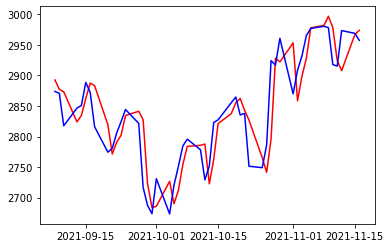

In [17]:
Y_test=Y_t.iloc[675:725]
Y_test=pd.DataFrame(Y_test)
predds_1=pd.DataFrame(predds_0, index=Y_test.index)
predds_1
plt.plot(predds_1, color='red')
plt.plot(Y_test, color='blue')

In [19]:
print(Errors_A[0].mean())
print(Errors_B[0].mean())
print(Errors_C[0].mean())

1823.2939441880446
2657333.7868777183
1822.3405153977


In [20]:
print(Errors_A[1].mean())
print(Errors_B[1].mean())
print(Errors_C[1].mean())

32.7396376574767
1627.9566520578571
32.67127093999039


In [21]:
print(Errors_A[2].mean())
print(Errors_B[2].mean())
print(Errors_C[2].mean())

32.7396376574767
1627.9566520578571
32.67127093999039


In [22]:
print(Errors_A[3].mean())
print(Errors_B[3].mean())
print(Errors_C[3].mean())

1.158582182966735
57.303373483459715
1.1565559421468594
